# Predictive Modeling of Hospital Length of Stay and Discharge Type
# [Step 4: Outliers handling in the merged dataset]

his notebook focuses on identifying and handling outliers in the merged dataset, which includes both laboratory results and clinical data. 
Additional data cleaning steps are also performed.

**Libraries used:**  
- pandas  
- matplotlib  
- seaborn  

**Last updated:** March 28, 2025.  

## Summary

The dataset contains many outliers → Choose a model that handles them well!  

**Extreme outliers detected in:**

(Alphabetical order)  

- **ALAT [Aspartate aminotransferase - U/L]:**

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **AP [Alkaline phosphatases - U/L]:**

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **ASAT [Aspartate aminotransferase - U/L]**
    
    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **BASm#n [Basophils - G/L]:**

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **BIg [Total bilirubin - µmol/L]:**

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **CA [Total calcium - mmol/L]:**

    Upper Outliers (Opposite with Diagnosis):   

    | patient_id | case_id | discharge_type       | sex | age | length_of_stay_days | diagnosis_code | diagnosis_text | CA  |
    |------------|---------|----------------------|-----|-----|---------------------|----------------|----------------|-----|
    | 118605     | 178476  | Discharge tariff status | f   | 74  | 11                  | E87.6          | Hypokalaemia    | 4.22 |

    Lower Outliers:

    💡 Most extreme: 0.04 and 0.43. In the original dataset, the corresponding `text_result` is "< 0.50". Consider replacing these very extreme entries with 0.50.

- **CK [Creatine kinase - U/L]:**

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **CO-HB [Carboxyhemoglobin - %]:**

    Considering the corresponding diagnosis, these outliers are plausible.

- **CR [Creatinine (plasma) - µmol/L]:**

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **CRP [C-reactive protein - mg/L]:**

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **EOSm#n [Eosinophil - G/L]:**

    Considering the corresponding diagnosis, these outliers are plausible.

- **EPIGFR [estimated Glomerular Filtration Rate (eGFR) calculated using the CKD-EPI equation - mL/min]:**

    Considering the corresponding diagnosis, these outliers are plausible.

- **Eryn [Erythrocytes - T/L]:**

    Upper outliers:

    Consider removing or tagging Eryn > 9.


    Lower outliers:   

    Erythrocyte count of 0 is incompatible with life. -> Consider removing those entries.

    `merged_data['Eryn'] = merged_data['Eryn'].replace(0, np.nan)`

    |   | patient_id | case_id | age | sex | discharge_type | diagnosis_code | diagnosis_text                                         | Eryn | Hbn   | Hkn  | Leukn | THZn | MCHCn | MCVn | MCHn | RDWn |
    |---|------------|---------|-----|-----|----------------|----------------|-------------------------------------------------------|------|-------|------|-------|------|-------|------|------|------|
    | 1 | 11853      | 291563  | 48  | m   | Discharge to another hospital | N20.1          | Calculus of ureter                                  | 0.0  | 148.0 | 0.45 | 11.30 | 203.0 | 350.0 | 85.0 | 30.0 | 13.7 |
    | 2 | 27799      | 258123  | 76  | f   | Discharge     | K40.30         | Inguinal hernia                                      | 0.0  | 0.0   | 0.35 | 0.00  | 0.0  | 333.0 | 87.0 | 29.0 | 14.0 |
    | 3 | 30078      | 382589  | 47  | f   | Discharge     | S06.0          | Concussion                                           | 0.0  | 0.0   | 0.40 | 0.00  | 0.0  | 339.0 | 91.0 | 31.0 | 12.7 |
    | 4 | 42938      | 73752   | 66  | f   | Discharge     | I50.01         | Heart failure                                        | 0.0  | 114.0 | 0.37 | 11.70 | 198.0 | 302.0 | 90.0 | 28.0 | 19.3 |
    | 5 | 63657      | 315590  | 69  | m   | Discharge     | K56.4          | Other impaction of intestine                         | 0.0  | 0.0   | 0.00 | 5.40  | 239.0 | 333.0 | 77.0 | 26.0 | 15.0 |
    | 6 | 63720      | 148030  | 37  | m   | Discharge     | J10.1          | Influenza with other respiratory manifestation...    | 0.0  | 0.0   | 0.00 | 0.00  | 183.0 | 355.0 | 88.0 | 30.0 | 13.0 |
    | 7 | 87804      | 121115  | 77  | m   | Discharge to another hospital | I24.9          | Acute ischaemic heart disease, unspecified           | 0.0  | 0.0   | 0.00 | 0.00  | 0.0  | NaN   | NaN  | NaN  | NaN  |
    | 8 | 92880      | 7394    | 82  | m   | Discharge     | I20.0          | Unstable angina                                      | 0.0  | 0.0   | 0.00 | 10.10 | 274.0 | 329.0 | 92.0 | 30.0 | 13.6 |
    | 9 | 124425     | 180407  | 70  | m   | Discharge     | I26.9          | Pulmonary embolism without mention of acute co...    | 0.0  | 0.0   | 0.42 | 10.70 | 290.0 | 342.0 | 86.0 | 29.0 | 13.0 |
    | 10| 125476     | 70817   | 92  | f   | Discharge     | B37.81         | Candidiasis                                          | 0.0  | 98.0  | 0.00 | 6.60  | 0.0  | 317.0 | 91.0 | 29.0 | 13.5 |
    | 11| 149209     | 221842  | 78  | f   | Discharge to another institution | J44.11         | Other chronic obstructive pulmonary disease           | 0.0  | 0.0   | 0.32 | 0.00  | 350.0 | 315.0 | 104.0| 33.0 | 13.7 |
    | 12| 156115     | 344435  | 29  | f   | Discharge     | S06.0          | Concussion                                           | 0.0  | 0.0   | 0.00 | 0.00  | 0.0  | NaN   | NaN  | NaN  | NaN  |
    | 13| 156459     | 104301  | 54  | f   | Discharge to another institution | R45.8          | Other symptoms and signs involving emotional s...   | 0.0  | 142.0 | 0.42 | 8.90  | 281.0 | 346.0 | 90.0 | 31.0 | 13.3 |
    | 14| 162803     | 237198  | 49  | f   | Discharge to another institution | T42.4          | Poisoning: Benzodiazepines                           | 0.0  | 0.0   | 0.00 | 0.00  | 0.0  | NaN   | NaN  | NaN  | NaN  |
    | 15| 164372     | 63418   | 76  | f   | Discharge     | K86.1          | Other chronic pancreatitis                           | 0.0  | 0.0   | 0.34 | 7.05  | 0.0  | 343.0 | 85.0 | 29.0 | 12.7 |
    | 16| 164941     | 386727  | 56  | f   | Discharge to another hospital | D73.5          | Infarction of spleen                                 | 0.0  | 0.0   | 0.40 | 12.60 | 0.0  | 332.0 | 101.0| 34.0 | 12.3 |
    | 17| 172010     | 378100  | 66  | f   | Discharge     | S06.6          | Traumatic subarachnoid haemorrhage                   | 0.0  | 130.0 | 0.39 | 6.40  | 0.0  | 326.0 | 95.0 | 30.0 | 12.9 |

    _
 

- **GGT [Gamma-glutamyl transferase - U/L]:**

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

- **GL [Glucose	- mmol/L]:**

    Upper outliers:

    Considering the corresponding diagnosis, these outliers are elevated but still plausible.

    Lower outliers:
    
    One case with GL 0.00 (correspongind text result entry "< 0.20") -> consider replacing it with 0.20.

- **H [Haemolytic - /]:**
- **H-Se [Haemolytic (serum) - /]:**
- **Hbn  [Hemoglobin - g/L]:**

    Lower outliers:

    Hemoglobin of 0 is incompatible with life. -> Consider removing those entries.

- **Hkn [Hematocrit - L/L]:**

    Upper outliers:

    Two extreme entries of 42.00 and 36.50, which are clearly an error. -> Consider removing those entries, or replace them with 4.20 and 3.65.

    Lower outliers:

    Hematocrit of 0 is incompatible with life. -> Consider removing those entries.

- **I	[Icteric - /]:**
- **I-Se [Icteric (serum) -/]:**
- **IGm#n [Immature Granulocytes G/L]:**
- **INRiH [INR - /]:**

    Upper outliers:

    One entry 9999.0 -> text_result > 5.5 -> consider replacing with 5.5 or removing it.

    Lower outliers:
    
    One case with INRiH 0.0 (correspongind text result entry "< 1.0") -> consider removing it or replacing it with 1.0.

- **KA [Potassium - mmol/L]:**

    Upper outliers:

    52 entries where KA > 9.8 mmol/L.

- **L [Lipemic - /]:**
- **L-Se [Lipemic (serum) - /]:**	
- **LACT [Arterial lactate - mmol/L]:**	

    note: text_abbr of LACT comprehen both lactact (3255) 
            
        mean: 2.446755
        sd: 2.438729
        min: 0.300000
        25%: 1.100000
        50%: 1.700000
        75%: 2.700000
        max: 23.000000

    and lactat arteriell (165547 entries)
           
        mean: 2.61651
        sd: 2.62328
        min: 0.00000
        25%: 1.10000
        50%: 1.75000
        75%: 3.00000
        max: 31.00000

- **LYMm#n [Lymphocytes - G/L]:**  
- **Leukn [Leukocytes - G/L]:**  
- **MCHCn [MCHC - g/L]:**  
- **MCHn [MCH - pg]:**  
- **MCVn [MCV - fL]:**  
- **MONm#n [Monocytes - G/L]:**  
- **MPVn [MPV - fL]:**  
- **MTHB [Methemoglobin - g/L]:**  
- **NEUm#n [Neutrophils - G/L]:**  
- **NRBCmn [Normoblasts machine count - /100 Leuk.]:**  
- **Na [Sodium - mmol/L]:**  

    Upper outliers:  

    One case where Na > 190.00 (199.00) -> patient deceased.  

    Lower outliers:  

    118 entries where Na < 100 (of which 11 < 10)  

- **QUHD [Quick - %]:**  

    Upper outliers:  

    13 entries where QUHD is 9999.0, meaning -> > 100.0 -> consider removing or replacing with 173.2?  
        or imputing values based on Quicks values.  

    Max value < 9999.0 is 173.2.  

- **Quicks [Venous PT - sec]:**  
- **RDWn [RDW - %]:**  
- **THZn [Thrombocytes - G/L]:**  
- **TNThsn [Troponin T hs - ng/L]:**  
- **Tbga [Body temperature - °C]:**  
- **UREA [Urea - mmol/L]:**  
- **pCO2 [pCO2 - mmHg]:**  
- **pH [pH -]:**  
- **pO2 [pO2 - mmHg]:**  
- **tHb [Hemoglobin - g/L]:**



The excluded entries included hemoglobin (Hbn) values of 0, erythrocyte (Eryn) counts of 0, hematocrit
(Hkn) values greater than 1, INR values of 9999 or 5001.36 (likely placeholders or errors), QUHD values of
9999.00 (placeholders), calcium (CA) values of 0, body temperature (Tbga) entry of 34,103°C, pCO2 values
of 200, and pO2 values of 0. These values were deemed unrealistic and removed from further analysis. T



## 1. Import libraries and load dataset

In [2]:
# Import data manipulation library
import pandas as pd
import math

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define file paths for input dataset 
merged_data_path = "/home/anna/Desktop/Master_thesis/output_data/2_merged_data" 

# Define output path for cleaned output dataset  
cleaned_merged_data_path = "/home/anna/Desktop/Master_thesis/output_data/2_cleaned_merged_data"  

In [3]:
lab_data_path = "/home/anna/Desktop/Master_thesis/output_data/pre-cleaned_lab_data" 
# Load lab dataset 
lab_data = pd.read_csv(lab_data_path)

In [4]:
# Load dataset 
merged_data = pd.read_csv(merged_data_path)
display(merged_data)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,...,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
0,1,171465,Discharge,f,73,28,A04.70,Other bacterial intestinal infections,Infectious diseases,10.0,...,13.2,18.3,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,333396,Discharge,f,73,34,K57.22,Diverticular disease of intestine,Digestive diseases,19.0,...,11.6,18.8,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,27091,Discharge,m,51,13,T84.5,Infection and inflammatory reaction due to int...,Injury & poisoning,NaN,...,14.0,18.9,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,36154,Discharge to another institution,m,50,12,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,38.0,...,12.7,14.4,131.0,367.0,NaN,4.5,NaN,NaN,NaN,NaN
4,2,142617,Discharge to another hospital,m,51,1,T84.5,Infection and inflammatory reaction due to int...,Injury & poisoning,15.0,...,19.2,17.6,159.0,NaN,NaN,5.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269015,240988,393440,Discharge,m,79,2,K55.21,Vascular disorders of intestine,Digestive diseases,12.0,...,10.3,13.8,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269016,240988,412516,Discharge,m,79,10,I11.00,Hypertensive heart disease,Circulatory diseases,11.0,...,11.0,14.3,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269017,240988,425806,Discharge to another institution,m,79,7,M16.7,Other secondary coxarthrosis,Musculoskeletal diseases,NaN,...,NaN,13.2,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269018,240989,393141,Discharge,m,62,1,I49.3,Ventricular premature depolarization,Circulatory diseases,NaN,...,10.9,13.6,269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Identify outliers, and analyze extreme values for each lab test

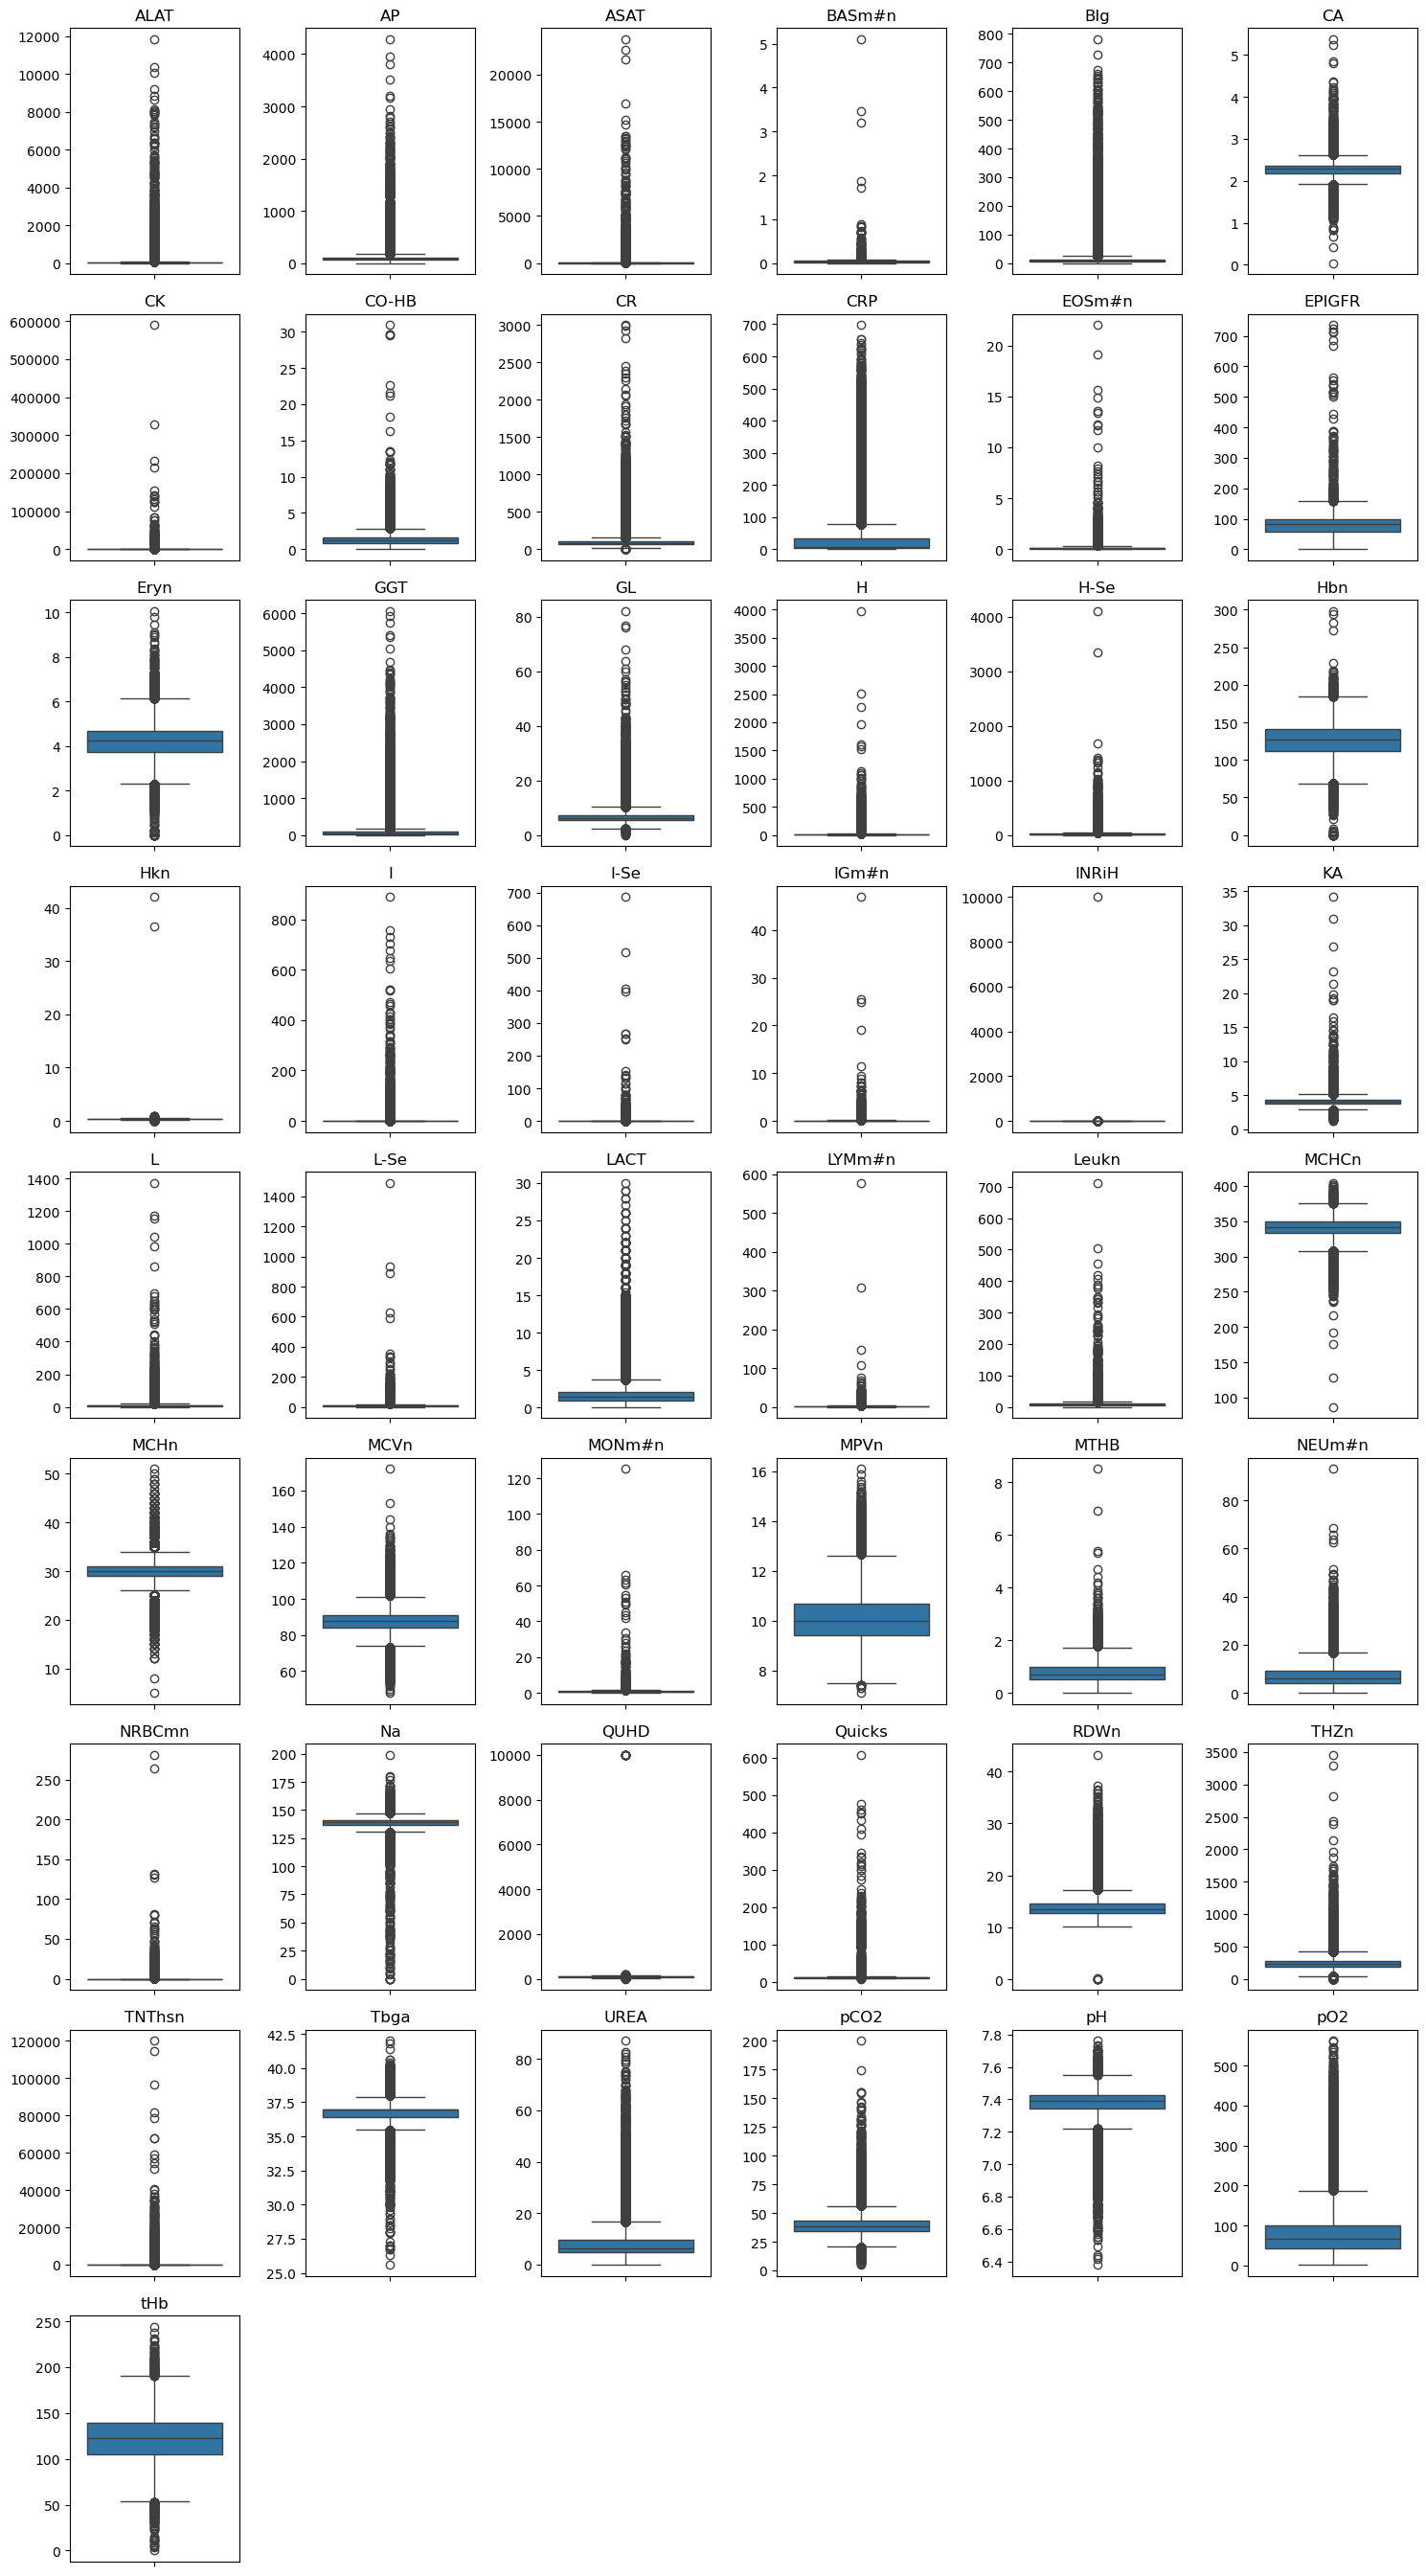

In [5]:
# Select lab test columns (starting from the 10th column)
lab_test_cols = merged_data.columns[9:]

# Dynamically determine subplot grid size
num_cols = len(lab_test_cols)
num_rows = math.ceil(num_cols / 6) 

plt.figure(figsize=(15, num_rows * 3))  # Scale figure height

for i in range(num_cols):
    plt.subplot(num_rows, 6, i + 1) 
    sns.boxplot(y=merged_data[lab_test_cols[i]])  
    plt.title(lab_test_cols[i]) 
    plt.ylabel('')

plt.tight_layout() 
plt.show()


In [6]:
def detect_extreme_outliers(df, columns, multiplier=3):
    """
    Detects extreme outliers in the given columns using the IQR method.
    
    Args:
        df (pd.DataFrame): The dataframe to analyze.
        columns (list): List of column names to check for outliers.
        multiplier (float): The multiplier for defining extreme outliers (default is 3 for very extreme).
        
    Returns:
        pd.DataFrame: A dataframe with all extreme outlier rows.
    """
    outlier_rows = pd.DataFrame()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        lower_outliers = df[df[col] < lower_bound].sort_values(by=col, ascending=True)
        upper_outliers = df[df[col] > upper_bound].sort_values(by=col, ascending=False)

        if not lower_outliers.empty:
            print(f"\nExtreme lower outliers detected in {col}:")
            display(lower_outliers)
        
        if not upper_outliers.empty:
            print(f"\nExtreme upper outliers detected in {col}:")
            display(upper_outliers)

        outlier_rows = pd.concat([outlier_rows, lower_outliers, upper_outliers])

    return outlier_rows.drop_duplicates()


In [7]:
pd.set_option('display.max_columns', None) # Display all columns
extreme_outliers = detect_extreme_outliers(merged_data, lab_test_cols)


Extreme upper outliers detected in ALAT:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
128318,122850,107423,Discharge,m,57,5,B15.9,Hepatitis A without hepatic coma,Infectious diseases,11844.0,121.0,10598.0,NaN,100.0,2.07,NaN,NaN,84.0,18.0,NaN,89.0,5.07,301.0,3.79,8.0,3.0,139.0,0.40,7.0,7.0,NaN,2.20,4.2,11.0,20.0,4.9,NaN,5.52,352.0,27.0,78.0,NaN,10.8,NaN,NaN,0.0,139.0,29.0,21.7,14.7,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130458,124888,241285,Discharge to another institution,m,39,27,R68.8,Other specified general symptoms and signs,Symptoms & abnormal findings,10372.0,NaN,1127.0,0.01,6.0,NaN,1757.0,0.7,139.0,18.0,0.00,35.0,3.70,49.0,4.70,8.0,19.0,132.0,0.34,1.0,0.0,0.14,1.31,4.5,6.0,3.0,3.0,0.90,19.00,332.0,31.0,98.0,0.37,8.9,0.6,17.63,0.0,132.0,31.1,21.3,13.0,279.0,1468.0,36.0,9.1,38.0,7.105,79.0,117.0
86903,83217,363340,Deceased,m,34,0,J96.00,"Respiratory failure, not elsewhere classified",Respiratory diseases,10061.0,120.0,12050.0,0.19,8.0,NaN,855.0,0.9,226.0,1.0,0.31,31.0,4.97,97.0,5.40,28.0,NaN,148.0,0.41,1.0,NaN,1.42,1.85,5.4,13.0,NaN,17.0,2.48,19.50,317.0,29.0,91.0,1.38,10.3,1.1,10.83,0.1,148.0,35.3,19.1,13.2,53.0,423.0,34.2,5.1,47.0,7.192,503.0,139.0
125299,119908,228964,Discharge to another hospital,f,25,3,K71.1,Toxic liver disease with hepatic necrosis,Digestive diseases,9226.0,92.0,4185.0,0.04,42.0,2.11,NaN,0.9,51.0,13.0,0.01,129.0,5.41,44.0,9.45,18.0,NaN,152.0,0.47,2.0,NaN,0.08,2.43,4.0,12.0,NaN,1.7,1.15,11.40,354.0,29.0,82.0,0.81,10.1,1.3,12.20,0.0,137.0,NaN,20.4,12.5,267.0,NaN,37.4,1.9,35.0,7.357,50.0,168.0
175580,169071,332397,Deceased,m,59,0,T82.8,Other specified complications of cardiac and v...,Injury & poisoning,8857.0,NaN,23743.0,0.05,50.0,NaN,1499.0,0.7,85.0,25.0,0.01,86.0,3.45,42.0,0.30,40.0,NaN,114.0,0.34,4.0,NaN,0.17,NaN,5.8,12.0,NaN,16.0,0.70,13.80,334.0,33.0,99.0,0.79,10.4,0.9,12.09,0.2,140.0,NaN,NaN,12.5,57.0,328.0,37.0,5.4,27.0,7.141,84.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173921,167561,14736,Discharge to another institution,f,66,32,I60.3,Subarachnoid haemorrhage from posterior commun...,Circulatory diseases,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,93.0,NaN,76.0,3.72,305.0,NaN,1.0,NaN,107.0,0.34,1.0,NaN,NaN,NaN,4.0,13.0,NaN,NaN,NaN,11.20,319.0,29.0,90.0,NaN,9.5,NaN,NaN,0.0,138.0,NaN,NaN,15.3,680.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112504,107757,249809,Discharge,m,58,3,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,100.0,NaN,106.0,NaN,NaN,NaN,205.0,NaN,95.0,52.0,NaN,76.0,3.66,NaN,5.89,1101.0,NaN,108.0,0.32,2.0,NaN,NaN,1.07,3.5,60.0,NaN,NaN,NaN,7.34,339.0,30.0,87.0,NaN,11.0,NaN,NaN,0.0,NaN,84.9,11.4,16.1,211.0,799.0,NaN,NaN,NaN,NaN,NaN,NaN
134099,128419,249367,Discharge,f,86,5,N12,"Tubulo-interstitial nephritis, not specified a...",Genitourinary diseases,100.0,241.0,145.0,0.04,48.0,2.50,NaN,NaN,48.0,87.0,0.00,86.0,4.52,202.0,10.60,1.0,4.0,139.0,0.40,3.0,4.0,0.09,1.28,3.4,7.0,8.0,NaN,0.16,13.90,349.0,31.0,88.0,1.13,9.9,NaN,12.56,0.0,133.0,57.6,NaN,11.9,295.0,NaN,NaN,2.5,NaN,NaN,NaN,NaN
6083,5766,367582,Discharge,m,73,6,R50.88,Fever of other and unknown origin,Symptoms & abnormal findings,100.0,268.0,103.0,0.06,6.0,NaN,30.0,NaN,69.0,259.0,0.02,90.0,3.94,330.0,6.92,10.0,7.0,106.0,0.32,1.0,1.0,0.94,1.01,4.0,8.0,8.0,NaN,1.58,20.90,333.0,27.0,81.0,2.82,9.4,NaN,15.64,0.0,141.0,100.5,11.0,13.5,575.0,12.3,37.0,6.9,41.0,7.425,72.0,NaN



Extreme upper outliers detected in AP:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
66219,63426,51027,Deceased,f,52,6,C78.7,Secondary malignant neoplasm of liver and intr...,Neoplasms,57.0,4283.0,280.0,NaN,128.0,NaN,NaN,NaN,115.0,200.0,NaN,47.0,3.20,1053.0,1.07,4.0,NaN,81.0,0.28,9.0,NaN,NaN,1.35,4.1,19.0,NaN,9.3,NaN,3.83,303.0,25.0,83.0,NaN,11.0,NaN,NaN,2.1,128.0,52.4,14.5,22.8,152.0,NaN,37.0,NaN,28.0,7.237,38.0,NaN
87353,83626,378727,Discharge,f,68,2,T85.51,Complications of other internal prosthetic dev...,Injury & poisoning,93.0,3956.0,86.0,0.07,15.0,2.35,NaN,NaN,56.0,7.0,0.00,92.0,3.63,838.0,10.64,20.0,21.0,90.0,0.26,1.0,1.0,0.09,1.10,3.3,18.0,48.0,1.3,3.13,10.20,344.0,29.0,82.0,0.87,10.1,NaN,6.12,0.2,137.0,77.8,12.0,20.1,527.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN
151781,145728,148832,Discharge to another hospital,m,72,9,C79.5,Secondary malignant neoplasm of bone and bone ...,Neoplasms,4.0,3803.0,36.0,0.01,11.0,2.05,NaN,NaN,39.0,167.0,0.04,112.0,2.64,129.0,5.27,1.0,0.0,89.0,0.24,1.0,1.0,NaN,1.38,3.2,25.0,6.0,NaN,0.71,5.96,313.0,29.0,92.0,0.39,7.5,NaN,3.74,NaN,137.0,52.7,NaN,16.1,263.0,NaN,NaN,3.2,NaN,NaN,NaN,NaN
169408,163047,256869,Discharge,m,66,4,K83.1,Obstruction of bile duct,Digestive diseases,209.0,3521.0,249.0,0.05,275.0,2.14,NaN,NaN,60.0,47.0,0.03,100.0,3.06,2770.0,4.54,3.0,NaN,88.0,0.25,18.0,NaN,0.04,1.25,4.4,40.0,NaN,0.7,0.56,6.41,331.0,29.0,87.0,0.66,11.5,NaN,5.38,0.1,132.0,60.5,13.1,16.4,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32912,31452,132149,Discharge,f,68,10,C24.0,Malignant neoplasm: Extrahepatic bile duct,Neoplasms,38.0,3203.0,61.0,NaN,43.0,NaN,NaN,NaN,59.0,44.0,NaN,91.0,NaN,2747.0,5.80,2.0,NaN,NaN,NaN,50.0,NaN,NaN,1.06,3.6,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,87.9,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30445,29197,380742,Discharge,f,85,2,R11,Nausea and vomiting,Symptoms & abnormal findings,28.0,265.0,45.0,0.03,9.0,2.20,NaN,NaN,37.0,9.0,0.02,94.0,3.57,266.0,6.16,NaN,NaN,112.0,0.33,NaN,NaN,NaN,1.04,3.5,NaN,NaN,NaN,0.44,4.23,341.0,31.0,92.0,0.25,9.7,NaN,3.49,NaN,135.0,94.6,NaN,14.1,210.0,NaN,NaN,2.1,NaN,NaN,NaN,NaN
24051,22930,299927,Deceased,f,92,0,C18.7,Malignant neoplasm: Sigmoid colon,Neoplasms,14.0,265.0,25.0,0.02,11.0,2.02,NaN,NaN,NaN,32.0,0.00,NaN,3.69,370.0,5.71,41.0,NaN,108.0,0.32,1.0,NaN,0.05,0.94,3.1,4.0,NaN,1.3,0.34,9.48,335.0,29.0,87.0,0.20,9.1,NaN,8.87,0.0,139.0,115.4,10.3,14.9,557.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171071,164712,189567,Discharge,m,61,1,C22.0,Malignant neoplasm: Liver cell carcinoma,Neoplasms,137.0,265.0,52.0,0.06,28.0,2.32,NaN,NaN,69.0,35.0,0.30,97.0,3.78,561.0,10.50,11.0,NaN,98.0,0.30,2.0,NaN,0.08,1.07,4.5,13.0,NaN,0.8,0.45,4.87,327.0,26.0,79.0,0.37,9.9,NaN,3.61,0.2,133.0,86.1,11.4,17.6,326.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62344,59703,60834,Discharge to another institution,m,90,10,A46,Erysipelas,Infectious diseases,14.0,265.0,41.0,0.06,3.0,2.18,NaN,NaN,162.0,312.0,0.15,29.0,3.29,263.0,8.50,10.0,9.0,95.0,0.34,0.0,0.0,0.69,1.97,3.8,7.0,3.0,1.7,0.70,11.70,325.0,29.0,89.0,0.99,9.2,NaN,9.04,0.2,139.0,46.6,15.1,15.7,492.0,NaN,NaN,10.9,NaN,NaN,NaN,NaN



Extreme upper outliers detected in ASAT:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
175580,169071,332397,Deceased,m,59,0,T82.8,Other specified complications of cardiac and v...,Injury & poisoning,8857.0,NaN,23743.0,0.05,50.0,NaN,1499.0,0.7,85.0,25.0,0.01,86.0,3.45,42.0,0.3,40.0,NaN,114.0,0.34,4.0,NaN,0.17,NaN,5.8,12.0,NaN,16.0,0.70,13.80,334.0,33.0,99.0,0.79,10.4,0.9,12.09,0.2,140.0,NaN,NaN,12.5,57.0,328.0,37.0,5.4,27.0,7.141,84.0,84.0
44296,42485,206496,Discharge to another hospital,m,51,8,I23.5,Rupture of papillary muscle as current complic...,Circulatory diseases,3265.0,NaN,22589.0,NaN,34.0,NaN,702.0,0.2,252.0,141.0,NaN,24.0,2.63,130.0,5.8,91.0,NaN,88.0,0.32,2.0,NaN,NaN,1.65,4.3,9.0,NaN,4.2,NaN,15.20,359.0,34.0,96.0,NaN,11.4,1.3,NaN,0.2,137.0,41.1,22.5,12.5,161.0,NaN,35.1,16.3,38.0,7.356,36.0,91.0
220529,211585,5583,Discharge to another hospital,f,46,6,K72.0,Acute and subacute hepatic failure,Digestive diseases,4709.0,169.0,21617.0,NaN,68.0,NaN,294.0,0.9,204.0,15.0,NaN,25.0,NaN,124.0,10.8,5.0,NaN,NaN,NaN,56.0,NaN,NaN,NaN,3.5,13.0,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,130.0,NaN,NaN,NaN,NaN,NaN,37.2,8.1,38.0,7.297,87.0,116.0
176383,169895,148574,Discharge to another hospital,f,75,1,I50.01,Heart failure,Circulatory diseases,4495.0,NaN,16969.0,NaN,28.0,NaN,159.0,0.6,196.0,107.0,NaN,21.0,3.83,64.0,7.2,50.0,NaN,132.0,0.35,2.0,NaN,NaN,1.58,4.2,8.0,NaN,14.0,NaN,26.00,308.0,32.0,90.0,NaN,10.2,0.3,NaN,6.1,134.0,36.9,17.3,12.5,204.0,149.0,34.8,14.3,38.0,7.486,80.0,112.0
200480,192877,295171,Deceased,f,33,11,I46.0,Cardiac arrest with successful resuscitation,Circulatory diseases,8127.0,NaN,15186.0,NaN,25.0,NaN,234.0,0.7,105.0,31.0,NaN,66.0,4.59,44.0,5.4,8.0,NaN,94.0,0.40,2.0,NaN,NaN,1.59,3.5,9.0,NaN,3.5,NaN,10.60,311.0,26.0,78.0,NaN,10.2,0.8,NaN,0.1,139.0,41.7,17.9,14.6,205.0,63.6,36.7,9.0,27.0,7.450,76.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128427,122973,289337,Deceased,m,86,3,I50.01,Heart failure,Circulatory diseases,351.0,346.0,100.0,NaN,13.0,NaN,NaN,NaN,188.0,36.0,NaN,27.0,3.89,165.0,NaN,3.0,5.0,118.0,0.39,1.0,1.0,NaN,1.21,4.4,4.0,2.0,NaN,NaN,13.70,299.0,30.0,101.0,NaN,11.5,NaN,NaN,0.9,164.0,64.0,NaN,17.0,199.0,NaN,NaN,29.4,NaN,NaN,NaN,NaN
91607,87757,141148,Discharge to another institution,m,34,1,F10.4,Mental and behavioural disorders due to use of...,Mental disorders,64.0,61.0,100.0,0.05,17.0,2.49,563.0,NaN,93.0,16.0,0.13,92.0,3.86,368.0,4.7,17.0,11.0,133.0,0.38,1.0,1.0,0.06,0.92,3.1,6.0,2.0,2.2,1.98,7.01,349.0,34.0,99.0,1.03,11.3,NaN,3.76,0.1,134.0,125.7,9.8,11.8,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7554,7178,360805,Discharge to another hospital,f,65,6,I63.8,Other cerebral infarction,Circulatory diseases,31.0,NaN,100.0,NaN,3.0,2.09,3482.0,1.2,60.0,27.0,NaN,92.0,3.69,11.0,7.1,6.0,8.0,104.0,0.30,0.0,1.0,NaN,1.10,4.7,9.0,2.0,0.7,NaN,9.58,338.0,31.0,90.0,NaN,10.2,0.4,NaN,0.0,134.0,77.8,11.5,12.7,231.0,70.8,36.2,8.0,46.0,7.416,82.0,105.0
158098,151789,111144,Discharge,f,29,21,O72.1,Other immediate postpartum haemorrhage,Pregnancy & childbirth,10.0,NaN,100.0,0.02,7.0,NaN,396.0,1.6,80.0,12.0,0.03,86.0,2.20,9.0,5.1,10.0,15.0,61.0,0.18,1.0,1.0,0.12,1.01,4.3,1.0,4.0,1.9,0.82,15.00,358.0,30.0,83.0,0.73,10.2,0.5,13.31,0.1,131.0,97.9,11.0,15.6,41.0,121.0,36.6,3.1,44.0,7.240,85.0,74.0



Extreme upper outliers detected in BASm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
125249,119859,294343,Discharge,m,38,4,C92.10,Myeloid leukaemia,Neoplasms,101.0,64.0,49.0,5.10,8.0,2.34,NaN,NaN,100.0,2.0,1.43,90.0,3.78,36.0,7.20,29.0,NaN,118.0,0.35,1.0,NaN,46.89,1.02,3.8,10.0,NaN,1.5,8.57,134.00,334.0,28.0,86.0,2.04,9.9,NaN,93.06,0.8,142.0,96.2,10.7,16.4,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204551,196682,45078,Discharge,m,47,2,C92.10,Myeloid leukaemia,Neoplasms,48.0,NaN,NaN,3.46,11.0,2.37,264.0,NaN,84.0,NaN,1.10,95.0,4.15,42.0,5.80,11.0,9.0,123.0,0.37,1.0,1.0,25.49,1.06,3.8,11.0,10.0,2.0,5.51,86.10,338.0,30.0,87.0,3.63,10.3,NaN,46.99,0.5,138.0,87.0,11.1,17.6,164.0,NaN,NaN,4.8,NaN,NaN,NaN,NaN
189129,182019,300766,Discharge,m,46,3,C92.10,Myeloid leukaemia,Neoplasms,39.0,82.0,41.0,3.21,9.0,2.20,NaN,NaN,60.0,15.0,0.81,102.0,3.66,95.0,7.90,8.0,NaN,126.0,0.33,1.0,NaN,24.91,1.11,3.1,20.0,NaN,5.1,3.71,102.00,369.0,35.0,95.0,4.77,11.6,NaN,65.55,0.0,125.0,69.9,12.0,14.2,235.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN
119668,114554,361777,Discharge,f,43,3,C92.10,Myeloid leukaemia,Neoplasms,18.0,64.0,22.0,1.87,9.0,2.20,NaN,NaN,57.0,257.0,0.29,109.0,3.80,37.0,6.95,8.0,NaN,108.0,0.33,1.0,NaN,19.08,1.29,3.8,3.0,NaN,NaN,2.08,89.70,331.0,28.0,86.0,2.91,11.3,NaN,63.55,0.2,140.0,57.2,13.5,15.4,324.0,NaN,NaN,2.8,NaN,NaN,NaN,NaN
252202,233326,413613,Discharge,m,71,3,N20.0,Calculus of kidney,Genitourinary diseases,NaN,NaN,NaN,1.71,NaN,2.39,NaN,NaN,92.0,0.0,0.74,72.0,4.81,NaN,NaN,27.0,NaN,145.0,0.44,1.0,NaN,6.52,1.08,5.0,48.0,NaN,NaN,3.48,26.10,330.0,30.0,92.0,0.56,9.5,NaN,13.18,0.1,142.0,83.7,11.2,16.4,824.0,NaN,37.0,9.0,41.0,7.406,43.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182335,175552,294230,Discharge,f,71,3,C34.3,"Malignant neoplasm: Lower lobe, bronchus or lung",Neoplasms,38.0,1383.0,57.0,0.15,5.0,1.88,18.0,NaN,53.0,87.0,0.82,92.0,3.35,927.0,8.60,7.0,NaN,102.0,0.32,0.0,NaN,0.80,1.09,3.7,9.0,NaN,1.7,0.41,32.70,324.0,30.0,94.0,0.87,10.3,NaN,29.65,0.1,141.0,82.0,11.5,19.0,180.0,24.4,NaN,NaN,NaN,NaN,NaN,NaN
185039,178177,130962,Discharge,f,77,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,15.0,83.0,15.0,0.15,NaN,2.13,NaN,NaN,55.0,NaN,0.03,87.0,3.46,27.0,5.53,6.0,NaN,102.0,0.29,1.0,NaN,0.58,NaN,3.8,7.0,NaN,NaN,0.37,10.50,347.0,30.0,85.0,0.60,10.3,NaN,8.85,0.2,140.0,NaN,NaN,18.5,210.0,NaN,NaN,4.6,NaN,NaN,NaN,NaN
186205,179218,378662,Discharge,f,66,6,M54.87,Dorsalgia,Musculoskeletal diseases,NaN,NaN,NaN,0.15,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,3.98,NaN,NaN,NaN,NaN,122.0,0.35,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,1.90,5.92,347.0,31.0,88.0,0.69,11.0,NaN,2.92,0.0,NaN,NaN,NaN,13.1,161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51197,48976,176668,Discharge,m,85,6,I50.01,Heart failure,Circulatory diseases,36.0,201.0,61.0,0.15,14.0,2.29,428.0,NaN,219.0,26.0,6.32,22.0,4.07,694.0,5.70,20.0,54.0,127.0,0.38,1.0,1.0,0.06,1.37,4.8,6.0,4.0,2.4,1.66,12.10,329.0,31.0,95.0,0.77,11.0,NaN,3.14,0.1,145.0,51.7,14.4,15.9,156.0,228.0,NaN,19.2,NaN,NaN,NaN,NaN



Extreme upper outliers detected in BIg:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
82687,79110,82052,Deceased,f,72,1,K71.0,Toxic liver disease with cholestasis,Digestive diseases,28.0,26.0,228.0,NaN,781.0,2.39,165.0,1.7,148.0,22.0,NaN,20.0,1.39,178.0,5.79,107.0,78.0,56.0,0.17,64.0,66.0,NaN,3.81,5.8,54.0,53.0,3.1,NaN,17.40,326.0,33.0,92.0,NaN,10.9,1.5,NaN,1.6,139.0,18.1,35.3,14.8,100.0,51.3,36.2,17.9,33.0,7.325,77.0,46.0
48553,46573,150052,Discharge to another hospital,m,66,3,K74.6,Other and unspecified cirrhosis of liver,Digestive diseases,1507.0,1384.0,8628.0,0.05,729.0,2.38,50.0,1.5,199.0,35.0,0.04,23.0,4.33,282.0,9.30,2.0,52.0,145.0,0.40,59.0,58.0,0.26,2.08,4.1,32.0,26.0,10.8,0.46,8.48,360.0,33.0,92.0,0.98,13.5,0.4,6.69,0.0,130.0,31.1,29.2,21.7,120.0,NaN,34.8,16.5,25.0,7.277,79.0,142.0
150056,144086,368314,Discharge to another hospital,f,60,6,C22.1,Malignant neoplasm: Intrahepatic bile duct car...,Neoplasms,393.0,1901.0,531.0,NaN,674.0,NaN,NaN,NaN,98.0,NaN,NaN,54.0,3.10,958.0,NaN,0.0,NaN,96.0,0.26,54.0,NaN,NaN,1.13,4.1,34.0,NaN,NaN,NaN,11.60,364.0,31.0,85.0,NaN,8.2,NaN,NaN,0.0,122.0,74.8,11.9,19.8,130.0,NaN,NaN,10.3,NaN,NaN,NaN,NaN
61636,58980,4536,Deceased,m,66,14,K70.3,Alcoholic cirrhosis of liver,Digestive diseases,34.0,126.0,60.0,NaN,660.0,2.14,NaN,NaN,206.0,12.0,NaN,27.0,NaN,28.0,9.50,0.0,NaN,NaN,NaN,888.0,NaN,NaN,1.55,4.1,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,43.1,NaN,NaN,NaN,NaN,37.0,15.9,26.0,7.306,37.0,NaN
152173,146113,26896,Discharge to another hospital,m,75,3,C19,Malignant neoplasm of rectosigmoid junction,Neoplasms,50.0,383.0,65.0,0.10,653.0,1.88,NaN,NaN,153.0,55.0,0.20,33.0,2.32,196.0,NaN,0.0,0.0,58.0,0.16,50.0,53.0,0.12,1.19,2.9,29.0,33.0,NaN,0.17,10.20,371.0,38.0,102.0,0.64,11.1,NaN,5.99,0.0,136.0,63.2,12.8,15.0,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29572,28361,375764,Discharge,m,70,2,C22.0,Malignant neoplasm: Liver cell carcinoma,Neoplasms,100.0,552.0,339.0,NaN,39.0,NaN,NaN,NaN,173.0,26.0,NaN,34.0,3.78,422.0,NaN,5.0,13.0,114.0,0.32,3.0,4.0,NaN,1.20,4.7,13.0,22.0,NaN,NaN,9.53,336.0,30.0,92.0,NaN,10.2,NaN,NaN,0.0,143.0,65.0,12.4,17.2,266.0,NaN,NaN,13.8,NaN,NaN,NaN,NaN
179830,173051,263007,Discharge to another institution,m,68,30,I50.14,Heart failure,Circulatory diseases,21.0,114.0,39.0,0.02,39.0,2.43,NaN,2.5,252.0,133.0,0.00,22.0,3.24,279.0,7.20,4.0,2.0,97.0,0.29,2.0,3.0,0.10,1.87,4.2,11.0,6.0,0.8,0.41,8.07,316.0,29.0,90.0,0.92,11.0,0.7,15.73,0.1,137.0,27.4,18.9,27.8,111.0,NaN,35.0,28.3,42.0,7.390,111.0,96.0
73303,70147,64859,Discharge to another hospital,f,80,0,K80.30,Cholelithiasis,Digestive diseases,697.0,226.0,429.0,0.03,39.0,2.38,NaN,NaN,84.0,200.0,0.10,57.0,3.63,1034.0,10.94,5.0,NaN,113.0,0.32,3.0,NaN,0.03,1.09,3.5,23.0,NaN,NaN,1.13,10.00,352.0,31.0,88.0,0.48,9.6,NaN,8.29,NaN,133.0,86.6,111.0,13.1,193.0,NaN,NaN,9.6,NaN,NaN,NaN,119.0
180478,173691,214409,Discharge,m,84,5,I50.14,Heart failure,Circulatory diseases,29.0,167.0,32.0,NaN,39.0,NaN,NaN,NaN,93.0,12.0,NaN,65.0,4.41,290.0,6.99,181.0,NaN,145.0,0.42,3.0,NaN,NaN,1.38,4.7,6.0,NaN,NaN,NaN,5.15,347.0,33.0,95.0,NaN,11.7,NaN,NaN,0.0,140.0,50.6,14.8,15.6,138.0,79.6,NaN,7.5,NaN,NaN,NaN,NaN



Extreme lower outliers detected in CA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
5622,5373,278026,Discharge,f,89,4,K52.8,Other specified noninfective gastroenteritis a...,Digestive diseases,11.0,19.0,24.0,NaN,13.0,0.04,42.0,1.0,218.0,1.0,NaN,27.0,4.57,14.0,4.60,34.0,NaN,125.0,0.37,1.0,NaN,NaN,1.06,5.3,13.0,NaN,2.60,NaN,8.31,334.0,30.0,87.0,NaN,10.3,0.5,NaN,0.0,140.0,88.4,11.3,12.6,221.0,NaN,37.0,26.7,41.0,7.345,20.0,132.0
46188,44305,361649,Discharge to another hospital,f,70,7,A41.51,Other sepsis,Infectious diseases,172.0,232.0,10.0,0.01,2.0,0.43,NaN,1.3,345.0,242.0,0.25,11.0,3.36,29.0,4.20,15.0,NaN,107.0,0.33,1.0,NaN,0.01,1.35,4.2,4.0,NaN,0.40,0.30,4.69,320.0,34.0,106.0,0.43,10.3,0.1,3.69,0.0,132.0,30.2,13.3,16.3,91.0,31.0,37.0,1.6,37.0,7.367,168.0,108.0
193660,186288,297991,Discharge to another hospital,f,93,6,J18.8,"Other pneumonia, organism unspecified",Respiratory diseases,8.0,213.0,42.0,0.01,9.0,0.68,463.0,NaN,24.0,11.0,0.02,61.0,4.02,157.0,5.80,51.0,NaN,65.0,0.19,1.0,NaN,0.02,2.06,4.0,1.0,NaN,NaN,0.62,5.38,335.0,32.0,97.0,0.70,8.8,NaN,7.11,0.0,139.0,31.4,21.9,13.4,108.0,NaN,NaN,3.1,NaN,NaN,NaN,NaN
76572,73144,308465,Discharge to another institution,f,93,3,I63.4,Cerebral infarction due to embolism of cerebra...,Circulatory diseases,NaN,64.0,13.0,NaN,NaN,0.83,35.0,NaN,43.0,1.0,NaN,84.0,4.38,9.0,4.30,39.0,258.0,128.0,0.38,0.0,0.0,NaN,1.03,4.4,2.0,6.0,NaN,NaN,6.84,338.0,29.0,86.0,NaN,12.4,NaN,NaN,0.0,137.0,94.6,10.9,13.8,167.0,10.4,NaN,5.0,NaN,NaN,NaN,NaN
161009,154573,382337,Discharge to another hospital,f,65,13,I63.4,Cerebral infarction due to embolism of cerebra...,Circulatory diseases,NaN,NaN,8.0,NaN,NaN,0.84,12.0,1.0,NaN,13.0,NaN,NaN,4.66,8.0,6.50,4.0,4.0,126.0,0.39,0.0,0.0,NaN,1.10,3.6,2.0,6.0,0.50,NaN,6.30,325.0,27.0,83.0,NaN,8.2,0.8,NaN,0.0,146.0,79.9,12.2,13.9,196.0,8.3,35.8,2.5,46.0,7.323,180.0,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148802,142854,99655,Discharge,m,79,4,E83.58,Disorders of mineral metabolism,Endocrine & metabolic,10.0,88.0,18.0,0.05,10.0,1.64,NaN,1.1,110.0,7.0,0.03,71.0,4.57,22.0,7.70,4.0,8.0,139.0,0.38,1.0,1.0,0.02,1.25,3.3,4.0,1.0,NaN,1.83,9.88,355.0,30.0,84.0,0.71,10.4,1.1,7.50,NaN,141.0,62.6,NaN,12.6,286.0,NaN,NaN,5.6,NaN,NaN,NaN,130.0
80956,77435,303369,Discharge to another institution,m,70,23,I50.19,Heart failure,Circulatory diseases,77.0,151.0,78.0,0.07,9.0,1.64,338.0,NaN,441.0,12.0,0.06,15.0,3.61,37.0,6.70,4.0,2.0,93.0,0.32,1.0,1.0,0.06,1.43,4.7,7.0,5.0,0.43,0.77,5.36,290.0,27.0,88.0,0.39,12.1,NaN,7.10,5.4,140.0,47.0,14.7,21.4,224.0,31.2,NaN,31.3,NaN,NaN,NaN,100.0
91950,88049,218369,Discharge,f,91,8,I50.14,Heart failure,Circulatory diseases,12.0,111.0,22.0,NaN,5.0,1.64,340.0,NaN,79.0,26.0,NaN,42.0,3.41,110.0,7.67,1.0,NaN,105.0,0.32,1.0,NaN,NaN,1.03,3.5,9.0,NaN,NaN,NaN,6.91,349.0,33.0,95.0,NaN,9.7,NaN,NaN,NaN,114.0,93.5,11.0,12.0,249.0,NaN,NaN,4.8,NaN,NaN,NaN,NaN
108234,103585,90397,Discharge,m,71,2,T82.8,Other specified complications of cardiac and v...,Injury & poisoning,NaN,NaN,NaN,0.03,NaN,1.64,NaN,NaN,990.0,26.0,0.27,4.0,3.26,NaN,NaN,9.0,NaN,115.0,0.33,0.0,NaN,0.03,1.03,5.9,10.0,NaN,NaN,2.28,7.88,344.0,35.0,102.0,0.61,10.0,NaN,4.66,0.0,132.0,94.6,10.9,13.5,130.0,NaN,37.0,37.9,29.0,7.220,59.0,NaN



Extreme upper outliers detected in CA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
24973,23849,235335,Deceased,f,57,1,R57.2,Septic shock,Symptoms & abnormal findings,56.0,NaN,97.0,NaN,59.0,5.37,355.0,1.3,205.0,NaN,NaN,33.0,4.09,NaN,4.90,16.0,NaN,123.0,0.37,5.0,NaN,NaN,1.38,4.1,6.0,NaN,5.2,NaN,20.40,336.0,30.0,90.0,NaN,10.9,0.7,NaN,0.3,140.0,51.1,14.1,14.6,162.0,555.0,34.8,11.7,64.0,7.213,68.0,113.0
94633,90504,51870,Discharge to another hospital,m,71,12,C61,Malignant neoplasm of prostate,Neoplasms,15.0,54.0,113.0,0.03,13.0,5.24,NaN,1.9,113.0,67.0,0.10,75.0,2.43,21.0,6.47,8.0,NaN,67.0,0.19,0.0,NaN,1.30,1.10,3.8,4.0,NaN,1.2,0.65,10.90,358.0,30.0,83.0,0.61,10.7,0.8,7.48,1.0,146.0,80.1,12.4,14.6,85.0,NaN,37.0,NaN,41.0,7.365,106.0,69.0
248554,231775,409023,Discharge to another hospital,m,45,4,M89.58,Other disorders of bone,Musculoskeletal diseases,16.0,129.0,18.0,NaN,6.0,4.85,NaN,NaN,NaN,6.0,NaN,NaN,3.23,72.0,4.83,NaN,3.0,102.0,0.27,NaN,1.0,NaN,1.17,3.3,NaN,3.0,NaN,NaN,5.05,361.0,31.0,87.0,NaN,10.0,NaN,NaN,NaN,139.0,71.1,NaN,12.5,243.0,NaN,NaN,13.4,NaN,NaN,NaN,101.0
194286,186819,16410,Discharge to another hospital,f,75,10,C50.9,"Malignant neoplasm: Breast, unspecified",Neoplasms,48.0,110.0,62.0,NaN,19.0,4.79,NaN,NaN,257.0,129.0,NaN,15.0,3.24,143.0,6.80,25.0,29.0,113.0,0.31,1.0,2.0,NaN,1.35,4.6,11.0,6.0,1.9,NaN,7.62,320.0,30.0,91.0,NaN,11.8,NaN,NaN,2.5,136.0,54.0,NaN,16.4,89.0,NaN,NaN,18.3,NaN,NaN,NaN,NaN
8160,7708,197748,Discharge,f,58,5,C91.10,Lymphoid leukaemia,Neoplasms,12.0,NaN,NaN,NaN,10.0,4.37,NaN,NaN,72.0,29.0,NaN,80.0,4.84,21.0,NaN,4.0,13.0,139.0,0.42,1.0,1.0,NaN,1.13,3.3,12.0,6.0,NaN,NaN,22.60,333.0,29.0,86.0,NaN,11.8,NaN,NaN,0.0,139.0,76.2,12.0,14.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127887,122430,385840,Discharge to another hospital,m,84,10,E83.58,Disorders of mineral metabolism,Endocrine & metabolic,6.0,41.0,10.0,0.02,3.0,2.90,NaN,1.0,162.0,9.0,0.28,33.0,4.21,81.0,5.50,6.0,10.0,113.0,0.36,0.0,0.0,0.04,1.00,4.6,10.0,7.0,1.1,1.61,10.70,340.0,29.0,85.0,1.11,12.2,1.1,7.65,0.0,131.0,103.0,10.9,15.4,155.0,NaN,37.0,NaN,42.0,7.301,31.0,123.0
87089,83388,160128,Discharge to another hospital,m,61,1,C43.7,Malignant neoplasm: Malignant melanoma of lowe...,Neoplasms,17.0,194.0,40.0,0.02,11.0,2.90,NaN,NaN,70.0,225.0,0.07,97.0,5.14,147.0,14.40,5.0,30.0,157.0,0.46,1.0,1.0,1.30,1.18,4.3,10.0,2.0,NaN,1.85,15.10,348.0,30.0,89.0,0.87,9.9,NaN,11.07,0.2,134.0,67.6,12.6,13.0,206.0,NaN,NaN,9.8,NaN,NaN,NaN,164.0
10299,9738,117941,Discharge to another hospital,f,70,3,A08.4,"Viral intestinal infection, unspecified",Infectious diseases,17.0,108.0,19.0,0.02,7.0,2.90,NaN,NaN,83.0,82.0,0.02,62.0,4.52,22.0,8.70,8.0,12.0,124.0,0.34,1.0,1.0,0.04,0.97,3.6,6.0,4.0,1.5,0.80,7.40,359.0,28.0,76.0,0.68,10.1,NaN,5.84,0.0,134.0,110.1,10.3,12.8,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88883,85092,74076,Discharge to another hospital,m,76,5,K75.0,Abscess of liver,Digestive diseases,56.0,480.0,64.0,0.04,6.0,2.90,NaN,NaN,74.0,102.0,0.54,85.0,3.45,3343.0,5.97,3.0,4.0,105.0,0.32,0.0,1.0,0.03,0.95,3.8,11.0,2.0,NaN,0.70,10.30,326.0,30.0,93.0,0.96,10.2,NaN,8.07,0.0,138.0,112.8,10.2,15.6,429.0,NaN,NaN,5.5,NaN,NaN,NaN,NaN



Extreme upper outliers detected in CK:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
16592,15785,111849,Discharge,f,23,11,M62.80,Other disorders of muscle,Musculoskeletal diseases,1399.0,63.0,4701.0,0.10,6.0,NaN,589210.0,1.2,43.0,141.0,0.09,145.0,5.81,48.0,8.80,20.0,12.0,167.0,0.50,1.0,1.0,0.32,1.27,3.7,2.0,3.0,3.3,2.31,22.70,351.0,28.0,81.0,0.61,11.1,0.5,27.62,0.0,128.0,59.7,13.8,14.2,304.0,5.59,36.1,2.4,29.0,7.512,86.0,169.0
238366,227135,410762,Discharge to another institution,m,37,57,T82.5,Mechanical complication of other cardiac and v...,Injury & poisoning,263.0,NaN,2005.0,NaN,13.0,NaN,327320.0,1.3,82.0,NaN,NaN,NaN,NaN,NaN,6.60,9.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,5.7,9.0,NaN,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,36.0,5.0,41.0,7.249,240.0,74.0
18643,17725,85564,Discharge to another hospital,m,57,9,I71.03,Aortic aneurysm and dissection,Circulatory diseases,591.0,39.0,1827.0,NaN,7.0,NaN,232020.0,0.1,114.0,1.0,NaN,45.0,3.87,9.0,8.20,12.0,NaN,112.0,0.32,0.0,NaN,NaN,1.25,4.0,10.0,NaN,5.1,NaN,11.20,344.0,32.0,97.0,NaN,9.6,0.9,NaN,0.0,139.0,42.7,12.0,15.3,130.0,3769.00,37.1,9.3,23.0,7.180,32.0,90.0
34665,33171,121988,Deceased,m,51,3,I71.03,Aortic aneurysm and dissection,Circulatory diseases,823.0,NaN,3226.0,0.01,NaN,NaN,214062.0,0.7,198.0,NaN,0.03,33.0,2.94,NaN,9.10,31.0,NaN,91.0,0.27,3.0,NaN,0.12,1.66,5.1,12.0,NaN,5.3,0.98,10.00,360.0,31.0,86.0,0.13,9.9,1.1,3.96,0.2,135.0,39.5,16.3,13.3,66.0,NaN,36.0,12.1,41.0,7.198,36.0,91.0
222692,213649,296743,Discharge to another hospital,f,42,47,A40.0,"Sepsis due to streptococcus, group A",Infectious diseases,230.0,NaN,334.0,NaN,3.0,1.52,154812.0,0.6,187.0,213.0,NaN,28.0,3.44,11.0,3.50,16.0,NaN,99.0,0.32,1.0,NaN,NaN,2.11,4.3,1.0,NaN,7.2,NaN,2.73,350.0,29.0,81.0,NaN,10.5,1.1,NaN,0.0,127.0,24.1,20.8,14.0,10.0,243.00,35.0,8.8,38.0,6.940,47.0,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256046,235033,400175,Discharge,m,62,7,I34.0,Mitral (valve) insufficiency,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,550.0,1.6,74.0,1.0,NaN,94.0,5.04,NaN,6.03,29.0,NaN,153.0,0.43,1.0,NaN,NaN,0.99,3.7,14.0,NaN,1.8,NaN,7.52,354.0,30.0,86.0,NaN,10.9,1.2,NaN,0.0,142.0,102.5,10.8,12.8,279.0,NaN,35.9,NaN,42.0,7.360,63.0,131.0
103035,98538,117660,Discharge to another hospital,m,47,10,S33.4,Traumatic rupture of symphysis pubis,Injury & poisoning,25.0,NaN,36.0,NaN,6.0,NaN,550.0,0.8,110.0,2.0,NaN,69.0,4.88,24.0,7.10,11.0,NaN,148.0,0.45,1.0,NaN,NaN,1.02,4.2,9.0,NaN,1.2,NaN,17.00,331.0,30.0,92.0,NaN,10.3,1.1,NaN,0.0,141.0,98.4,10.9,13.3,213.0,4.10,37.0,6.0,49.0,7.359,60.0,137.0
130962,125410,106267,Discharge,f,76,5,I26.0,Pulmonary embolism with mention of acute cor p...,Circulatory diseases,1976.0,NaN,3147.0,0.02,12.0,2.27,550.0,0.3,116.0,90.0,0.00,40.0,4.32,53.0,11.50,7.0,NaN,134.0,0.37,1.0,NaN,0.15,1.49,4.8,9.0,NaN,5.2,2.52,18.40,345.0,31.0,87.0,0.71,8.9,0.5,13.79,0.1,142.0,46.6,15.6,13.8,34.0,691.00,37.0,16.7,24.0,7.362,34.0,134.0
99428,95125,325206,Discharge,m,72,8,F51.3,Sleepwalking [somnambulism],Mental disorders,NaN,NaN,NaN,NaN,NaN,2.20,550.0,NaN,82.0,4.0,NaN,82.0,4.03,NaN,4.70,15.0,NaN,137.0,0.39,3.0,NaN,NaN,1.27,3.5,3.0,NaN,NaN,NaN,7.93,351.0,34.0,97.0,NaN,9.7,NaN,NaN,0.0,140.0,59.1,13.3,13.2,207.0,13.20,NaN,7.9,NaN,NaN,NaN,NaN



Extreme upper outliers detected in CO-HB:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
54594,52185,295484,Discharge to another hospital,m,48,0,T58,Toxic effect of carbon monoxide,Injury & poisoning,41.0,56.0,33.0,0.02,3.0,2.50,442.0,30.9,86.0,0.0,0.08,92.0,4.89,29.0,6.05,12.0,NaN,146.0,0.42,0.0,NaN,0.00,1.01,3.3,36.0,NaN,NaN,2.18,7.45,347.0,30.0,86.0,0.63,11.1,0.9,4.54,NaN,140.0,100.8,11.1,12.6,191.0,NaN,NaN,5.8,NaN,NaN,NaN,147.0
55038,52634,170016,Discharge to another hospital,m,47,0,T58,Toxic effect of carbon monoxide,Injury & poisoning,22.0,NaN,25.0,NaN,6.0,NaN,235.0,29.7,83.0,1.0,NaN,96.0,4.73,19.0,10.10,18.0,NaN,144.0,0.41,1.0,NaN,NaN,1.04,3.8,7.0,NaN,3.3,NaN,11.70,351.0,30.0,87.0,NaN,9.8,1.2,NaN,0.0,138.0,93.2,11.1,12.1,200.0,6.34,35.7,5.9,31.0,7.465,191.0,146.0
84183,80581,244479,Discharge to another hospital,m,69,0,I46.0,Cardiac arrest with successful resuscitation,Circulatory diseases,150.0,NaN,175.0,NaN,5.0,NaN,155.0,29.6,148.0,2.0,NaN,28.0,4.50,90.0,20.30,235.0,NaN,147.0,0.46,0.0,NaN,NaN,1.57,4.3,48.0,NaN,11.7,NaN,19.90,321.0,33.0,102.0,NaN,10.3,3.9,NaN,0.1,133.0,42.3,16.5,12.3,256.0,NaN,36.8,6.5,65.0,6.723,109.0,148.0
76715,73277,180336,Discharge to another hospital,m,41,0,T58,Toxic effect of carbon monoxide,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.5,82.0,1.0,NaN,102.0,5.53,NaN,6.10,22.0,NaN,164.0,0.47,1.0,NaN,NaN,1.07,3.8,13.0,NaN,1.6,NaN,7.15,347.0,30.0,86.0,NaN,11.5,1.2,NaN,0.0,141.0,85.9,11.3,13.2,181.0,4.85,36.5,NaN,37.0,7.416,243.0,163.0
1873,1708,120421,Discharge,m,58,1,C78.0,Secondary malignant neoplasm of lung,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.6,NaN,NaN,NaN,NaN,3.87,NaN,NaN,NaN,NaN,129.0,0.39,NaN,NaN,NaN,1.14,NaN,NaN,NaN,NaN,NaN,5.43,332.0,32.0,93.0,NaN,9.0,8.5,NaN,0.0,NaN,71.0,12.4,13.2,516.0,NaN,37.0,NaN,44.0,7.394,19.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162022,155514,330220,Discharge,f,71,1,S40.0,Contusion of shoulder and upper arm,Injury & poisoning,25.0,65.0,37.0,0.05,3.0,2.27,210.0,4.1,64.0,1.0,0.07,84.0,4.43,30.0,5.62,3.0,NaN,135.0,0.41,1.0,NaN,NaN,1.01,5.1,6.0,NaN,NaN,1.54,6.21,328.0,30.0,93.0,0.45,8.7,0.4,4.09,NaN,135.0,98.5,10.6,12.8,299.0,NaN,NaN,5.0,NaN,NaN,NaN,144.0
101134,96771,383570,Discharge,m,66,16,C04.8,Malignant neoplasm: Overlapping lesion of floo...,Neoplasms,13.0,77.0,17.0,NaN,NaN,2.43,NaN,4.1,57.0,26.0,NaN,102.0,3.82,25.0,6.61,8.0,9.0,126.0,0.36,0.0,0.0,NaN,1.02,5.7,20.0,16.0,1.4,NaN,10.20,346.0,33.0,95.0,NaN,8.3,1.3,NaN,0.0,135.0,98.4,10.9,11.9,287.0,NaN,36.9,4.9,49.0,7.370,99.0,120.0
101088,96721,204058,Discharge,f,66,6,K43.2,Incisional hernia without obstruction or gangrene,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,9.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,NaN,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,43.0,7.310,74.0,145.0
225048,215838,103802,Discharge,m,72,8,J44.09,Other chronic obstructive pulmonary disease,Respiratory diseases,13.0,78.0,22.0,0.08,7.0,1.94,NaN,4.1,164.0,94.0,0.13,36.0,5.27,23.0,5.57,9.0,NaN,143.0,0.43,1.0,NaN,0.05,1.11,2.3,15.0,NaN,NaN,0.53,13.70,329.0,27.0,82.0,0.93,9.4,0.8,12.03,NaN,139.0,81.3,12.1,14.1,438.0,NaN,NaN,5.6,NaN,NaN,NaN,135.0



Extreme upper outliers detected in CR:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
237504,226765,420687,Discharge,m,29,5,N18.5,"Chronic kidney disease, stage 5",Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,2.23,NaN,NaN,2995.0,NaN,NaN,1.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,37.0,47.9,42.0,7.397,28.0,NaN
237501,226765,418640,Discharge,m,28,4,K21.0,Gastro-oesophageal reflux disease with oesopha...,Digestive diseases,NaN,NaN,NaN,NaN,NaN,1.65,NaN,NaN,2994.0,5.0,NaN,1.0,3.60,NaN,NaN,5.0,NaN,98.0,0.29,1.0,NaN,NaN,NaN,4.6,7.0,NaN,NaN,NaN,10.10,340.0,27.0,80.0,NaN,11.3,NaN,NaN,0.0,136.0,NaN,NaN,15.6,207.0,NaN,NaN,45.4,NaN,NaN,NaN,NaN
237488,226765,398686,Discharge to another institution,m,28,8,N18.5,"Chronic kidney disease, stage 5",Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,1.97,NaN,NaN,2920.0,2.0,NaN,1.0,4.61,NaN,NaN,6.0,11.0,127.0,0.37,1.0,1.0,NaN,1.08,4.5,10.0,7.0,NaN,NaN,5.10,347.0,28.0,79.0,NaN,11.6,NaN,NaN,0.2,135.0,86.1,11.4,16.4,311.0,NaN,37.0,48.6,37.0,7.354,63.0,NaN
237487,226765,397832,Discharge,m,29,15,N18.5,"Chronic kidney disease, stage 5",Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,2.46,474.0,NaN,2821.0,11.0,NaN,2.0,2.85,NaN,6.0,4.0,4.0,79.0,0.22,1.0,1.0,NaN,1.09,6.5,7.0,3.0,NaN,NaN,5.58,326.0,26.0,78.0,NaN,10.1,NaN,NaN,0.4,132.0,83.3,11.8,18.9,305.0,NaN,37.0,65.9,38.0,7.362,44.0,NaN
237496,226765,409033,Discharge,m,28,3,N18.5,"Chronic kidney disease, stage 5",Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,1.74,NaN,NaN,2452.0,NaN,NaN,2.0,3.64,NaN,6.4,11.0,NaN,97.0,0.28,1.0,NaN,NaN,2.05,5.6,17.0,NaN,NaN,NaN,5.37,342.0,27.0,78.0,NaN,11.1,NaN,NaN,0.0,125.0,31.5,21.0,17.2,164.0,NaN,37.0,44.6,40.0,7.303,46.0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254437,234287,397664,Discharge to another hospital,m,73,2,A41.9,"Sepsis, unspecified",Infectious diseases,68.0,NaN,NaN,NaN,NaN,NaN,NaN,1.2,208.0,179.0,NaN,26.0,3.33,NaN,8.8,6.0,NaN,93.0,0.27,2.0,NaN,NaN,1.22,4.1,6.0,NaN,5.1,NaN,14.60,331.0,26.0,80.0,NaN,11.7,1.3,NaN,0.3,140.0,63.1,12.5,16.5,165.0,NaN,37.0,11.7,52.0,7.299,61.0,89.0
191489,184238,85687,Discharge,m,47,15,I20.0,Unstable angina,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,208.0,4.0,NaN,32.0,4.21,NaN,6.4,36.0,NaN,121.0,0.36,1.0,NaN,NaN,1.08,4.2,12.0,NaN,NaN,NaN,5.53,334.0,29.0,86.0,NaN,11.0,NaN,NaN,0.0,138.0,83.9,11.4,15.9,107.0,23.0,NaN,8.2,NaN,NaN,NaN,NaN
37132,35586,177183,Discharge,m,88,1,N39.0,"Urinary tract infection, site not specified",Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,2.22,NaN,NaN,208.0,38.0,NaN,24.0,4.03,NaN,7.6,35.0,NaN,118.0,0.33,1.0,NaN,NaN,1.05,3.8,4.0,NaN,1.2,NaN,11.60,354.0,29.0,83.0,NaN,11.4,NaN,NaN,0.0,140.0,89.5,11.4,13.7,160.0,NaN,NaN,10.1,NaN,NaN,NaN,NaN
177963,171406,23554,Discharge,f,41,1,N32.8,Other specified disorders of bladder,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,1.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,15.0,NaN,NaN,0.93,3.3,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,113.6,NaN,NaN,NaN,NaN,NaN,12.9,NaN,NaN,NaN,NaN



Extreme upper outliers detected in CRP:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
11509,10795,337340,Discharge to another hospital,m,53,12,A41.8,Other specified sepsis,Infectious diseases,87.0,81.0,129.0,NaN,73.0,2.30,236.0,0.2,500.0,697.0,NaN,11.0,4.55,233.0,7.70,8.0,13.0,140.0,0.38,5.0,5.0,NaN,1.21,3.5,8.0,7.0,1.10,NaN,7.44,343.0,29.0,82.0,NaN,13.5,0.8,NaN,0.3,138.0,64.2,11.5,13.4,101.0,50.70,38.1,25.1,42.0,7.395,77.0,138.0
74256,71035,184194,Deceased,f,86,0,I21.3,Acute transmural myocardial infarction of unsp...,Circulatory diseases,32.0,NaN,85.0,NaN,15.0,NaN,684.0,0.2,392.0,654.0,NaN,8.0,4.08,55.0,9.50,13.0,NaN,119.0,0.39,1.0,NaN,NaN,1.49,5.2,7.0,NaN,15.00,NaN,6.70,304.0,29.0,96.0,NaN,11.2,0.7,NaN,27.2,139.0,46.3,16.1,17.2,131.0,117.00,36.8,29.4,53.0,6.867,97.0,103.0
68348,65417,360714,Deceased,f,83,5,A41.0,Sepsis due to Staphylococcus aureus,Infectious diseases,18.0,70.0,31.0,NaN,11.0,2.47,NaN,NaN,53.0,654.0,NaN,85.0,5.03,27.0,10.60,8.0,NaN,148.0,0.43,1.0,NaN,NaN,1.09,4.0,4.0,NaN,3.24,NaN,10.20,341.0,29.0,86.0,NaN,9.1,NaN,NaN,0.0,135.0,83.6,NaN,16.9,252.0,NaN,NaN,13.7,NaN,NaN,NaN,154.0
228220,218829,134776,Discharge to another hospital,m,66,10,A41.9,"Sepsis, unspecified",Infectious diseases,147.0,103.0,105.0,NaN,34.0,NaN,160.0,1.5,228.0,641.0,NaN,25.0,2.68,181.0,9.70,32.0,NaN,87.0,0.28,2.0,NaN,NaN,1.04,3.8,10.0,NaN,3.20,NaN,13.10,332.0,31.0,94.0,NaN,12.9,1.2,NaN,16.4,149.0,108.2,11.3,16.8,249.0,45.30,36.9,27.2,55.0,7.461,114.0,81.0
234987,225510,25544,Discharge to another institution,f,65,28,G06.2,"Extradural and subdural abscess, unspecified",Nervous system diseases,18.0,NaN,22.0,0.09,NaN,2.38,NaN,0.7,61.0,636.0,0.20,92.0,3.69,128.0,5.30,7.0,NaN,107.0,0.32,0.0,NaN,0.40,1.10,3.2,6.0,NaN,0.80,1.40,16.20,334.0,29.0,87.0,1.93,8.4,1.1,13.34,0.0,143.0,73.9,12.0,14.7,349.0,13.50,36.6,6.8,45.0,7.399,121.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226344,217023,217529,Discharge,m,49,2,J12.8,Other viral pneumonia,Respiratory diseases,NaN,NaN,71.0,0.01,9.0,NaN,633.0,0.0,61.0,123.0,0.00,112.0,4.80,NaN,6.35,8.0,NaN,144.0,0.41,1.0,NaN,0.03,1.05,3.6,6.0,NaN,NaN,1.07,6.09,352.0,30.0,85.0,0.16,9.0,0.6,4.82,0.0,136.0,90.8,11.2,12.8,213.0,6.37,37.0,3.7,35.0,7.447,72.0,150.0
239647,227683,406824,Discharge,m,55,32,M46.46,Other inflammatory spondylopathies,Musculoskeletal diseases,18.0,398.0,26.0,NaN,16.0,NaN,NaN,NaN,67.0,123.0,NaN,103.0,4.20,85.0,6.40,12.0,NaN,106.0,0.36,1.0,NaN,NaN,1.22,3.3,10.0,NaN,1.10,NaN,17.10,340.0,29.0,85.0,NaN,9.5,NaN,NaN,0.0,135.0,66.1,13.1,13.7,375.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254796,234458,409081,Discharge,m,78,6,R23.3,Spontaneous ecchymoses,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.0,123.0,NaN,51.0,3.88,NaN,12.41,4.0,NaN,108.0,0.32,1.0,NaN,NaN,1.38,4.7,13.0,NaN,NaN,NaN,10.90,342.0,29.0,85.0,NaN,10.6,NaN,NaN,0.0,141.0,20.6,14.6,13.8,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181934,175143,61439,Discharge,m,35,3,G03.8,Meningitis due to other specified causes,Nervous system diseases,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN,123.0,0.12,NaN,4.52,NaN,6.20,13.0,NaN,141.0,0.40,1.0,NaN,0.03,1.02,3.6,7.0,NaN,NaN,1.31,8.33,353.0,31.0,88.0,1.04,9.5,NaN,5.79,0.0,138.0,98.1,11.1,12.2,197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in EOSm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
165908,159504,156513,Discharge to another hospital,f,78,10,I63.4,Cerebral infarction due to embolism of cerebra...,Circulatory diseases,44.0,NaN,38.0,0.10,NaN,2.35,NaN,NaN,65.0,164.0,22.01,79.0,3.41,NaN,6.41,4.0,NaN,106.0,0.31,0.0,NaN,0.22,1.16,4.1,10.0,NaN,NaN,2.72,41.20,341.0,31.0,91.0,1.50,9.5,NaN,14.73,0.0,139.0,70.3,12.2,13.8,309.0,NaN,NaN,2.6,NaN,NaN,NaN,NaN
70241,67215,351175,Discharge,f,64,6,M30.1,Polyarteritis with lung involvement [Churg-Str...,Musculoskeletal diseases,142.0,580.0,64.0,0.21,18.0,2.44,99.0,NaN,61.0,45.0,19.09,92.0,3.88,335.0,5.26,66.0,24.0,133.0,0.34,1.0,1.0,0.49,1.29,3.9,7.0,8.0,1.7,2.38,33.60,359.0,32.0,90.0,0.43,9.1,NaN,11.07,0.1,133.0,57.2,13.9,11.7,1.0,6.22,NaN,NaN,NaN,NaN,NaN,NaN
65122,62392,329348,Discharge to another hospital,m,71,8,I50.14,Heart failure,Circulatory diseases,167.0,NaN,225.0,0.02,8.0,2.45,24.0,1.4,67.0,70.0,15.61,92.0,5.05,580.0,NaN,9.0,14.0,138.0,0.41,1.0,1.0,0.02,1.16,4.7,9.0,4.0,1.2,1.03,7.39,338.0,29.0,87.0,0.72,10.5,0.3,4.34,0.0,138.0,71.4,12.3,15.0,228.0,129.00,36.6,9.3,52.0,7.443,80.0,146.0
128071,122626,313205,Discharge to another hospital,f,51,9,C34.9,"Malignant neoplasm: Bronchus or lung, unspecified",Neoplasms,28.0,629.0,62.0,0.16,12.0,2.05,NaN,NaN,89.0,95.0,14.87,65.0,2.22,609.0,5.50,18.0,NaN,75.0,0.24,1.0,NaN,0.55,NaN,4.0,8.0,NaN,NaN,3.21,39.30,316.0,34.0,107.0,1.50,12.5,NaN,19.09,0.2,131.0,NaN,NaN,19.5,104.0,NaN,NaN,4.6,NaN,NaN,NaN,72.0
191749,184475,236755,Discharge on patient’s own request,m,51,7,L12.0,Bullous pemphigoid,Skin diseases,18.0,NaN,22.0,0.09,3.0,2.01,173.0,NaN,93.0,96.0,13.57,91.0,4.07,34.0,5.41,14.0,6.0,131.0,0.37,0.0,0.0,0.14,1.04,3.7,7.0,6.0,NaN,1.53,29.10,359.0,31.0,86.0,1.44,9.6,NaN,11.65,0.0,137.0,92.2,11.4,12.8,401.0,21.70,NaN,3.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17004,16188,63047,Discharge,f,59,8,F45.41,Somatoform disorders,Mental disorders,19.0,78.0,29.0,0.09,NaN,2.38,NaN,NaN,59.0,2.0,0.55,97.0,4.46,21.0,NaN,7.0,6.0,122.0,0.36,1.0,1.0,0.01,0.98,4.0,7.0,9.0,NaN,1.64,5.62,341.0,27.0,80.0,0.42,8.4,NaN,2.91,0.0,136.0,108.2,10.7,13.2,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170572,164214,231503,Deceased,m,75,4,T84.6,Infection and inflammatory reaction due to int...,Injury & poisoning,9.0,114.0,17.0,0.11,10.0,NaN,NaN,3.7,105.0,166.0,0.55,60.0,2.66,51.0,6.80,6.0,NaN,79.0,0.23,1.0,NaN,0.04,1.10,4.8,1.0,NaN,1.0,2.49,9.82,329.0,30.0,85.0,0.98,9.8,1.2,6.07,0.0,151.0,80.3,11.9,19.0,431.0,NaN,36.3,20.6,40.0,7.470,88.0,70.0
238083,227005,427461,Discharge,m,54,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,NaN,NaN,0.55,NaN,4.10,NaN,NaN,NaN,NaN,125.0,0.41,NaN,NaN,0.03,1.04,NaN,NaN,NaN,NaN,0.85,9.33,348.0,27.0,86.0,1.10,9.9,NaN,6.73,0.0,NaN,88.4,11.1,12.6,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7305,6938,340073,Discharge,f,22,11,G40.2,Localization-related (focal)(partial) symptoma...,Nervous system diseases,26.0,NaN,21.0,0.03,NaN,NaN,76.0,NaN,66.0,0.0,0.55,114.0,4.16,34.0,4.32,6.0,NaN,134.0,0.38,1.0,NaN,0.01,1.05,3.5,6.0,NaN,NaN,2.25,5.57,355.0,32.0,91.0,0.52,10.0,NaN,2.21,0.0,142.0,90.8,11.2,12.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in EPIGFR:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
220736,211748,343085,Discharge,m,21,2,G71.0,Muscular dystrophy,Nervous system diseases,45.0,66.0,57.0,0.03,10.0,2.33,NaN,1.5,0.0,62.0,0.04,735.0,3.78,14.0,4.70,10.0,NaN,115.0,0.34,0.0,NaN,0.06,1.17,3.5,7.0,NaN,1.2,0.58,6.01,334.0,30.0,91.0,0.58,10.2,1.5,10.86,0.0,142.0,67.0,12.4,13.2,367.0,NaN,37.3,NaN,36.0,7.425,70.0,128.0
163495,157084,108748,Discharge,m,23,1,B99,Other and unspecified infectious diseases,Infectious diseases,49.0,88.0,48.0,NaN,16.0,NaN,506.0,NaN,1.0,16.0,NaN,725.0,5.37,74.0,4.57,5.0,103.0,165.0,0.40,1.0,1.0,NaN,1.09,4.1,2.0,11.0,2.9,NaN,5.35,346.0,30.0,89.0,NaN,9.3,NaN,NaN,0.0,138.0,81.8,11.6,13.3,122.0,61.7,NaN,5.4,NaN,NaN,NaN,NaN
69884,66898,384169,Discharge,m,25,9,A41.9,"Sepsis, unspecified",Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,1.0,23.0,NaN,715.0,4.48,NaN,5.50,13.0,NaN,133.0,0.40,0.0,NaN,NaN,1.05,4.1,7.0,NaN,NaN,NaN,7.80,333.0,30.0,89.0,NaN,13.9,0.6,NaN,0.0,137.0,90.5,10.9,13.1,157.0,NaN,37.0,NaN,48.0,7.425,42.0,137.0
77377,73894,314139,Discharge,m,26,8,R13.9,Dysphagia,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,710.0,4.89,NaN,NaN,19.0,NaN,133.0,0.39,1.0,NaN,NaN,1.02,3.8,4.0,NaN,NaN,NaN,7.36,339.0,27.0,80.0,NaN,9.8,NaN,NaN,0.0,137.0,98.4,10.9,13.7,318.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131564,125997,6279,Discharge,m,31,7,T85.5,Mechanical complication of gastrointestinal pr...,Injury & poisoning,49.0,76.0,32.0,0.04,7.0,2.08,NaN,NaN,1.0,46.0,0.05,686.0,4.83,32.0,7.20,11.0,NaN,133.0,0.39,1.0,NaN,0.07,1.08,3.7,12.0,NaN,0.8,1.55,15.20,342.0,28.0,80.0,0.77,8.6,NaN,12.77,0.0,140.0,82.8,11.5,13.6,320.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48074,46102,128423,Discharge,m,24,2,G71.0,Muscular dystrophy,Nervous system diseases,NaN,NaN,NaN,0.05,NaN,NaN,NaN,1.6,15.0,16.0,0.06,237.0,5.49,NaN,NaN,30.0,NaN,156.0,0.45,1.0,NaN,0.04,0.96,3.7,11.0,NaN,NaN,2.75,11.90,346.0,28.0,82.0,0.45,8.9,0.7,8.57,0.0,143.0,110.0,10.8,12.7,362.0,NaN,37.0,NaN,35.0,7.453,93.0,144.0
137800,131930,186211,Discharge to another hospital,m,51,1,N13.2,Hydronephrosis with renal and ureteral calculo...,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,NaN,231.0,4.31,NaN,6.00,5.0,NaN,129.0,0.39,1.0,NaN,NaN,1.06,3.7,9.0,NaN,NaN,NaN,10.70,342.0,31.0,92.0,NaN,9.7,NaN,NaN,0.0,139.0,87.5,NaN,13.2,261.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN
16018,15203,303684,Discharge,m,30,14,K76.8,Other specified diseases of liver,Digestive diseases,389.0,186.0,42.0,0.06,9.0,2.25,311.0,0.8,15.0,102.0,0.06,227.0,2.23,81.0,3.40,5.0,13.0,69.0,0.39,1.0,1.0,0.05,1.18,4.6,8.0,7.0,0.6,1.20,26.10,321.0,28.0,89.0,0.72,11.1,1.7,8.19,0.0,130.0,69.0,12.4,13.4,241.0,36.4,36.8,5.3,38.0,7.318,106.0,54.0
235770,226015,417171,Discharge,m,48,2,J15.8,Other bacterial pneumonia,Respiratory diseases,69.0,82.0,50.0,0.11,5.0,2.25,NaN,1.1,11.0,32.0,0.01,227.0,4.94,126.0,6.00,8.0,NaN,152.0,0.44,1.0,NaN,0.08,1.03,3.4,8.0,NaN,0.8,1.64,11.80,344.0,31.0,90.0,1.22,10.8,0.8,8.82,0.0,143.0,93.8,11.0,12.7,323.0,NaN,38.0,NaN,54.0,7.367,76.0,157.0



Extreme lower outliers detected in Eryn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
162592,156115,344435,Discharge,f,29,2,S06.0,Concussion,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,7.70,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169165,162803,237198,Discharge to another institution,f,49,1,T42.4,Poisoning: Benzodiazepines,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.2,NaN,NaN,NaN,NaN,0.00,NaN,6.80,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,147.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,141.0
162906,156459,104301,Discharge to another institution,f,54,0,R45.8,Other symptoms and signs involving emotional s...,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,NaN,NaN,NaN,NaN,0.00,NaN,5.70,NaN,NaN,142.0,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.30,8.90,346.0,31.0,90.0,NaN,10.0,0.6,6.10,NaN,141.0,NaN,NaN,13.3,281.0,NaN,NaN,NaN,NaN,NaN,NaN,145.0
178669,172010,378100,Discharge,f,66,4,S06.6,Traumatic subarachnoid haemorrhage,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,72.0,1.0,NaN,76.0,0.00,NaN,5.60,6.0,NaN,130.0,0.39,0.0,NaN,NaN,1.10,4.1,15.0,NaN,NaN,1.40,6.40,326.0,30.0,95.0,NaN,10.7,0.9,4.70,NaN,141.0,79.0,11.8,12.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,137.0
191530,184265,326079,Discharge,m,63,1,I10.91,Essential (primary) hypertension,Circulatory diseases,13.0,35.0,15.0,NaN,6.0,NaN,NaN,2.2,NaN,3.0,NaN,NaN,0.00,23.0,5.50,NaN,NaN,0.0,0.00,NaN,NaN,NaN,1.01,3.4,NaN,NaN,NaN,1.70,9.77,352.0,30.0,84.0,NaN,9.8,0.9,6.80,NaN,138.0,98.8,NaN,13.0,0.0,NaN,NaN,3.6,NaN,NaN,NaN,138.0
207305,199333,129742,Discharge,f,60,1,I10.90,Essential (primary) hypertension,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.80,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.90,7.10,338.0,28.0,83.0,NaN,11.3,NaN,3.60,NaN,NaN,NaN,NaN,14.1,1.0,6.01,NaN,NaN,NaN,NaN,NaN,NaN
155431,149209,221842,Discharge to another institution,f,78,8,J44.11,Other chronic obstructive pulmonary disease,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,11.60,13.0,NaN,0.0,0.32,1.0,NaN,NaN,NaN,NaN,16.0,NaN,NaN,1.30,0.00,315.0,33.0,104.0,NaN,10.9,NaN,8.60,NaN,NaN,NaN,NaN,13.7,350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217043,208384,32211,Discharge,f,78,2,A08.4,"Viral intestinal infection, unspecified",Infectious diseases,13.0,102.0,18.0,NaN,NaN,NaN,NaN,2.9,92.0,25.0,NaN,52.0,0.00,26.0,7.40,NaN,NaN,161.0,0.00,NaN,NaN,NaN,1.07,4.6,NaN,NaN,NaN,0.40,13.00,329.0,29.0,88.0,NaN,12.6,0.7,10.80,NaN,142.0,87.4,NaN,15.5,212.0,NaN,NaN,NaN,NaN,NaN,NaN,165.0
131040,125476,70817,Discharge,f,92,2,B37.81,Candidiasis,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.30,NaN,NaN,98.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.20,6.60,317.0,29.0,91.0,NaN,8.8,NaN,3.60,NaN,NaN,NaN,NaN,13.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129976,124425,180407,Discharge,m,70,3,I26.9,Pulmonary embolism without mention of acute co...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,8.70,NaN,NaN,0.0,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.80,10.70,342.0,29.0,86.0,NaN,9.2,NaN,7.60,NaN,NaN,NaN,NaN,13.0,290.0,NaN,NaN,NaN,NaN,NaN,NaN,143.0



Extreme upper outliers detected in Eryn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
24619,23459,44999,Discharge,f,38,1,O43.0,Placental transfusion syndromes,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,1.0,NaN,123.0,10.05,NaN,3.85,2.0,NaN,105.0,0.91,1.0,NaN,NaN,0.90,3.8,11.0,NaN,NaN,NaN,9.15,345.0,28.0,82.0,NaN,9.0,NaN,NaN,0.1,138.0,133.6,9.7,16.3,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123936,118540,188281,Discharge,f,37,1,O36.2,Maternal care for hydrops fetalis,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80,NaN,NaN,NaN,15.0,130.0,0.12,NaN,1.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,2.26,323.0,49.0,88.0,NaN,8.8,NaN,NaN,281.4,NaN,NaN,NaN,26.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191560,184299,113915,Discharge,f,32,1,O36.8,Maternal care for other specified fetal problems,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,2.0,NaN,133.0,9.45,NaN,4.24,9.0,NaN,37.0,0.11,1.0,NaN,NaN,0.94,3.6,4.0,NaN,NaN,NaN,0.36,358.0,30.0,94.0,NaN,11.1,NaN,NaN,0.0,136.0,119.2,10.3,17.8,218.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0
204489,196630,332851,Discharge,m,55,4,I10.11,Essential (primary) hypertension,Circulatory diseases,21.0,58.0,27.0,0.02,16.0,2.23,221.0,1.0,114.0,1.0,0.10,41.0,9.12,59.0,8.90,4.0,NaN,157.0,0.50,2.0,NaN,0.06,1.33,2.8,7.0,NaN,2.2,2.27,10.80,312.0,20.0,60.0,0.95,NaN,0.8,7.90,0.0,135.0,54.7,13.9,22.4,550.0,16.30,37.0,6.4,39.0,7.446,52.0,166.0
204488,196630,280792,Discharge to another hospital,m,55,0,I10.91,Essential (primary) hypertension,Circulatory diseases,15.0,64.0,25.0,0.06,16.0,2.26,241.0,NaN,NaN,1.0,0.23,NaN,9.01,64.0,6.59,NaN,NaN,173.0,0.50,NaN,NaN,NaN,1.22,2.6,NaN,NaN,NaN,2.51,10.50,347.0,19.0,55.0,0.87,NaN,NaN,6.90,NaN,131.0,67.0,NaN,24.6,452.0,NaN,NaN,8.1,NaN,NaN,NaN,NaN
204490,196630,385391,Discharge,m,55,23,I71.2,"Thoracic aortic aneurysm, without mention of r...",Circulatory diseases,16.0,56.0,NaN,NaN,NaN,NaN,89.0,NaN,154.0,0.0,NaN,43.0,8.98,NaN,6.28,8.0,43.0,169.0,0.54,1.0,1.0,NaN,1.19,4.1,6.0,6.0,NaN,NaN,8.11,314.0,19.0,60.0,NaN,NaN,NaN,NaN,0.0,138.0,57.6,12.6,22.9,321.0,NaN,NaN,8.8,NaN,NaN,NaN,NaN
7395,7029,48467,Discharge,m,88,5,S00.05,Superficial injury of head,Injury & poisoning,34.0,70.0,70.0,NaN,17.0,NaN,746.0,NaN,110.0,6.0,NaN,46.0,8.88,28.0,4.70,36.0,NaN,187.0,0.60,1.0,NaN,NaN,1.67,4.1,3.0,NaN,NaN,NaN,8.41,312.0,22.0,72.0,NaN,NaN,NaN,NaN,0.0,140.0,44.3,17.5,22.5,306.0,51.30,NaN,NaN,NaN,NaN,NaN,NaN
204487,196630,279560,Discharge,m,55,1,I71.2,"Thoracic aortic aneurysm, without mention of r...",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,194.0,NaN,NaN,33.0,8.68,NaN,5.37,15.0,NaN,161.0,0.52,1.0,NaN,NaN,1.26,4.5,13.0,NaN,NaN,NaN,7.30,310.0,18.0,60.0,NaN,NaN,NaN,NaN,0.0,NaN,59.3,13.3,22.5,316.0,17.50,NaN,NaN,NaN,NaN,NaN,NaN
242396,228930,392431,Discharge to another institution,m,67,3,J96.10,"Respiratory failure, not elsewhere classified",Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,55.0,2.6,NaN,34.0,NaN,NaN,8.57,NaN,10.71,6.0,NaN,157.0,0.56,1.0,NaN,NaN,1.11,5.0,6.0,NaN,NaN,NaN,9.54,281.0,18.0,65.0,NaN,NaN,0.8,NaN,0.1,140.0,77.1,12.4,26.3,347.0,40.10,37.0,7.7,30.0,7.500,50.0,155.0
251560,233043,391823,Discharge,m,44,2,J67.0,Farmer lung,Respiratory diseases,22.0,NaN,NaN,0.02,NaN,NaN,NaN,NaN,67.0,7.0,0.03,111.0,8.35,NaN,NaN,11.0,NaN,177.0,0.59,1.0,NaN,0.14,1.12,4.2,11.0,NaN,NaN,1.04,12.80,298.0,21.0,71.0,0.65,10.1,NaN,10.95,0.0,139.0,75.8,11.9,22.2,326.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in GGT:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
50066,47992,324975,Discharge to another institution,f,80,13,C25.0,Malignant neoplasm: Head of pancreas,Neoplasms,126.0,2328.0,385.0,0.06,215.0,2.29,2236.0,0.7,76.0,67.0,0.06,62.0,3.43,6062.0,7.30,0.0,NaN,91.0,0.26,13.0,NaN,0.02,2.24,3.0,23.0,NaN,2.5,0.58,7.42,351.0,26.0,76.0,0.57,10.8,0.7,4.96,0.0,146.0,28.3,24.1,16.8,204.0,51.90,36.8,5.3,34.0,7.392,34.0,105.0
155374,149147,94672,Discharge,m,66,4,G40.5,Special epileptic syndromes,Nervous system diseases,80.0,NaN,173.0,NaN,56.0,2.25,446.0,1.1,243.0,10.0,NaN,23.0,3.75,5936.0,13.00,10.0,NaN,122.0,0.32,4.0,NaN,NaN,1.03,3.6,13.0,NaN,1.5,NaN,5.35,354.0,32.0,90.0,NaN,9.9,1.0,NaN,0.0,136.0,89.5,11.7,13.7,122.0,14.90,37.0,8.8,36.0,7.407,37.0,121.0
147250,141230,40778,Discharge,m,50,9,K70.1,Alcoholic hepatitis,Digestive diseases,100.0,210.0,393.0,0.12,329.0,2.20,NaN,NaN,45.0,21.0,0.07,125.0,2.57,5756.0,4.45,4.0,NaN,104.0,0.28,22.0,NaN,0.31,1.23,3.2,41.0,NaN,1.9,1.17,7.72,349.0,37.0,105.0,1.02,11.1,NaN,7.27,0.2,135.0,61.7,13.3,17.2,117.0,NaN,NaN,2.7,NaN,NaN,NaN,NaN
191213,183984,170118,Discharge,f,61,5,K83.08,Other diseases of biliary tract,Digestive diseases,380.0,1010.0,338.0,0.03,23.0,2.39,NaN,NaN,29.0,114.0,0.07,120.0,3.71,5401.0,7.80,4.0,NaN,107.0,0.31,1.0,NaN,0.05,1.07,4.1,7.0,NaN,2.1,0.92,8.90,317.0,26.0,81.0,0.89,9.3,NaN,8.65,0.0,137.0,83.5,11.7,12.4,444.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147252,141230,132547,Discharge,m,50,4,K85.20,Acute pancreatitis,Digestive diseases,65.0,78.0,160.0,0.06,18.0,2.35,295.0,NaN,74.0,0.0,0.00,102.0,3.76,5360.0,8.00,7.0,NaN,123.0,0.36,2.0,NaN,0.39,1.07,3.9,16.0,NaN,3.1,1.21,15.40,341.0,33.0,96.0,1.23,10.3,NaN,12.57,0.1,139.0,85.9,11.1,18.7,247.0,11.40,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55244,52849,342214,Discharge,m,92,8,K80.30,Cholelithiasis,Digestive diseases,119.0,262.0,180.0,0.02,125.0,2.14,NaN,NaN,94.0,81.0,0.02,60.0,3.78,277.0,5.80,2.0,NaN,104.0,0.31,8.0,NaN,0.08,1.24,3.4,3.0,NaN,NaN,0.74,9.90,334.0,28.0,82.0,0.64,10.2,NaN,8.40,0.0,134.0,61.1,NaN,15.6,227.0,NaN,NaN,6.9,NaN,NaN,NaN,NaN
59954,57320,357452,Discharge,m,52,1,K80.20,Cholelithiasis,Digestive diseases,242.0,81.0,108.0,NaN,14.0,2.24,296.0,NaN,90.0,1.0,NaN,84.0,4.43,277.0,5.80,5.0,NaN,130.0,0.37,1.0,NaN,NaN,1.03,3.3,13.0,NaN,NaN,NaN,7.56,349.0,32.0,87.0,NaN,9.8,NaN,NaN,0.0,141.0,100.8,10.5,12.5,220.0,3.81,NaN,8.2,NaN,NaN,NaN,NaN
143657,137764,18054,Discharge to another hospital,m,71,4,C25.2,Malignant neoplasm: Tail of pancreas,Neoplasms,98.0,293.0,96.0,NaN,NaN,2.49,50.0,NaN,60.0,80.0,NaN,96.0,3.94,277.0,12.00,1.0,NaN,97.0,0.31,1.0,NaN,NaN,1.02,4.4,6.0,NaN,NaN,NaN,14.00,311.0,25.0,79.0,NaN,9.0,NaN,NaN,0.0,130.0,98.3,NaN,16.6,514.0,10.98,NaN,NaN,NaN,NaN,NaN,NaN
163404,156988,224038,Discharge,m,75,3,L27.0,Generalized skin eruption due to drugs and med...,Skin diseases,27.0,197.0,50.0,0.04,7.0,1.96,77.0,NaN,77.0,90.0,0.33,84.0,3.95,277.0,5.90,8.0,NaN,91.0,0.29,1.0,NaN,0.09,1.56,3.3,7.0,NaN,1.3,0.46,4.77,344.0,26.0,74.0,0.57,10.4,NaN,4.23,0.0,130.0,43.9,16.8,16.2,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in GL:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
58209,55686,260490,Discharge,m,85,21,E11.91,Type 2 diabetes mellitus,Endocrine & metabolic,17.0,169.0,14.0,0.01,6.0,2.41,NaN,1.8,222.0,71.0,0.01,26.0,3.78,41.0,82.04,9.0,NaN,129.0,0.34,0.0,NaN,NaN,1.04,6.0,32.0,NaN,NaN,0.58,9.40,317.0,30.0,94.0,0.77,11.7,0.0,8.03,NaN,123.0,88.0,NaN,13.6,252.0,NaN,NaN,22.6,NaN,NaN,NaN,125.0
191797,184514,244596,Discharge to another hospital,m,56,0,E11.60,Type 2 diabetes mellitus,Endocrine & metabolic,16.0,117.0,15.0,NaN,4.0,2.02,NaN,NaN,NaN,182.0,NaN,NaN,NaN,NaN,76.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.0,114.1,NaN,NaN,NaN,NaN,NaN,20.6,NaN,NaN,NaN,136.0
202647,194913,187223,Discharge,f,27,4,O45.8,Other premature separation of placenta,Pregnancy & childbirth,7.0,NaN,7.0,0.07,5.0,NaN,NaN,NaN,27.0,1.0,0.05,126.0,2.71,5.0,76.06,11.0,NaN,81.0,0.23,1.0,NaN,0.26,NaN,3.8,4.0,NaN,NaN,1.06,19.50,344.0,33.0,95.0,1.36,11.0,NaN,21.77,0.0,139.0,NaN,11.6,12.6,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129848,124305,344654,Discharge,m,49,11,A41.58,Other sepsis,Infectious diseases,30.0,145.0,36.0,0.03,2.0,1.93,NaN,NaN,43.0,203.0,0.18,129.0,2.73,68.0,67.96,4.0,NaN,87.0,0.24,0.0,NaN,0.01,0.96,7.4,11.0,NaN,1.6,0.31,2.05,345.0,28.0,80.0,0.42,12.1,NaN,0.96,0.0,136.0,112.7,10.1,17.5,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194754,187304,65453,Discharge to another hospital,m,80,26,A41.0,Sepsis due to Staphylococcus aureus,Infectious diseases,18.0,149.0,26.0,0.01,12.0,2.37,1678.0,1.0,146.0,292.0,0.01,36.0,4.73,66.0,63.89,0.0,NaN,137.0,0.42,1.0,NaN,NaN,0.99,3.2,19.0,NaN,NaN,1.15,19.00,340.0,30.0,86.0,1.03,9.1,0.5,15.76,NaN,149.0,101.5,11.0,12.6,317.0,NaN,NaN,12.5,NaN,NaN,NaN,142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248447,231719,420446,Discharge to another institution,m,62,1,F10.0,Mental and behavioural disorders due to use of...,Mental disorders,33.0,40.0,50.0,0.01,20.0,2.14,NaN,NaN,NaN,3.0,0.06,NaN,5.79,48.0,13.53,10.0,NaN,166.0,0.48,2.0,NaN,NaN,1.02,3.2,6.0,NaN,NaN,1.69,3.87,345.0,29.0,83.0,0.23,9.0,NaN,1.88,NaN,140.0,95.8,NaN,14.9,146.0,NaN,NaN,2.8,NaN,NaN,NaN,NaN
92465,88517,386393,Discharge,f,83,2,K56.4,Other impaction of intestine,Digestive diseases,16.0,107.0,21.0,NaN,9.0,NaN,NaN,NaN,115.0,10.0,NaN,38.0,4.91,NaN,13.53,NaN,NaN,154.0,0.46,NaN,NaN,NaN,1.06,3.9,NaN,NaN,NaN,NaN,10.00,338.0,31.0,93.0,NaN,9.1,NaN,NaN,NaN,133.0,91.0,NaN,14.0,255.0,NaN,NaN,9.5,NaN,NaN,NaN,NaN
49693,47652,159500,Discharge to another hospital,f,91,5,S32.03,Fracture of lumbar spine and pelvis,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,18.0,NaN,78.0,4.42,NaN,13.53,NaN,NaN,126.0,0.37,NaN,NaN,NaN,1.00,3.4,NaN,NaN,NaN,NaN,9.74,345.0,28.0,83.0,NaN,8.5,NaN,NaN,NaN,135.0,102.7,NaN,12.9,276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262129,237731,398167,Discharge,f,77,4,T83.5,Infection and inflammatory reaction due to pro...,Injury & poisoning,25.0,68.0,21.0,0.07,13.0,2.23,NaN,1.4,64.0,93.0,0.00,85.0,5.88,112.0,13.53,12.0,NaN,172.0,0.44,1.0,NaN,0.11,1.12,3.9,7.0,NaN,1.6,1.25,19.90,331.0,29.0,88.0,1.43,10.3,1.2,17.07,0.0,138.0,75.2,11.9,13.8,225.0,NaN,38.1,NaN,43.0,7.377,68.0,166.0



Extreme upper outliers detected in H:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
76455,73021,43304,Deceased,f,75,1,A41.4,Sepsis due to anaerobes,Infectious diseases,26.0,132.0,329.0,0.03,98.0,1.98,436.0,2.2,78.0,136.0,0.01,NaN,2.43,35.0,4.70,3971.0,4100.0,28.0,0.19,4.0,7.0,0.65,1.26,4.3,77.0,50.0,8.6,0.84,17.90,217.0,18.0,70.0,0.12,9.3,2.3,18.40,0.9,129.0,60.3,13.3,16.0,154.0,NaN,35.3,NaN,30.0,6.969,28.0,114.0
40685,38960,289451,Discharge to another hospital,f,80,1,I21.0,Acute transmural myocardial infarction of ante...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,1616.0,NaN,70.0,36.0,NaN,71.0,3.71,NaN,12.20,2514.0,243.0,115.0,0.34,1.0,1.0,NaN,NaN,4.7,10.0,8.0,NaN,NaN,6.90,339.0,31.0,91.0,NaN,11.8,NaN,NaN,0.0,131.0,NaN,NaN,12.6,158.0,4206.00,NaN,NaN,NaN,NaN,NaN,NaN
105567,101001,296901,Discharge to another hospital,f,81,2,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.27,154.0,NaN,51.0,15.0,NaN,69.0,4.76,NaN,7.48,2272.0,NaN,148.0,0.42,1.0,NaN,NaN,1.08,3.9,4.0,NaN,NaN,NaN,12.30,342.0,31.0,92.0,NaN,9.6,NaN,NaN,0.0,120.0,81.8,11.4,12.9,264.0,525.00,NaN,5.5,NaN,NaN,NaN,NaN
242594,229028,400046,Discharge,f,40,2,E66.96,Obesity,Endocrine & metabolic,26.0,111.0,100.0,0.02,5.0,NaN,NaN,NaN,24.0,5.0,0.05,122.0,4.01,25.0,6.33,1961.0,NaN,114.0,0.33,1.0,NaN,0.01,1.02,4.0,99.0,NaN,NaN,2.09,4.45,341.0,28.0,83.0,0.35,10.3,NaN,1.93,0.0,142.0,98.1,11.1,13.6,374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137293,131466,316344,Discharge,m,61,1,I20.0,Unstable angina,Circulatory diseases,26.0,67.0,29.0,NaN,5.0,2.53,426.0,NaN,NaN,NaN,NaN,NaN,5.24,NaN,6.00,1604.0,NaN,155.0,0.46,1.0,NaN,NaN,NaN,NaN,199.0,NaN,NaN,3.40,9.10,335.0,30.0,88.0,NaN,11.3,NaN,4.30,NaN,NaN,NaN,NaN,12.7,180.0,5.62,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222815,213750,13165,Discharge to another institution,m,48,8,F10.4,Mental and behavioural disorders due to use of...,Mental disorders,147.0,156.0,197.0,0.05,20.0,2.39,99.0,1.2,56.0,6.0,0.02,116.0,4.89,1789.0,11.90,42.0,19.0,139.0,0.38,2.0,2.0,0.08,1.13,2.5,6.0,11.0,1.1,0.92,6.04,362.0,33.0,90.0,0.63,10.5,1.4,4.34,0.0,136.0,76.2,12.2,12.2,139.0,87.20,36.4,3.9,32.0,7.492,67.0,154.0
47009,45069,312045,Deceased,m,72,0,J44.02,Other chronic obstructive pulmonary disease,Respiratory diseases,34.0,NaN,43.0,0.15,7.0,NaN,59.0,0.4,244.0,50.0,0.06,22.0,5.15,40.0,10.10,42.0,NaN,140.0,0.47,0.0,NaN,0.35,1.24,5.5,10.0,NaN,6.2,3.19,13.60,297.0,27.0,92.0,1.00,11.0,1.2,9.10,1.7,136.0,61.5,13.2,15.1,231.0,54.80,37.0,22.7,70.0,6.944,73.0,144.0
148496,142493,175356,Discharge to another institution,m,71,11,I70.25,Atherosclerosis,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.16,NaN,NaN,72.0,107.0,NaN,86.0,4.38,NaN,4.55,42.0,14.0,125.0,0.37,1.0,1.0,NaN,1.05,3.5,8.0,4.0,NaN,NaN,17.30,323.0,29.0,85.0,NaN,10.4,NaN,NaN,0.0,140.0,87.2,11.4,14.3,230.0,NaN,NaN,4.4,NaN,NaN,NaN,NaN
241688,228620,395618,Discharge,m,25,6,G35.0,Multiple sclerosis,Nervous system diseases,NaN,NaN,26.0,0.07,NaN,NaN,227.0,NaN,86.0,1.0,0.16,108.0,5.00,62.0,7.70,42.0,19.0,151.0,0.45,1.0,1.0,0.01,1.04,4.2,9.0,1.0,NaN,1.79,4.71,335.0,30.0,90.0,0.34,8.9,NaN,2.34,0.0,142.0,82.1,11.3,11.8,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in H-Se:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
76455,73021,43304,Deceased,f,75,1,A41.4,Sepsis due to anaerobes,Infectious diseases,26.0,132.0,329.0,0.03,98.0,1.98,436.0,2.2,78.0,136.0,0.01,NaN,2.43,35.0,4.70,3971.0,4100.0,28.0,0.19,4.0,7.0,0.65,1.26,4.3,77.0,50.0,8.6,0.84,17.90,217.0,18.0,70.0,0.12,9.3,2.3,18.40,0.9,129.0,60.3,13.3,16.0,154.0,NaN,35.3,NaN,30.0,6.969,28.0,114.0
17732,16854,370134,Discharge to another hospital,m,38,3,I21.3,Acute transmural myocardial infarction of unsp...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.35,1936.0,NaN,71.0,3.0,NaN,112.0,5.57,NaN,7.17,8.0,3344.0,150.0,0.44,1.0,0.0,NaN,1.04,4.0,4.0,23.0,NaN,NaN,11.20,342.0,28.0,81.0,NaN,9.9,NaN,NaN,0.0,143.0,92.9,10.8,14.1,343.0,2176.0,NaN,3.4,NaN,NaN,NaN,NaN
138314,132475,332339,Discharge to another institution,f,79,7,J18.9,"Pneumonia, unspecified",Respiratory diseases,NaN,NaN,43.0,NaN,NaN,2.24,66.0,NaN,122.0,9.0,NaN,36.0,3.85,47.0,8.30,77.0,1677.0,119.0,0.36,1.0,0.0,NaN,1.37,3.6,9.0,21.0,NaN,NaN,4.80,327.0,31.0,95.0,NaN,10.9,NaN,NaN,0.2,144.0,51.8,14.3,19.7,85.0,80.4,NaN,17.9,NaN,NaN,NaN,NaN
155814,149584,40504,Discharge,m,24,1,G40.5,Special epileptic syndromes,Nervous system diseases,143.0,138.0,412.0,0.04,32.0,NaN,451.0,NaN,93.0,2.0,0.07,99.0,3.63,1029.0,5.30,13.0,1410.0,131.0,0.36,2.0,2.0,0.16,1.03,3.8,10.0,43.0,NaN,0.79,6.99,362.0,36.0,100.0,0.70,9.5,NaN,5.23,0.0,140.0,93.8,10.8,14.4,232.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
169527,163178,366159,Discharge to another hospital,m,57,0,G40.2,Localization-related (focal)(partial) symptoma...,Nervous system diseases,11.0,NaN,20.0,0.01,NaN,NaN,209.0,0.9,63.0,1.0,0.01,103.0,3.81,71.0,5.27,261.0,1388.0,127.0,0.36,0.0,0.0,0.04,1.04,6.1,8.0,30.0,0.7,0.76,4.51,350.0,33.0,97.0,0.53,9.7,1.0,6.47,0.0,116.0,93.2,11.1,12.1,167.0,NaN,36.0,NaN,36.0,7.389,36.0,131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100005,95665,72189,Discharge to another institution,m,62,7,T82.3,Mechanical complication of other vascular grafts,Injury & poisoning,19.0,93.0,NaN,NaN,NaN,NaN,473.0,2.3,70.0,13.0,NaN,101.0,3.84,NaN,6.99,32.0,73.0,62.0,0.32,3.0,1.0,NaN,2.31,3.7,2.0,3.0,3.6,NaN,9.39,348.0,29.0,84.0,NaN,9.3,1.0,NaN,0.1,135.0,53.2,24.5,13.6,143.0,NaN,36.5,4.9,35.0,7.450,41.0,101.0
100695,96316,353727,Discharge to another institution,f,67,8,I36.1,Nonrheumatic tricuspid (valve) insufficiency,Circulatory diseases,17.0,95.0,NaN,NaN,NaN,NaN,64.0,NaN,96.0,5.0,NaN,53.0,4.34,NaN,5.78,3.0,73.0,122.0,0.36,1.0,1.0,NaN,1.27,3.3,8.0,9.0,NaN,NaN,6.91,335.0,28.0,84.0,NaN,11.6,NaN,NaN,0.0,140.0,64.2,12.7,16.5,269.0,NaN,NaN,4.4,NaN,NaN,NaN,NaN
101026,96672,237087,Discharge,m,86,8,I50.01,Heart failure,Circulatory diseases,13.0,107.0,47.0,0.03,8.0,2.31,125.0,NaN,124.0,9.0,0.33,45.0,3.26,219.0,6.50,0.0,73.0,80.0,0.27,1.0,1.0,0.02,1.27,4.1,29.0,16.0,NaN,0.69,6.35,295.0,24.0,83.0,0.43,10.4,NaN,4.85,0.0,139.0,58.9,NaN,17.6,177.0,112.8,NaN,8.6,NaN,NaN,NaN,NaN
101932,97538,276631,Discharge to another institution,m,67,6,G20.01,Parkinson disease,Nervous system diseases,NaN,NaN,63.0,0.02,NaN,NaN,922.0,NaN,88.0,7.0,0.02,76.0,4.18,41.0,8.20,5.0,73.0,138.0,0.37,2.0,1.0,0.04,1.04,3.7,12.0,9.0,NaN,1.55,6.31,365.0,32.0,88.0,1.06,8.5,NaN,7.91,0.0,134.0,91.4,10.9,12.9,347.0,NaN,NaN,4.2,NaN,NaN,NaN,NaN



Extreme lower outliers detected in Hbn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
13180,12416,329220,Discharge,m,72,2,R50.88,Fever of other and unknown origin,Symptoms & abnormal findings,11.0,66.0,18.0,0.02,8.0,2.20,NaN,NaN,87.0,37.0,0.24,76.0,3.89,14.0,5.72,9.0,NaN,0.0,0.35,1.0,NaN,0.01,1.09,3.4,14.0,NaN,NaN,0.50,4.88,336.0,30.0,90.0,0.43,11.8,NaN,3.23,NaN,141.0,86.6,NaN,13.0,0.0,NaN,NaN,4.9,NaN,NaN,NaN,NaN
265795,239500,411411,Discharge,f,50,1,N20.1,Calculus of ureter,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,4.58,NaN,6.00,NaN,NaN,0.0,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.80,10.10,321.0,28.0,86.0,NaN,8.6,0.3,8.00,NaN,135.0,NaN,NaN,13.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,127.0
251514,233024,398161,Discharge to another hospital,m,61,0,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,5.22,NaN,6.70,NaN,NaN,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,9.90,334.0,29.0,87.0,NaN,9.3,0.0,4.10,NaN,143.0,NaN,NaN,12.4,265.0,NaN,NaN,NaN,NaN,NaN,NaN,154.0
221058,212055,33169,Discharge to another institution,f,84,5,S72.41,Fracture of femur,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,6.90,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217483,208786,176237,Discharge,m,94,5,R33,Retention of urine,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,NaN,NaN,0.00,NaN,10.10,NaN,NaN,0.0,0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.60,0.00,339.0,31.0,93.0,NaN,10.0,0.7,9.50,NaN,143.0,NaN,NaN,14.2,243.0,NaN,NaN,NaN,NaN,NaN,NaN,151.0
207305,199333,129742,Discharge,f,60,1,I10.90,Essential (primary) hypertension,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.80,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.90,7.10,338.0,28.0,83.0,NaN,11.3,NaN,3.60,NaN,NaN,NaN,NaN,14.1,1.0,6.01,NaN,NaN,NaN,NaN,NaN,NaN
204440,196580,355177,Discharge to another hospital,m,76,1,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,300.0,0.2,NaN,NaN,NaN,NaN,4.15,NaN,6.70,8.0,NaN,0.0,0.38,1.0,NaN,NaN,NaN,NaN,23.0,NaN,NaN,2.60,0.00,345.0,32.0,93.0,NaN,9.5,0.9,4.30,NaN,145.0,NaN,NaN,14.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,134.0
201844,194183,335288,Discharge,f,73,2,I50.01,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,NaN,4.20,NaN,NaN,12.0,NaN,0.0,0.00,1.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,1.80,15.40,330.0,31.0,95.0,NaN,10.2,0.0,12.70,NaN,143.0,NaN,NaN,14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,128.0
191530,184265,326079,Discharge,m,63,1,I10.91,Essential (primary) hypertension,Circulatory diseases,13.0,35.0,15.0,NaN,6.0,NaN,NaN,2.2,NaN,3.0,NaN,NaN,0.00,23.0,5.50,NaN,NaN,0.0,0.00,NaN,NaN,NaN,1.01,3.4,NaN,NaN,NaN,1.70,9.77,352.0,30.0,84.0,NaN,9.8,0.9,6.80,NaN,138.0,98.8,NaN,13.0,0.0,NaN,NaN,3.6,NaN,NaN,NaN,138.0
173119,166780,66983,Discharge,f,77,1,I10.91,Essential (primary) hypertension,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.92,NaN,5.90,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,1.40,8.10,330.0,27.0,83.0,NaN,11.4,0.6,6.40,NaN,140.0,NaN,NaN,14.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,138.0



Extreme upper outliers detected in Hbn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
41928,40092,139576,Discharge,f,28,2,O36.0,Maternal care for rhesus isoimmunization,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.41,NaN,NaN,NaN,NaN,298.0,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.95,348.0,29.0,86.0,NaN,11.0,NaN,NaN,0.3,NaN,NaN,NaN,14.3,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87552,83807,103852,Discharge,f,35,1,O99.8,Other specified diseases and conditions compli...,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,1.0,NaN,133.0,3.06,NaN,4.75,12.0,NaN,294.0,0.89,1.0,NaN,NaN,0.92,3.8,13.0,NaN,NaN,NaN,3.42,353.0,44.0,119.0,NaN,11.4,NaN,NaN,0.0,135.0,126.3,10.1,13.8,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32450,31027,360867,Discharge,f,35,1,O36.0,Maternal care for rhesus isoimmunization,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,2.0,NaN,145.0,3.72,NaN,5.26,5.0,NaN,283.0,0.09,1.0,NaN,NaN,1.08,3.8,8.0,NaN,NaN,NaN,2.18,348.0,32.0,128.0,NaN,9.3,NaN,NaN,0.0,139.0,83.9,11.4,14.8,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36498,34995,296537,Discharge,f,39,18,O36.8,Maternal care for other specified fetal problems,Pregnancy & childbirth,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN,49.0,8.0,NaN,118.0,3.20,NaN,5.30,2.0,NaN,273.0,0.83,1.0,NaN,NaN,0.93,3.6,26.0,NaN,NaN,NaN,5.34,342.0,33.0,95.0,NaN,9.8,NaN,NaN,46.0,138.0,122.7,9.8,14.1,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222813,213748,59378,Discharge,f,21,5,S22.32,"Fracture of rib(s), sternum and thoracic spine",Injury & poisoning,12.0,NaN,45.0,NaN,24.0,NaN,81.0,NaN,58.0,0.0,NaN,132.0,8.13,17.0,NaN,138.0,NaN,229.0,0.68,2.0,NaN,NaN,1.28,4.7,19.0,NaN,NaN,NaN,10.60,320.0,27.0,85.0,NaN,9.5,NaN,NaN,0.0,140.0,28.1,13.5,21.7,226.0,4.9,NaN,3.0,NaN,NaN,NaN,NaN



Extreme lower outliers detected in Hkn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
169165,162803,237198,Discharge to another institution,f,49,1,T42.4,Poisoning: Benzodiazepines,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.2,NaN,NaN,NaN,NaN,0.00,NaN,6.80,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,147.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,141.0
200671,193066,100719,Discharge to another institution,f,49,2,J96.11,"Respiratory failure, not elsewhere classified",Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.92,NaN,7.60,NaN,NaN,123.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,4.40,11.80,295.0,25.0,85.0,NaN,9.6,NaN,6.00,NaN,144.0,NaN,NaN,0.2,236.0,NaN,NaN,NaN,NaN,NaN,NaN,127.0
217043,208384,32211,Discharge,f,78,2,A08.4,"Viral intestinal infection, unspecified",Infectious diseases,13.0,102.0,18.0,NaN,NaN,NaN,NaN,2.9,92.0,25.0,NaN,52.0,0.00,26.0,7.40,NaN,NaN,161.0,0.00,NaN,NaN,NaN,1.07,4.6,NaN,NaN,NaN,0.40,13.00,329.0,29.0,88.0,NaN,12.6,0.7,10.80,NaN,142.0,87.4,NaN,15.5,212.0,NaN,NaN,NaN,NaN,NaN,NaN,165.0
191530,184265,326079,Discharge,m,63,1,I10.91,Essential (primary) hypertension,Circulatory diseases,13.0,35.0,15.0,NaN,6.0,NaN,NaN,2.2,NaN,3.0,NaN,NaN,0.00,23.0,5.50,NaN,NaN,0.0,0.00,NaN,NaN,NaN,1.01,3.4,NaN,NaN,NaN,1.70,9.77,352.0,30.0,84.0,NaN,9.8,0.9,6.80,NaN,138.0,98.8,NaN,13.0,0.0,NaN,NaN,3.6,NaN,NaN,NaN,138.0
184249,177378,233373,Discharge,f,67,2,M51.1,Lumbar and other intervertebral disc disorders...,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,NaN,NaN,NaN,NaN,4.04,NaN,6.40,NaN,NaN,124.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,8.30,321.0,31.0,96.0,NaN,10.3,0.2,5.80,NaN,144.0,NaN,NaN,0.1,243.0,NaN,NaN,NaN,NaN,NaN,NaN,126.0
221058,212055,33169,Discharge to another institution,f,84,5,S72.41,Fracture of femur,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,6.90,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173119,166780,66983,Discharge,f,77,1,I10.91,Essential (primary) hypertension,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.92,NaN,5.90,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,1.40,8.10,330.0,27.0,83.0,NaN,11.4,0.6,6.40,NaN,140.0,NaN,NaN,14.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,138.0
225947,216628,189543,Discharge to another hospital,f,55,0,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,235.0,NaN,61.0,83.0,NaN,98.0,3.80,NaN,6.81,24.0,NaN,112.0,0.00,0.0,NaN,NaN,NaN,3.8,19.0,NaN,NaN,0.50,10.10,319.0,30.0,89.0,NaN,11.9,NaN,13.10,NaN,137.0,NaN,NaN,13.7,277.0,NaN,NaN,NaN,NaN,NaN,NaN,135.0
163734,157334,37608,Discharge,m,77,6,J12.8,Other viral pneumonia,Respiratory diseases,19.0,54.0,28.0,NaN,10.0,2.11,NaN,1.7,92.0,22.0,NaN,69.0,4.25,29.0,7.20,NaN,NaN,125.0,0.00,NaN,NaN,NaN,1.16,4.0,NaN,NaN,NaN,1.80,4.70,335.0,30.0,92.0,NaN,11.3,0.2,2.50,NaN,133.0,74.0,11.8,14.5,157.0,NaN,NaN,5.2,NaN,NaN,NaN,165.0
162592,156115,344435,Discharge,f,29,2,S06.0,Concussion,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,7.70,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in Hkn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
5144,4876,167240,Discharge,m,59,1,I48.3,Typical atrial flutter,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,152.0,NaN,NaN,NaN,NaN,NaN,5.01,NaN,11.00,NaN,NaN,143.0,42.00,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,8.10,340.0,29.0,84.0,NaN,10.0,NaN,NaN,NaN,139.0,NaN,NaN,13.6,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189151,182044,203977,Discharge to another hospital,f,75,0,I63.9,"Cerebral infarction, unspecified",Circulatory diseases,9.0,93.0,16.0,0.01,8.0,2.22,NaN,NaN,62.0,2.0,0.05,85.0,4.47,11.0,6.70,8.0,NaN,130.0,36.50,1.0,NaN,0.01,0.97,3.8,16.0,NaN,NaN,2.91,6.52,356.0,29.0,82.0,0.41,11.3,NaN,3.13,NaN,140.0,108.0,10.4,14.7,169.0,NaN,NaN,5.9,NaN,NaN,NaN,NaN
24619,23459,44999,Discharge,f,38,1,O43.0,Placental transfusion syndromes,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,1.0,NaN,123.0,10.05,NaN,3.85,2.0,NaN,105.0,0.91,1.0,NaN,NaN,0.90,3.8,11.0,NaN,NaN,NaN,9.15,345.0,28.0,82.0,NaN,9.0,NaN,NaN,0.1,138.0,133.6,9.7,16.3,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87552,83807,103852,Discharge,f,35,1,O99.8,Other specified diseases and conditions compli...,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,1.0,NaN,133.0,3.06,NaN,4.75,12.0,NaN,294.0,0.89,1.0,NaN,NaN,0.92,3.8,13.0,NaN,NaN,NaN,3.42,353.0,44.0,119.0,NaN,11.4,NaN,NaN,0.0,135.0,126.3,10.1,13.8,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127933,122479,335621,Discharge,f,39,1,O36.1,Maternal care for other isoimmunization,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,7.0,NaN,123.0,3.24,NaN,5.99,25.0,NaN,114.0,0.87,1.0,NaN,NaN,0.90,3.7,12.0,NaN,NaN,NaN,1.68,348.0,35.0,134.0,NaN,10.0,NaN,NaN,0.0,139.0,133.6,9.7,17.2,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146196,140134,309758,Discharge,f,37,1,O36.0,Maternal care for rhesus isoimmunization,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.69,NaN,NaN,NaN,NaN,100.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.49,351.0,31.0,95.0,NaN,8.8,NaN,NaN,0.2,NaN,NaN,NaN,16.1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36498,34995,296537,Discharge,f,39,18,O36.8,Maternal care for other specified fetal problems,Pregnancy & childbirth,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN,49.0,8.0,NaN,118.0,3.20,NaN,5.30,2.0,NaN,273.0,0.83,1.0,NaN,NaN,0.93,3.6,26.0,NaN,NaN,NaN,5.34,342.0,33.0,95.0,NaN,9.8,NaN,NaN,46.0,138.0,122.7,9.8,14.1,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222813,213748,59378,Discharge,f,21,5,S22.32,"Fracture of rib(s), sternum and thoracic spine",Injury & poisoning,12.0,NaN,45.0,NaN,24.0,NaN,81.0,NaN,58.0,0.0,NaN,132.0,8.13,17.0,NaN,138.0,NaN,229.0,0.68,2.0,NaN,NaN,1.28,4.7,19.0,NaN,NaN,NaN,10.60,320.0,27.0,85.0,NaN,9.5,NaN,NaN,0.0,140.0,28.1,13.5,21.7,226.0,4.90,NaN,3.0,NaN,NaN,NaN,NaN
3311,3062,243262,Discharge,f,84,4,C44.7,"Malignant neoplasm: Skin of lower limb, includ...",Neoplasms,12.0,NaN,28.0,NaN,NaN,NaN,NaN,NaN,74.0,6.0,NaN,64.0,8.29,32.0,NaN,41.0,NaN,194.0,0.67,2.0,NaN,NaN,1.80,4.0,7.0,NaN,NaN,NaN,12.20,290.0,23.0,81.0,NaN,NaN,NaN,NaN,0.1,141.0,36.2,18.8,22.5,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222814,213748,246324,Discharge,f,25,2,R04.2,Haemoptysis,Symptoms & abnormal findings,26.0,70.0,34.0,0.13,19.0,2.41,NaN,NaN,62.0,10.0,0.09,121.0,8.07,25.0,4.98,84.0,NaN,219.0,0.66,2.0,NaN,0.02,1.82,4.9,16.0,NaN,1.9,1.04,6.11,330.0,31.0,90.0,0.90,9.9,NaN,4.38,0.0,136.0,20.8,30.7,19.2,200.0,NaN,39.2,NaN,36.0,7.390,NaN,NaN



Extreme lower outliers detected in I:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
18,8,190637,Discharge,m,81,4,K56.4,Other impaction of intestine,Digestive diseases,13.0,114.0,25.0,NaN,8.0,NaN,NaN,NaN,66.0,49.0,NaN,86.0,4.09,38.0,8.50,2.0,NaN,125.0,0.39,0.0,NaN,NaN,1.48,3.3,8.0,NaN,NaN,NaN,17.30,329.0,31.0,93.0,NaN,10.9,NaN,NaN,0.0,147.0,57.6,NaN,15.0,163.0,NaN,NaN,8.9,NaN,NaN,NaN,NaN
179573,172829,288597,Discharge,f,70,2,K75.8,Other specified inflammatory liver diseases,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,89.0,3.98,NaN,10.00,67.0,NaN,119.0,0.35,0.0,NaN,NaN,1.01,NaN,14.0,NaN,NaN,NaN,8.29,337.0,30.0,89.0,NaN,9.7,NaN,NaN,0.0,NaN,100.8,10.5,12.9,237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179545,172790,191497,Discharge,f,46,3,K56.2,Volvulus,Digestive diseases,23.0,41.0,18.0,0.01,3.0,2.07,NaN,0.7,54.0,4.0,0.05,109.0,4.32,11.0,4.40,14.0,NaN,115.0,0.35,0.0,NaN,0.01,0.99,3.3,6.0,NaN,0.9,1.63,4.84,325.0,27.0,82.0,0.39,8.4,1.1,2.75,0.0,136.0,107.0,10.6,16.9,341.0,NaN,37.0,NaN,47.0,7.394,39.0,123.0
179541,172783,193390,Discharge,f,68,3,C53.9,"Malignant neoplasm: Cervix uteri, unspecified",Neoplasms,NaN,NaN,NaN,NaN,NaN,2.20,NaN,NaN,78.0,76.0,NaN,68.0,3.05,NaN,NaN,11.0,NaN,88.0,0.27,0.0,NaN,NaN,0.98,3.5,36.0,NaN,NaN,NaN,9.02,324.0,29.0,89.0,NaN,8.5,NaN,NaN,0.0,141.0,107.3,10.4,20.2,425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179536,172779,119660,Discharge,f,52,2,A08.4,"Viral intestinal infection, unspecified",Infectious diseases,28.0,97.0,22.0,0.07,3.0,2.48,NaN,NaN,76.0,4.0,0.01,78.0,4.59,114.0,5.27,6.0,NaN,119.0,0.36,0.0,NaN,0.13,1.10,3.6,10.0,NaN,3.4,1.28,8.42,334.0,27.0,78.0,0.85,10.1,NaN,5.71,0.0,144.0,81.4,11.9,14.6,480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89648,85852,307702,Discharge to another hospital,f,70,21,C90.00,Multiple myeloma and malignant plasma cell neo...,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,2.0,NaN,88.0,3.17,NaN,4.87,6.0,NaN,97.0,0.27,0.0,NaN,NaN,1.15,3.3,9.0,NaN,NaN,NaN,4.52,362.0,31.0,84.0,NaN,8.5,NaN,NaN,0.0,132.0,71.8,11.9,12.4,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89645,85849,213315,Discharge on patient’s own request,m,83,1,T85.88,Complications of other internal prosthetic dev...,Injury & poisoning,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,249.0,NaN,0.02,20.0,2.64,NaN,NaN,4.0,NaN,80.0,0.24,0.0,NaN,0.16,1.10,4.3,6.0,NaN,NaN,2.82,14.50,340.0,30.0,89.0,2.09,10.4,NaN,9.43,0.0,141.0,81.3,11.7,14.8,256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89642,85846,280929,Discharge to another institution,m,22,33,T20.3,Burn of third degree of head and neck,Injury & poisoning,45.0,100.0,35.0,0.04,2.0,2.35,NaN,NaN,35.0,4.0,0.34,169.0,3.43,63.0,NaN,9.0,4.0,99.0,0.30,0.0,0.0,0.07,1.08,3.9,13.0,11.0,NaN,1.65,8.49,327.0,29.0,88.0,0.38,9.3,NaN,6.01,0.0,135.0,85.2,11.5,14.7,468.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89672,85869,253516,Discharge,m,85,3,I50.14,Heart failure,Circulatory diseases,11.0,NaN,17.0,0.09,5.0,NaN,38.0,1.0,445.0,7.0,0.45,6.0,3.38,25.0,5.59,8.0,NaN,100.0,0.34,0.0,NaN,0.04,3.08,4.3,3.0,NaN,NaN,2.09,6.74,336.0,33.0,98.0,0.84,8.5,0.6,6.95,0.0,139.0,19.7,30.8,14.1,294.0,93.2,37.0,9.4,44.0,7.448,87.0,101.0



Extreme upper outliers detected in I:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
61636,58980,4536,Deceased,m,66,14,K70.3,Alcoholic cirrhosis of liver,Digestive diseases,34.0,126.0,60.0,NaN,660.0,2.14,NaN,NaN,206.0,12.0,NaN,27.0,NaN,28.0,9.50,0.0,NaN,NaN,NaN,888.0,NaN,NaN,1.55,4.1,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,43.1,NaN,NaN,NaN,NaN,37.0,15.9,26.0,7.306,37.0,NaN
152010,145958,46069,Discharge,f,42,48,K74.6,Other and unspecified cirrhosis of liver,Digestive diseases,37.0,140.0,52.0,NaN,630.0,NaN,NaN,NaN,59.0,17.0,NaN,NaN,NaN,54.0,NaN,1.0,NaN,NaN,NaN,756.0,NaN,NaN,1.20,3.7,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,55.8,NaN,NaN,NaN,NaN,NaN,4.7,NaN,NaN,NaN,NaN
209935,201832,138216,Discharge,m,54,13,C25.0,Malignant neoplasm: Head of pancreas,Neoplasms,87.0,1799.0,105.0,NaN,646.0,2.32,NaN,2.5,111.0,37.0,NaN,65.0,NaN,1606.0,6.10,6.0,NaN,NaN,NaN,731.0,NaN,NaN,1.00,3.9,51.0,NaN,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,139.0,97.3,NaN,NaN,NaN,NaN,36.2,NaN,40.0,7.379,69.0,77.0
182090,175311,361205,Discharge to another institution,m,43,8,K70.3,Alcoholic cirrhosis of liver,Digestive diseases,60.0,145.0,121.0,NaN,608.0,2.23,NaN,NaN,84.0,10.0,NaN,98.0,NaN,20.0,5.40,0.0,NaN,NaN,NaN,705.0,NaN,NaN,1.80,3.8,37.0,NaN,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0,38.0,NaN,NaN,NaN,NaN,NaN,6.9,NaN,NaN,NaN,NaN
131151,125574,54134,Deceased,m,53,4,C24.0,Malignant neoplasm: Extrahepatic bile duct,Neoplasms,87.0,291.0,116.0,NaN,525.0,2.11,NaN,1.9,253.0,14.0,NaN,24.0,NaN,110.0,3.90,0.0,NaN,NaN,NaN,676.0,NaN,NaN,2.19,4.0,28.0,NaN,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,126.0,29.8,NaN,NaN,NaN,NaN,35.0,22.1,29.0,7.333,82.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126921,121524,283222,Discharge to another institution,m,90,10,A41.9,"Sepsis, unspecified",Infectious diseases,10.0,84.0,18.0,0.02,24.0,2.32,NaN,NaN,86.0,13.0,0.24,66.0,4.03,15.0,5.07,4.0,NaN,121.0,0.36,2.0,NaN,0.01,1.18,3.9,8.0,NaN,NaN,1.96,7.39,327.0,30.0,92.0,0.96,10.2,NaN,4.70,0.0,137.0,70.3,12.1,14.0,204.0,NaN,NaN,8.5,NaN,NaN,NaN,NaN
126912,121513,272425,Discharge to another institution,m,65,7,I37.1,Pulmonary valve insufficiency,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,58.0,NaN,109.0,3.0,NaN,61.0,4.09,NaN,5.08,12.0,NaN,135.0,0.40,2.0,NaN,NaN,1.03,4.5,8.0,NaN,NaN,NaN,2.76,335.0,33.0,98.0,NaN,11.4,NaN,NaN,0.0,139.0,93.5,11.2,14.9,86.0,9.64,NaN,NaN,NaN,NaN,NaN,NaN
126752,121349,43369,Discharge,m,76,2,K56.5,Intestinal adhesions [bands] with obstruction,Digestive diseases,21.0,55.0,22.0,0.03,20.0,2.41,NaN,NaN,93.0,3.0,0.09,69.0,4.64,16.0,8.40,20.0,NaN,165.0,0.48,2.0,NaN,0.05,0.98,3.6,8.0,NaN,1.9,0.79,9.69,343.0,31.0,90.0,0.38,10.3,NaN,9.19,0.0,145.0,106.4,10.5,12.9,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126750,121344,295263,Discharge,f,56,8,S82.31,"Fracture of lower leg, including ankle",Injury & poisoning,17.0,50.0,21.0,0.08,9.0,2.49,NaN,1.1,66.0,1.0,0.05,90.0,4.74,28.0,7.85,10.0,NaN,139.0,0.39,2.0,NaN,0.09,0.94,2.8,2.0,NaN,3.2,3.32,14.50,359.0,29.0,82.0,0.94,8.9,0.6,10.06,0.0,138.0,117.2,10.1,12.8,354.0,NaN,37.0,NaN,14.0,7.706,50.0,145.0



Extreme lower outliers detected in I-Se:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
64,51,86168,Discharge tariff status,f,76,15,A40.3,Sepsis due to Streptococcus pneumoniae,Infectious diseases,NaN,NaN,NaN,NaN,NaN,2.13,NaN,NaN,47.0,89.0,NaN,92.0,3.24,NaN,5.60,3.0,3.0,102.0,0.31,0.0,0.0,NaN,NaN,3.2,8.0,6.0,NaN,NaN,9.77,330.0,32.0,95.0,NaN,9.2,NaN,NaN,0.0,140.0,NaN,NaN,13.5,479.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179357,172625,33968,Discharge,f,69,2,I74.5,Embolism and thrombosis of iliac artery,Circulatory diseases,48.0,119.0,26.0,NaN,NaN,NaN,NaN,NaN,71.0,NaN,NaN,75.0,3.40,NaN,5.05,3.0,4.0,81.0,0.25,0.0,0.0,NaN,1.01,4.8,4.0,4.0,NaN,NaN,4.02,324.0,24.0,74.0,NaN,10.1,NaN,NaN,0.0,143.0,98.8,10.8,17.2,189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179347,172613,23575,Discharge,m,75,3,C73,Malignant neoplasm of thyroid gland,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.69,NaN,NaN,NaN,3.0,140.0,0.40,NaN,0.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,8.21,349.0,30.0,86.0,NaN,9.0,NaN,NaN,0.0,NaN,NaN,NaN,12.7,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179316,172598,309150,Discharge,f,79,7,R26.8,Other and unspecified abnormalities of gait an...,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,2.45,NaN,NaN,98.0,4.0,NaN,47.0,4.80,NaN,6.20,4.0,9.0,140.0,0.42,0.0,0.0,NaN,NaN,4.6,19.0,10.0,NaN,NaN,5.98,337.0,29.0,86.0,NaN,9.9,NaN,NaN,0.0,138.0,NaN,NaN,13.7,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179273,172551,72180,Discharge,m,72,8,G56.0,Carpal tunnel syndrome,Nervous system diseases,NaN,NaN,NaN,NaN,3.0,1.91,NaN,1.4,428.0,9.0,NaN,11.0,2.84,NaN,5.30,14.0,8.0,92.0,0.29,0.0,0.0,NaN,1.00,3.9,10.0,6.0,NaN,NaN,7.84,333.0,34.0,100.0,NaN,8.8,0.5,NaN,0.0,135.0,103.0,10.9,15.5,351.0,NaN,37.0,15.3,37.0,7.417,69.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88437,84705,275924,Deceased,f,73,3,E46,Unspecified protein-energy malnutrition,Endocrine & metabolic,114.0,195.0,562.0,0.02,13.0,1.85,87.0,NaN,160.0,7.0,0.17,27.0,2.93,330.0,4.91,65.0,9.0,101.0,0.30,1.0,0.0,0.03,1.64,4.5,10.0,10.0,NaN,0.73,4.05,345.0,34.0,101.0,0.12,10.3,NaN,3.16,0.5,146.0,40.1,16.5,15.2,118.0,NaN,NaN,7.9,NaN,NaN,NaN,NaN
88405,84673,271196,Discharge,m,83,13,M48.06,Other spondylopathies,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,2.25,NaN,NaN,101.0,42.0,NaN,59.0,3.36,NaN,NaN,4.0,12.0,105.0,0.32,0.0,0.0,NaN,NaN,3.9,3.0,0.0,NaN,NaN,6.37,330.0,31.0,95.0,NaN,10.2,NaN,NaN,0.0,140.0,NaN,NaN,13.6,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88383,84649,49920,Deceased,f,70,7,I35.1,Aortic (valve) insufficiency,Circulatory diseases,15.0,82.0,NaN,NaN,NaN,NaN,55.0,1.2,232.0,82.0,NaN,18.0,3.06,NaN,6.58,7.0,5.0,72.0,0.24,0.0,0.0,NaN,1.00,4.7,16.0,13.0,0.7,NaN,9.72,299.0,24.0,79.0,NaN,10.0,1.2,NaN,0.1,140.0,103.0,10.9,18.6,273.0,NaN,37.0,26.2,45.0,7.234,59.0,72.0
88349,84616,103104,Discharge,m,86,12,K91.88,"Postprocedural disorders of digestive system, ...",Digestive diseases,13.0,127.0,22.0,NaN,4.0,2.08,23.0,NaN,82.0,14.0,NaN,74.0,3.77,122.0,NaN,9.0,5.0,104.0,0.32,0.0,0.0,NaN,NaN,3.4,7.0,6.0,NaN,NaN,5.42,326.0,28.0,85.0,NaN,9.5,NaN,NaN,0.0,142.0,NaN,NaN,17.9,270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in I-Se:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
230754,221258,227157,Deceased,f,57,48,K74.6,Other and unspecified cirrhosis of liver,Digestive diseases,39.0,129.0,85.0,0.01,445.0,1.94,NaN,NaN,200.0,51.0,0.00,23.0,3.30,68.0,7.30,0.0,0.0,82.0,0.25,647.0,686.0,0.09,1.93,6.0,30.0,28.0,NaN,1.55,10.80,325.0,25.0,76.0,1.20,NaN,NaN,8.31,NaN,133.0,34.2,21.6,20.7,257.0,NaN,37.0,NaN,28.0,7.272,51.0,NaN
239999,227841,412428,Deceased,f,50,56,Q61.2,"Polycystic kidney, autosomal dominant",Congenital disorders,58.0,409.0,83.0,0.07,408.0,2.23,NaN,NaN,109.0,NaN,0.13,51.0,3.69,75.0,4.54,0.0,0.0,123.0,0.34,516.0,517.0,0.31,1.18,3.1,30.0,27.0,NaN,0.52,9.53,362.0,33.0,92.0,0.76,13.9,NaN,7.74,0.0,132.0,67.5,13.2,16.7,270.0,NaN,NaN,14.5,NaN,NaN,NaN,NaN
133327,127682,218574,Discharge,f,46,4,K75.4,Autoimmune hepatitis,Digestive diseases,374.0,99.0,440.0,NaN,359.0,1.84,NaN,0.7,NaN,14.0,NaN,NaN,NaN,77.0,4.80,6.0,1.0,NaN,NaN,405.0,406.0,NaN,2.90,3.2,16.0,14.0,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,134.0,20.2,NaN,NaN,NaN,NaN,37.0,NaN,29.0,7.394,32.0,79.0
134540,128842,112657,Discharge,f,71,9,K74.3,Primary biliary cirrhosis,Digestive diseases,186.0,134.0,503.0,0.05,406.0,2.19,89.0,NaN,55.0,46.0,0.34,71.0,3.88,64.0,5.10,24.0,0.0,104.0,0.38,392.0,397.0,0.06,1.98,3.3,38.0,30.0,2.2,0.52,6.91,339.0,34.0,96.0,0.56,11.3,NaN,5.38,0.0,136.0,33.2,22.1,16.4,55.0,19.70,NaN,5.5,NaN,NaN,NaN,NaN
122729,117473,177488,Discharge,f,64,1,K83.0,Cholangitis,Digestive diseases,102.0,597.0,82.0,NaN,234.0,NaN,NaN,1.1,46.0,NaN,NaN,101.0,NaN,809.0,10.20,0.0,3.0,NaN,NaN,254.0,268.0,NaN,1.40,3.5,33.0,38.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,132.0,48.0,NaN,NaN,NaN,NaN,37.0,5.1,34.0,7.447,93.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114098,109353,208124,Discharge,f,59,3,E66.91,Obesity,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,58.0,NaN,95.0,4.85,NaN,7.30,5.0,8.0,138.0,0.40,1.0,2.0,NaN,1.11,4.2,10.0,7.0,NaN,NaN,16.80,348.0,28.0,82.0,NaN,8.8,NaN,NaN,0.1,143.0,77.0,11.8,12.5,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114092,109345,264546,Discharge,f,60,3,E05.2,Thyrotoxicosis with toxic multinodular goitre,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.17,NaN,NaN,NaN,14.0,156.0,0.44,NaN,2.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,4.15,356.0,30.0,85.0,NaN,10.6,NaN,NaN,0.0,NaN,NaN,NaN,13.6,214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114059,109326,226120,Discharge,f,56,2,M35.8,Other specified systemic involvement of connec...,Musculoskeletal diseases,7.0,101.0,17.0,0.08,16.0,NaN,33.0,NaN,61.0,3.0,0.17,98.0,3.91,18.0,NaN,9.0,6.0,108.0,0.33,2.0,2.0,0.06,NaN,4.0,7.0,3.0,NaN,3.12,10.60,324.0,28.0,85.0,0.71,11.5,NaN,6.51,0.0,139.0,NaN,NaN,16.9,353.0,3.06,NaN,3.8,NaN,NaN,NaN,NaN
113964,109231,180409,Discharge to another hospital,f,82,6,I61.1,"Intracerebral haemorrhage in hemisphere, cortical",Circulatory diseases,NaN,NaN,21.0,NaN,NaN,2.18,70.0,0.0,32.0,1.0,NaN,101.0,4.00,16.0,12.70,6.0,8.0,117.0,0.40,1.0,2.0,NaN,1.04,4.5,10.0,7.0,1.8,NaN,9.07,342.0,29.0,86.0,NaN,11.1,0.4,NaN,0.0,130.0,89.8,11.4,13.1,233.0,13.50,37.9,3.9,34.0,7.401,118.0,120.0



Extreme upper outliers detected in IGm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
125249,119859,294343,Discharge,m,38,4,C92.10,Myeloid leukaemia,Neoplasms,101.0,64.0,49.0,5.10,8.0,2.34,NaN,NaN,100.0,2.0,1.43,90.0,3.78,36.0,7.20,29.0,NaN,118.0,0.35,1.0,NaN,46.89,1.02,3.8,10.0,NaN,1.5,8.57,134.0,334.0,28.0,86.0,2.04,9.9,NaN,93.06,0.8,142.0,96.2,10.7,16.4,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204551,196682,45078,Discharge,m,47,2,C92.10,Myeloid leukaemia,Neoplasms,48.0,NaN,NaN,3.46,11.0,2.37,264.0,NaN,84.0,NaN,1.10,95.0,4.15,42.0,5.80,11.0,9.0,123.0,0.37,1.0,1.0,25.49,1.06,3.8,11.0,10.0,2.0,5.51,86.1,338.0,30.0,87.0,3.63,10.3,NaN,46.99,0.5,138.0,87.0,11.1,17.6,164.0,NaN,NaN,4.8,NaN,NaN,NaN,NaN
189129,182019,300766,Discharge,m,46,3,C92.10,Myeloid leukaemia,Neoplasms,39.0,82.0,41.0,3.21,9.0,2.20,NaN,NaN,60.0,15.0,0.81,102.0,3.66,95.0,7.90,8.0,NaN,126.0,0.33,1.0,NaN,24.91,1.11,3.1,20.0,NaN,5.1,3.71,102.0,369.0,35.0,95.0,4.77,11.6,NaN,65.55,0.0,125.0,69.9,12.0,14.2,235.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN
119668,114554,361777,Discharge,f,43,3,C92.10,Myeloid leukaemia,Neoplasms,18.0,64.0,22.0,1.87,9.0,2.20,NaN,NaN,57.0,257.0,0.29,109.0,3.80,37.0,6.95,8.0,NaN,108.0,0.33,1.0,NaN,19.08,1.29,3.8,3.0,NaN,NaN,2.08,89.7,331.0,28.0,86.0,2.91,11.3,NaN,63.55,0.2,140.0,57.2,13.5,15.4,324.0,NaN,NaN,2.8,NaN,NaN,NaN,NaN
192058,184787,9783,Discharge,f,53,1,C85.1,"B-cell lymphoma, unspecified",Neoplasms,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,86.0,22.0,0.45,67.0,2.81,NaN,NaN,9.0,NaN,96.0,0.28,1.0,NaN,11.54,1.02,4.1,12.0,NaN,NaN,1.75,63.9,338.0,34.0,101.0,6.26,10.8,NaN,43.88,1.4,143.0,98.1,10.9,21.9,232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34655,33160,306593,Discharge,m,75,3,N10,Acute tubulo-interstitial nephritis,Genitourinary diseases,33.0,113.0,36.0,0.05,14.0,2.34,NaN,NaN,99.0,241.0,0.02,77.0,4.95,35.0,11.11,10.0,NaN,143.0,0.43,1.0,NaN,0.27,1.06,3.8,4.0,NaN,NaN,1.24,13.5,342.0,29.0,84.0,2.13,10.7,NaN,17.21,0.0,136.0,87.5,11.5,13.5,190.0,NaN,NaN,6.5,NaN,NaN,NaN,NaN
203360,195568,15486,Discharge,m,68,3,C34.3,"Malignant neoplasm: Lower lobe, bronchus or lung",Neoplasms,44.0,911.0,60.0,0.14,15.0,2.07,NaN,NaN,95.0,99.0,0.28,71.0,4.44,467.0,6.03,14.0,NaN,139.0,0.42,1.0,NaN,0.27,1.27,4.0,6.0,NaN,1.3,1.36,13.0,334.0,31.0,92.0,1.20,11.5,NaN,12.34,0.0,141.0,59.7,13.8,13.3,163.0,25.4,37.0,NaN,38.0,7.427,38.0,NaN
223568,214533,286717,Discharge to another hospital,f,85,1,S72.10,Fracture of femur,Injury & poisoning,NaN,NaN,29.0,0.05,NaN,2.08,NaN,NaN,106.0,290.0,0.02,41.0,3.10,NaN,NaN,1.0,NaN,88.0,0.27,1.0,NaN,0.27,NaN,3.6,10.0,NaN,NaN,0.43,19.0,324.0,28.0,88.0,0.70,11.0,NaN,17.52,0.0,140.0,NaN,NaN,21.5,346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256313,235161,394396,Discharge,f,31,5,O42.11,Premature rupture of membranes,Pregnancy & childbirth,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,48.0,2.0,0.05,126.0,3.46,NaN,6.65,7.0,NaN,109.0,0.31,1.0,NaN,0.27,0.91,3.4,6.0,NaN,NaN,2.12,11.7,344.0,32.0,93.0,1.00,12.1,NaN,7.95,0.0,138.0,129.2,9.7,13.2,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme lower outliers detected in INRiH:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
92735,88745,186606,Discharge,f,34,3,O70.0,First degree perineal laceration during delivery,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.42,NaN,NaN,NaN,NaN,146.0,0.4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,15.7,369.0,33.0,90.0,NaN,10.9,NaN,NaN,0.0,NaN,102.0,9.4,12.2,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in INRiH:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
198323,190697,29416,Discharge,m,61,41,N18.5,"Chronic kidney disease, stage 5",Genitourinary diseases,60.0,368.0,82.0,0.02,8.0,1.94,351.0,NaN,357.0,6.0,0.00,15.0,4.33,593.0,7.71,3.0,NaN,114.0,0.34,1.0,NaN,0.16,9999.00,5.4,18.0,NaN,NaN,0.34,15.60,331.0,26.0,78.0,0.38,10.1,NaN,14.55,0.0,125.0,NaN,88.9,16.5,205.0,NaN,37.0,48.8,45.0,7.380,26.0,NaN
224173,215085,69552,Discharge to another institution,m,66,41,I42.0,Dilated cardiomyopathy,Circulatory diseases,157.0,71.0,151.0,NaN,30.0,NaN,NaN,NaN,72.0,46.0,NaN,NaN,NaN,24.0,5.71,0.0,NaN,NaN,NaN,32.0,NaN,NaN,12.00,4.2,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135925,130118,40904,Discharge to another hospital,m,78,11,I50.14,Heart failure,Circulatory diseases,29.0,69.0,43.0,0.00,26.0,2.18,NaN,0.6,137.0,398.0,0.03,42.0,3.34,110.0,10.15,NaN,NaN,109.0,0.31,2.0,NaN,0.03,12.00,3.4,41.0,NaN,NaN,0.67,11.40,349.0,32.0,92.0,0.41,10.4,1.4,8.19,NaN,138.0,1.0,NaN,12.5,158.0,NaN,NaN,13.0,NaN,NaN,NaN,111.0
9782,9249,128708,Discharge to another institution,m,93,22,A41.9,"Sepsis, unspecified",Infectious diseases,12.0,215.0,19.0,0.03,14.0,2.43,NaN,NaN,98.0,328.0,0.07,57.0,5.02,104.0,7.90,4.0,2.0,150.0,0.44,1.0,1.0,0.24,10.00,3.6,2.0,4.0,NaN,0.71,24.10,338.0,30.0,88.0,1.59,9.8,NaN,21.35,0.0,141.0,22.9,NaN,13.6,316.0,NaN,NaN,11.0,NaN,NaN,NaN,137.0
221173,212188,309954,Deceased,m,97,1,A41.9,"Sepsis, unspecified",Infectious diseases,332.0,94.0,643.0,0.02,19.0,2.24,NaN,1.7,193.0,111.0,0.00,24.0,4.75,56.0,9.83,NaN,NaN,145.0,0.45,NaN,NaN,0.07,10.00,4.6,NaN,NaN,NaN,1.39,12.90,321.0,30.0,95.0,1.56,10.1,0.1,9.95,NaN,135.0,5.0,NaN,13.5,319.0,NaN,NaN,27.5,NaN,NaN,NaN,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10189,9635,254339,Discharge,f,82,4,I50.14,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,37.0,1.6,97.0,29.0,NaN,47.0,3.77,NaN,6.40,53.0,14.0,109.0,0.35,1.0,1.0,NaN,1.52,4.3,8.0,7.0,0.7,NaN,7.41,302.0,29.0,94.0,NaN,9.3,0.8,NaN,0.0,140.0,44.9,16.7,21.2,210.0,19.2,36.5,4.9,44.0,7.281,NaN,113.0
141188,135374,43945,Discharge,f,57,3,E87.6,Hypokalaemia,Endocrine & metabolic,NaN,NaN,NaN,NaN,65.0,2.20,NaN,2.6,58.0,8.0,NaN,99.0,3.36,NaN,7.91,22.0,NaN,129.0,0.35,5.0,NaN,NaN,1.52,2.8,10.0,NaN,3.4,NaN,7.66,365.0,38.0,105.0,NaN,11.4,0.4,NaN,0.1,135.0,44.0,15.9,18.6,131.0,NaN,37.0,NaN,36.0,7.504,54.0,133.0
52980,50710,380412,Discharge,f,74,3,K63.3,Ulcer of intestine,Digestive diseases,24.0,85.0,82.0,NaN,79.0,NaN,NaN,NaN,43.0,50.0,NaN,97.0,2.84,244.0,5.00,19.0,NaN,118.0,0.32,6.0,NaN,NaN,1.52,2.9,10.0,NaN,NaN,NaN,6.65,358.0,38.0,106.0,NaN,10.2,NaN,NaN,0.2,140.0,43.9,16.1,14.5,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37484,35906,137096,Deceased,m,84,5,J12.8,Other viral pneumonia,Respiratory diseases,15.0,93.0,27.0,0.01,5.0,2.09,NaN,NaN,109.0,79.0,0.01,53.0,4.27,29.0,9.20,8.0,NaN,126.0,0.38,1.0,NaN,0.02,1.52,4.5,14.0,NaN,2.0,1.05,6.77,330.0,30.0,90.0,0.84,10.0,NaN,4.84,0.0,136.0,44.8,15.6,13.4,143.0,NaN,37.0,NaN,NaN,7.451,NaN,NaN



Extreme lower outliers detected in KA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
34958,33460,68423,Discharge,m,42,6,S22.44,"Fracture of rib(s), sternum and thoracic spine",Injury & poisoning,40.0,136.0,65.0,0.04,19.0,2.47,NaN,7.3,64.0,1.0,0.21,115.0,3.84,48.0,3.49,NaN,NaN,128.0,0.35,NaN,NaN,NaN,0.94,1.2,NaN,NaN,NaN,0.95,4.81,362.0,33.0,92.0,0.62,9.4,0.2,2.53,NaN,123.0,113.2,9.9,11.4,278.0,NaN,NaN,4.8,NaN,NaN,NaN,137.0
34956,33460,27612,Discharge to another hospital,m,38,0,E87.1,Hypo-osmolality and hyponatraemia,Endocrine & metabolic,54.0,86.0,128.0,NaN,17.0,2.67,NaN,6.6,NaN,1.0,NaN,NaN,3.90,38.0,7.28,NaN,NaN,120.0,0.32,NaN,NaN,NaN,0.99,1.2,NaN,NaN,NaN,NaN,7.15,370.0,31.0,83.0,NaN,9.1,0.1,NaN,NaN,111.0,103.3,NaN,12.0,302.0,NaN,NaN,5.1,NaN,NaN,NaN,123.0
138862,133025,186006,Discharge,f,30,41,O99.4,Diseases of the circulatory system complicatin...,Pregnancy & childbirth,10.0,NaN,19.0,0.09,NaN,NaN,29.0,NaN,14.0,1.0,0.17,139.0,1.96,11.0,5.90,7.0,38.0,104.0,0.17,1.0,1.0,0.41,0.93,1.3,3.0,11.0,NaN,2.34,16.20,341.0,30.0,89.0,1.11,9.6,NaN,12.14,0.0,147.0,121.3,10.1,12.4,286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20629,19683,236224,Discharge to another hospital,f,77,12,E87.1,Hypo-osmolality and hyponatraemia,Endocrine & metabolic,21.0,40.0,21.0,0.03,14.0,2.17,47.0,1.1,46.0,38.0,0.11,70.0,2.64,18.0,5.60,9.0,5.0,80.0,0.23,2.0,2.0,0.06,1.06,1.3,4.0,6.0,0.70,0.60,8.38,354.0,31.0,86.0,1.02,8.6,0.5,9.14,0.0,139.0,87.0,11.3,12.9,348.0,5.86,36.1,2.6,17.0,7.445,38.0,130.0
130382,124809,208101,Discharge to another institution,f,84,6,S22.06,"Fracture of rib(s), sternum and thoracic spine",Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,1.0,NaN,84.0,4.17,NaN,2.80,15.0,NaN,129.0,0.37,0.0,NaN,NaN,1.05,1.4,0.0,NaN,NaN,NaN,8.16,348.0,31.0,89.0,NaN,9.9,NaN,NaN,0.0,143.0,93.8,11.0,12.3,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256300,235155,399833,Discharge,f,83,17,I50.14,Heart failure,Circulatory diseases,20.0,NaN,13.0,NaN,NaN,NaN,57.0,NaN,233.0,9.0,NaN,19.0,2.69,NaN,4.60,4.0,NaN,90.0,0.26,0.0,NaN,NaN,1.90,1.5,9.0,NaN,NaN,NaN,15.90,349.0,30.0,87.0,NaN,9.9,NaN,NaN,0.0,129.0,88.0,19.6,14.2,337.0,25.30,NaN,11.0,NaN,NaN,NaN,NaN
223942,214901,296316,Discharge to another institution,m,49,5,R40.0,Somnolence,Symptoms & abnormal findings,17.0,175.0,36.0,0.01,13.0,2.21,NaN,NaN,74.0,29.0,0.06,103.0,5.06,125.0,5.50,0.0,0.0,117.0,0.38,1.0,1.0,0.04,1.31,1.5,12.0,11.0,NaN,0.75,8.08,309.0,23.0,75.0,0.56,9.3,NaN,6.66,0.0,123.0,55.9,NaN,20.6,244.0,NaN,NaN,19.3,NaN,NaN,NaN,113.0
19176,18266,46770,Discharge to another hospital,f,90,3,S80.0,Contusion of knee,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,2.17,162.0,1.4,113.0,10.0,NaN,37.0,NaN,NaN,9.38,4.0,NaN,NaN,NaN,10.0,NaN,NaN,0.97,1.5,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,133.0,108.3,NaN,NaN,NaN,57.53,37.0,7.2,37.0,7.302,44.0,77.0
34961,33460,214362,Discharge,m,38,5,E87.1,Hypo-osmolality and hyponatraemia,Endocrine & metabolic,41.0,85.0,39.0,0.04,23.0,2.67,203.0,NaN,NaN,7.0,0.04,NaN,2.68,31.0,6.40,3.0,NaN,83.0,0.24,1.0,NaN,0.04,0.95,1.6,5.0,NaN,0.91,0.87,5.76,377.0,31.0,88.0,0.89,10.1,NaN,5.14,0.0,114.0,115.9,NaN,12.2,199.0,12.97,NaN,5.4,NaN,NaN,NaN,115.0
177855,171292,336723,Discharge,f,73,15,A41.58,Other sepsis,Infectious diseases,15.0,40.0,41.0,NaN,8.0,1.91,717.0,NaN,143.0,159.0,NaN,21.0,5.00,7.0,7.80,4.0,NaN,116.0,0.44,1.0,NaN,NaN,1.27,1.6,3.0,NaN,2.08,NaN,25.00,315.0,28.0,85.0,NaN,11.5,NaN,NaN,0.0,158.0,62.3,NaN,17.2,348.0,166.50,NaN,20.3,NaN,NaN,NaN,NaN



Extreme upper outliers detected in KA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
234301,224826,202929,Discharge,m,32,8,I40.8,Other acute myocarditis,Circulatory diseases,9.0,23.0,NaN,0.03,18.0,NaN,23.0,NaN,500.0,9.0,0.00,12.0,5.03,7.0,9.33,106.0,NaN,143.0,0.43,2.0,NaN,0.18,1.00,34.1,31.0,NaN,NaN,0.38,17.10,331.0,29.0,88.0,0.41,9.8,NaN,16.17,0.0,127.0,103.0,10.9,15.6,389.0,1988.00,37.0,26.4,26.0,7.279,103.0,NaN
46081,44214,246860,Discharge,m,53,3,K43.9,Other and unspecified ventral hernia without o...,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,14.0,NaN,NaN,0.99,30.9,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,102.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147609,141648,103575,Discharge to another institution,m,84,18,I50.14,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,113.0,NaN,163.0,3.0,NaN,33.0,3.14,NaN,7.70,9.0,NaN,108.0,0.32,1.0,NaN,NaN,1.33,26.9,13.0,NaN,NaN,NaN,4.32,335.0,34.0,102.0,NaN,11.5,NaN,NaN,0.2,139.0,54.3,15.0,14.8,135.0,108.00,NaN,NaN,NaN,NaN,NaN,NaN
26149,24999,369035,Discharge to another hospital,m,65,3,I21.0,Acute transmural myocardial infarction of ante...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,1.66,2586.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN,7.53,280.0,NaN,NaN,NaN,4.0,NaN,NaN,1.10,23.2,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,78.1,NaN,NaN,NaN,NaN,NaN,3.4,NaN,NaN,NaN,NaN
242059,228786,426175,Discharge to another hospital,f,52,2,I63.5,Cerebral infarction due to unspecified occlusi...,Circulatory diseases,NaN,NaN,90.0,0.04,NaN,2.01,147.0,NaN,53.0,3.0,0.01,98.0,4.93,22.0,6.45,3.0,1356.0,126.0,0.41,1.0,0.0,0.02,1.09,21.4,8.0,4.0,NaN,1.12,7.65,345.0,29.0,84.0,0.42,8.9,NaN,5.77,0.0,117.0,83.3,11.6,14.3,388.0,5.15,NaN,4.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218097,209359,14629,Discharge to another institution,m,53,4,E11.21,Type 2 diabetes mellitus,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,743.0,3.0,NaN,7.0,4.22,NaN,15.21,17.0,NaN,119.0,0.37,0.0,NaN,NaN,2.37,6.1,29.0,NaN,NaN,NaN,6.13,322.0,28.0,88.0,NaN,10.5,NaN,NaN,0.2,132.0,26.8,23.5,16.5,166.0,50.00,NaN,17.3,NaN,NaN,NaN,NaN
85935,82277,289056,Discharge to another institution,m,68,8,I35.0,Aortic (valve) stenosis,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN,15.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,NaN,NaN,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,135.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,57.0,7.251,205.0,106.0
83656,80061,43010,Discharge to another institution,m,84,16,I48.2,Chronic atrial fibrillation,Circulatory diseases,851.0,NaN,900.0,NaN,NaN,2.25,44.0,NaN,288.0,4.0,NaN,17.0,4.13,356.0,NaN,11.0,NaN,145.0,0.40,3.0,NaN,NaN,4.30,6.1,10.0,NaN,NaN,NaN,6.27,345.0,35.0,102.0,NaN,10.8,NaN,NaN,0.2,130.0,12.0,43.6,14.8,127.0,NaN,NaN,25.4,NaN,NaN,NaN,NaN
81366,77837,240053,Discharge,m,70,2,T85.74,Complications of other internal prosthetic dev...,Injury & poisoning,12.0,76.0,49.0,0.06,5.0,2.23,NaN,NaN,82.0,14.0,0.18,83.0,4.88,46.0,5.25,6.0,NaN,143.0,0.41,1.0,NaN,0.08,1.02,6.1,8.0,NaN,NaN,2.30,6.89,341.0,29.0,85.0,1.08,10.2,NaN,4.65,0.0,136.0,96.3,11.1,13.2,276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in L:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
162165,155678,49043,Discharge of a waiting patient,m,45,10,R11,Nausea and vomiting,Symptoms & abnormal findings,82.0,NaN,NaN,NaN,NaN,NaN,NaN,1.5,67.0,0.0,NaN,99.0,3.88,NaN,7.30,454.0,NaN,139.0,0.35,3.0,NaN,NaN,NaN,3.5,1373.0,NaN,1.5,NaN,8.74,395.0,36.0,92.0,NaN,12.5,3.1,NaN,0.0,138.0,NaN,NaN,13.7,164.0,NaN,36.5,4.0,38.0,7.337,103.0,138.0
126108,120682,245816,Discharge,f,65,4,C34.3,"Malignant neoplasm: Lower lobe, bronchus or lung",Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,2.0,NaN,116.0,4.52,NaN,13.50,262.0,NaN,136.0,0.39,2.0,NaN,NaN,NaN,4.5,1174.0,NaN,NaN,NaN,8.40,347.0,30.0,87.0,NaN,12.1,NaN,NaN,0.1,131.0,NaN,NaN,14.6,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166292,159858,24598,Discharge,f,38,4,O99.2,"Endocrine, nutritional and metabolic diseases ...",Pregnancy & childbirth,26.0,NaN,14.0,0.01,0.0,1.57,NaN,0.5,30.0,111.0,0.00,155.0,3.97,9.0,7.20,89.0,70.0,115.0,0.31,1.0,1.0,0.02,1.04,3.2,1154.0,94.0,1.5,0.45,7.01,380.0,31.0,81.0,0.20,11.5,1.4,6.33,0.0,137.0,91.5,11.1,13.8,102.0,NaN,37.1,2.2,27.0,7.346,39.0,120.0
266426,239791,408011,Discharge,f,46,6,K85.90,Acute pancreatitis,Digestive diseases,209.0,114.0,1.0,0.04,13.0,1.96,NaN,0.4,61.0,0.0,0.17,113.0,3.83,1017.0,7.90,194.0,NaN,128.0,0.36,4.0,NaN,0.03,NaN,3.4,1044.0,NaN,1.1,1.62,6.61,371.0,33.0,97.0,0.26,10.2,1.8,4.49,0.2,133.0,NaN,NaN,11.9,44.0,5.41,38.1,NaN,40.0,7.351,42.0,141.0
147829,141855,254541,Deceased,f,25,4,I47.2,Ventricular tachycardia,Circulatory diseases,20.0,NaN,24.0,NaN,2.0,NaN,68.0,0.7,50.0,0.0,NaN,130.0,4.38,11.0,13.60,10.0,NaN,139.0,0.38,1.0,NaN,NaN,1.15,3.1,983.0,NaN,2.3,NaN,15.20,362.0,32.0,88.0,NaN,8.7,2.8,NaN,0.0,141.0,72.9,12.4,12.3,327.0,8.82,35.6,2.6,27.0,7.371,445.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99233,94931,84170,Discharge to another hospital,m,63,8,A41.8,Other specified sepsis,Infectious diseases,116.0,NaN,NaN,0.03,NaN,NaN,575.0,0.7,83.0,33.0,0.08,86.0,3.52,NaN,8.00,2.0,NaN,111.0,0.31,1.0,NaN,0.79,NaN,4.1,31.0,NaN,1.8,1.34,10.70,356.0,32.0,89.0,1.10,10.1,0.8,7.40,0.0,142.0,NaN,NaN,12.9,271.0,NaN,37.1,11.3,39.0,7.455,68.0,116.0
18114,17229,185297,Discharge to another hospital,f,53,2,I25.19,Chronic ischaemic heart disease,Circulatory diseases,NaN,NaN,24.0,NaN,NaN,NaN,131.0,NaN,66.0,2.0,NaN,92.0,6.11,NaN,6.50,8.0,NaN,129.0,0.40,1.0,NaN,NaN,1.00,4.1,31.0,NaN,NaN,NaN,7.22,326.0,21.0,65.0,NaN,11.1,NaN,NaN,0.0,144.0,104.0,10.7,18.7,207.0,104.00,NaN,5.0,NaN,NaN,NaN,NaN
175949,169455,320008,Deceased,m,77,12,C34.1,"Malignant neoplasm: Upper lobe, bronchus or lung",Neoplasms,17.0,103.0,27.0,0.04,6.0,2.51,NaN,1.4,69.0,95.0,0.12,75.0,3.96,129.0,6.46,NaN,NaN,107.0,0.33,0.0,NaN,0.04,1.04,4.3,31.0,NaN,NaN,1.42,9.24,335.0,28.0,84.0,0.72,9.4,0.6,8.27,0.0,129.0,83.5,11.4,12.6,740.0,NaN,NaN,8.2,NaN,NaN,NaN,110.0
243718,229543,423430,Discharge,f,76,8,A09.0,Other and unspecified gastroenteritis and coli...,Infectious diseases,25.0,125.0,23.0,0.04,7.0,2.20,NaN,1.6,490.0,71.0,0.03,7.0,4.46,147.0,10.90,0.0,NaN,101.0,0.30,0.0,NaN,0.04,1.10,4.7,31.0,NaN,1.3,1.82,10.20,317.0,28.0,89.0,1.14,10.4,0.7,7.17,0.0,137.0,81.4,11.7,14.3,392.0,107.00,37.0,29.4,28.0,7.304,36.0,133.0



Extreme upper outliers detected in L-Se:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
222249,213202,127649,Discharge,m,29,5,E78.2,Mixed hyperlipidaemia,Endocrine & metabolic,7.0,62.0,12.0,NaN,NaN,2.09,NaN,NaN,50.0,177.0,NaN,139.0,5.01,19.0,10.84,264.0,102.0,140.0,0.42,1.0,2.0,NaN,1.19,3.8,863.0,1489.0,1.1,NaN,15.50,366.0,28.0,76.0,NaN,11.9,NaN,NaN,0.0,131.0,66.0,12.1,13.8,276.0,NaN,36.0,1.3,27.0,7.304,NaN,NaN
43122,41354,344494,Discharge,m,52,5,I72.0,Aneurysm and dissection of carotid artery,Circulatory diseases,12.0,160.0,NaN,NaN,NaN,NaN,131.0,NaN,102.0,2.0,NaN,59.0,4.03,NaN,7.20,23.0,159.0,102.0,0.36,1.0,1.0,NaN,NaN,4.1,79.0,934.0,NaN,NaN,6.14,334.0,30.0,90.0,NaN,9.7,NaN,NaN,0.0,137.0,NaN,NaN,14.8,252.0,NaN,NaN,7.8,NaN,NaN,NaN,NaN
162177,155678,374474,Discharge,m,45,11,K85.20,Acute pancreatitis,Digestive diseases,64.0,106.0,NaN,0.02,17.0,2.28,NaN,NaN,76.0,3.0,0.02,105.0,4.41,562.0,6.20,83.0,74.0,137.0,0.37,6.0,6.0,0.03,NaN,3.3,632.0,892.0,1.5,1.50,7.53,398.0,33.0,83.0,0.52,9.5,NaN,5.44,0.0,138.0,NaN,NaN,15.5,116.0,NaN,NaN,2.6,NaN,NaN,NaN,NaN
200011,192406,222686,Discharge to another institution,f,57,1,R40.0,Somnolence,Symptoms & abnormal findings,236.0,258.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.35,1502.0,5.30,132.0,101.0,135.0,0.37,3.0,3.0,NaN,NaN,3.3,650.0,629.0,NaN,NaN,7.08,362.0,31.0,86.0,NaN,10.2,NaN,NaN,0.1,133.0,NaN,NaN,14.2,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127732,122300,324465,Discharge tariff status,f,32,7,I63.4,Cerebral infarction due to embolism of cerebra...,Circulatory diseases,11.0,34.0,7.0,NaN,3.0,NaN,114.0,0.2,38.0,0.0,NaN,135.0,3.49,15.0,5.40,6.0,141.0,105.0,0.32,1.0,0.0,NaN,1.04,3.7,7.0,591.0,1.1,NaN,4.41,329.0,30.0,91.0,NaN,9.4,1.4,NaN,0.0,140.0,93.2,11.1,13.8,145.0,NaN,36.2,3.9,30.0,7.478,496.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100350,95955,53121,Discharge to another institution,m,67,12,I35.0,Aortic (valve) stenosis,Circulatory diseases,24.0,79.0,NaN,NaN,NaN,NaN,166.0,NaN,124.0,15.0,NaN,52.0,3.45,NaN,7.50,10.0,9.0,101.0,0.29,1.0,0.0,NaN,1.07,5.2,32.0,29.0,NaN,NaN,6.38,346.0,29.0,85.0,NaN,9.1,NaN,NaN,0.0,141.0,87.2,11.6,12.8,170.0,NaN,NaN,14.7,NaN,NaN,NaN,NaN
100374,95978,107642,Discharge,m,80,2,R41.0,"Disorientation, unspecified",Symptoms & abnormal findings,NaN,NaN,21.0,0.01,NaN,2.25,125.0,NaN,78.0,0.0,0.06,81.0,3.92,14.0,5.06,8.0,12.0,120.0,0.39,1.0,1.0,0.01,1.05,4.4,8.0,29.0,NaN,1.84,4.33,333.0,31.0,92.0,0.58,10.8,NaN,1.98,0.0,146.0,90.8,11.2,12.8,144.0,NaN,37.0,NaN,NaN,7.431,NaN,NaN
102235,97808,231821,Discharge,m,75,1,I63.4,Cerebral infarction due to embolism of cerebra...,Circulatory diseases,23.0,NaN,26.0,NaN,NaN,2.39,126.0,NaN,101.0,1.0,NaN,62.0,4.29,44.0,8.10,52.0,87.0,142.0,0.41,1.0,1.0,NaN,1.22,4.1,29.0,29.0,NaN,NaN,7.35,346.0,33.0,96.0,NaN,11.7,NaN,NaN,0.0,138.0,63.9,13.1,13.6,104.0,12.10,NaN,6.5,NaN,NaN,NaN,NaN
213525,205208,251251,Discharge,f,68,2,I63.5,Cerebral infarction due to unspecified occlusi...,Circulatory diseases,NaN,NaN,15.0,NaN,NaN,2.77,38.0,NaN,50.0,7.0,NaN,96.0,5.01,32.0,10.90,18.0,10.0,151.0,0.46,0.0,0.0,NaN,0.98,4.0,26.0,29.0,NaN,NaN,11.20,332.0,30.0,91.0,NaN,10.5,NaN,NaN,0.0,144.0,110.1,10.5,13.6,254.0,3.25,NaN,6.7,NaN,NaN,NaN,NaN



Extreme upper outliers detected in LACT:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
42123,40314,217724,Deceased,m,23,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,13.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.8,NaN,NaN,30.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,28.0,NaN,50.0,NaN,NaN,55.0
61369,58711,141994,Deceased,m,49,0,T68,Hypothermia,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,15.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,NaN,NaN,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,174.0,6.414,29.0,150.0
139530,133702,158725,Deceased,m,56,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN,NaN,33.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,NaN,NaN,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,72.0,6.683,86.0,181.0
15241,14389,241293,Deceased,m,36,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.63,NaN,1.30,NaN,NaN,48.0,0.17,NaN,NaN,NaN,NaN,6.3,NaN,NaN,28.00,NaN,2.58,289.0,29.0,102.0,NaN,9.8,0.0,NaN,0.4,133.0,NaN,NaN,14.2,21.0,NaN,37.0,NaN,38.0,6.554,560.0,25.0
35984,34469,151014,Deceased,m,74,0,R00.3,"Pulseless electrical activity, not elsewhere c...",Symptoms & abnormal findings,107.0,NaN,163.0,NaN,7.0,NaN,341.0,0.0,102.0,2.0,NaN,62.0,4.61,102.0,27.00,60.0,NaN,156.0,0.50,1.0,NaN,NaN,1.26,5.0,11.0,NaN,28.00,NaN,16.60,312.0,34.0,108.0,NaN,11.3,0.8,NaN,1.0,141.0,59.8,13.6,13.2,120.0,245.00,37.0,5.2,69.0,6.535,157.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209298,201204,38150,Discharge,f,30,10,O98.8,Other maternal infectious and parasitic diseas...,Pregnancy & childbirth,13.0,NaN,29.0,NaN,22.0,NaN,NaN,0.5,120.0,298.0,NaN,52.0,3.19,35.0,6.00,8.0,NaN,100.0,0.29,2.0,NaN,NaN,1.18,3.6,10.0,NaN,5.50,NaN,14.90,346.0,31.0,91.0,NaN,9.3,0.8,NaN,0.1,143.0,67.0,12.4,12.1,113.0,NaN,37.3,6.6,29.0,7.360,42.0,100.0
117547,112559,310448,Discharge,m,39,7,K70.40,Alcoholic liver disease,Digestive diseases,39.0,132.0,148.0,0.07,140.0,2.04,NaN,2.4,NaN,32.0,0.06,NaN,3.41,45.0,6.30,18.0,20.0,121.0,0.33,11.0,11.0,0.05,1.65,2.6,17.0,14.0,5.50,2.97,10.30,370.0,36.0,96.0,0.94,11.2,0.4,6.25,0.0,131.0,41.1,17.7,16.5,66.0,NaN,37.0,NaN,36.0,7.521,52.0,96.0
89396,85607,120869,Deceased,f,68,3,A41.9,"Sepsis, unspecified",Infectious diseases,81.0,251.0,107.0,0.01,10.0,2.41,NaN,NaN,57.0,14.0,0.01,92.0,4.74,552.0,13.70,18.0,NaN,156.0,0.47,1.0,NaN,0.02,1.06,4.0,8.0,NaN,5.43,0.44,4.42,330.0,33.0,100.0,0.06,9.9,NaN,3.88,0.0,138.0,86.6,11.4,14.6,304.0,NaN,NaN,7.1,NaN,NaN,NaN,139.0
45624,43753,1226,Discharge to another institution,m,81,10,N17.92,Acute renal failure,Genitourinary diseases,10.0,80.0,20.0,0.01,4.0,2.45,41.0,NaN,338.0,4.0,0.28,15.0,3.01,31.0,8.70,4.0,1.0,89.0,0.27,0.0,0.0,0.05,1.27,3.6,10.0,5.0,5.43,1.34,11.60,368.0,33.0,89.0,0.77,9.7,NaN,9.18,0.0,133.0,58.3,13.2,13.6,275.0,36.96,NaN,21.4,NaN,NaN,NaN,104.0



Extreme upper outliers detected in LYMm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
263031,238155,414674,Discharge,f,57,36,C91.00,Lymphoid leukaemia,Neoplasms,25.0,111.0,33.0,0.82,12.0,1.94,NaN,NaN,76.0,19.0,0.17,75.0,2.68,56.0,5.24,13.0,NaN,68.0,0.24,1.0,NaN,2.56,1.16,3.2,8.0,NaN,NaN,576.98,712.00,303.0,26.0,94.0,125.22,8.4,NaN,6.79,0.1,138.0,59.9,13.2,20.6,103.0,NaN,NaN,3.9,NaN,NaN,NaN,NaN
192284,184978,198500,Discharge,m,34,37,C91.00,Lymphoid leukaemia,Neoplasms,28.0,98.0,23.0,0.14,7.0,2.29,NaN,NaN,99.0,9.0,0.07,65.0,1.25,132.0,9.14,10.0,10.0,39.0,0.17,1.0,1.0,0.48,1.38,4.9,10.0,20.0,3.6,308.05,344.00,247.0,30.0,127.0,33.90,8.6,NaN,1.52,0.1,141.0,47.0,14.3,NaN,33.0,NaN,NaN,5.9,NaN,NaN,NaN,NaN
232870,223476,89472,Discharge,m,79,1,C83.1,Mantle cell lymphoma,Neoplasms,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,2.17,NaN,NaN,NaN,NaN,69.0,0.19,NaN,NaN,1.15,1.00,NaN,NaN,NaN,NaN,147.86,5.81,358.0,36.0,101.0,21.66,12.5,NaN,3.85,0.9,NaN,103.0,10.8,16.2,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69381,66405,330809,Discharge,f,36,30,C91.00,Lymphoid leukaemia,Neoplasms,106.0,132.0,79.0,0.27,7.0,2.09,NaN,NaN,44.0,30.0,0.04,116.0,2.35,154.0,6.00,19.0,NaN,58.0,0.19,1.0,NaN,4.26,1.18,5.5,13.0,NaN,NaN,107.61,176.00,325.0,28.0,87.0,49.90,8.5,NaN,9.68,0.1,140.0,68.4,12.7,15.6,42.0,NaN,NaN,2.7,NaN,NaN,NaN,NaN
151325,145312,162694,Discharge,m,55,28,C91.00,Lymphoid leukaemia,Neoplasms,85.0,62.0,112.0,0.07,17.0,2.28,196.0,NaN,85.0,8.0,0.04,83.0,2.66,95.0,5.56,21.0,19.0,95.0,0.28,2.0,2.0,0.40,1.02,3.7,10.0,8.0,NaN,74.46,91.00,344.0,36.0,102.0,15.86,10.4,NaN,1.51,0.1,139.0,99.2,11.0,18.4,57.0,NaN,NaN,4.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87736,84020,47644,Discharge to another hospital,m,79,2,T79.69,"Certain early complications of trauma, not els...",Injury & poisoning,19.0,49.0,29.0,0.08,11.0,2.40,359.0,0.4,82.0,2.0,0.08,66.0,4.47,38.0,4.90,10.0,7.0,152.0,0.44,2.0,2.0,0.30,1.14,4.7,4.0,3.0,2.4,4.98,23.50,343.0,34.0,99.0,1.83,11.9,0.8,16.23,0.0,139.0,72.1,12.1,11.9,163.0,50.5,30.7,NaN,38.0,7.363,22.0,132.0
3199,2927,54602,Discharge to another institution,m,29,1,K56.4,Other impaction of intestine,Digestive diseases,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,65.0,NaN,0.30,125.0,4.61,NaN,NaN,6.0,NaN,130.0,0.38,1.0,NaN,0.02,1.14,4.0,7.0,NaN,NaN,4.97,9.85,339.0,28.0,83.0,0.66,9.6,NaN,3.83,0.0,138.0,72.1,12.1,14.3,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171698,165324,174489,Discharge,f,75,1,T78.0,Anaphylactic shock due to adverse food reaction,Injury & poisoning,13.0,89.0,21.0,0.02,4.0,2.22,NaN,NaN,119.0,2.0,0.01,39.0,4.40,26.0,10.50,4.0,NaN,132.0,0.38,1.0,NaN,NaN,1.07,3.4,20.0,NaN,NaN,4.97,20.90,343.0,30.0,88.0,1.31,10.8,NaN,14.64,NaN,136.0,84.5,11.4,14.4,343.0,NaN,NaN,9.4,NaN,NaN,NaN,NaN
228782,219356,365490,Discharge,f,78,5,D43.2,Neoplasm of uncertain or unknown behaviour: Br...,Neoplasms,26.0,NaN,NaN,0.04,NaN,NaN,63.0,NaN,97.0,1.0,0.12,48.0,4.64,20.0,6.00,13.0,NaN,139.0,0.41,1.0,NaN,0.03,0.98,3.8,9.0,NaN,NaN,4.97,10.70,337.0,30.0,89.0,0.66,9.6,NaN,4.94,0.1,138.0,104.4,10.8,13.2,270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in Leukn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
263031,238155,414674,Discharge,f,57,36,C91.00,Lymphoid leukaemia,Neoplasms,25.0,111.0,33.0,0.82,12.0,1.94,NaN,NaN,76.0,19.0,0.17,75.0,2.68,56.0,5.24,13.0,NaN,68.0,0.24,1.0,NaN,2.56,1.16,3.2,8.0,NaN,NaN,576.98,712.0,303.0,26.0,94.0,125.22,8.4,NaN,6.79,0.1,138.0,59.9,13.2,20.6,103.0,NaN,NaN,3.9,NaN,NaN,NaN,NaN
138364,132538,93298,Discharge,m,73,8,C92.10,Myeloid leukaemia,Neoplasms,22.0,123.0,72.0,NaN,7.0,2.25,NaN,NaN,137.0,25.0,NaN,49.0,2.43,165.0,10.10,11.0,11.0,69.0,0.22,1.0,0.0,NaN,1.12,3.8,43.0,14.0,NaN,NaN,506.0,343.0,35.0,91.0,NaN,9.1,NaN,NaN,2.4,141.0,71.8,12.1,18.2,60.0,NaN,NaN,7.9,NaN,NaN,NaN,NaN
37758,36164,111883,Deceased,m,60,0,I61.8,Other intracerebral haemorrhage,Circulatory diseases,98.0,NaN,213.0,NaN,32.0,NaN,121.0,2.2,160.0,28.0,NaN,40.0,2.37,391.0,9.10,8.0,NaN,77.0,0.21,2.0,NaN,NaN,NaN,3.6,14.0,NaN,5.6,NaN,457.0,360.0,32.0,90.0,NaN,8.5,0.6,NaN,0.7,136.0,NaN,NaN,21.6,45.0,412.0,36.9,4.1,34.0,7.247,63.0,79.0
166616,160145,63946,Deceased,f,57,3,C92.00,Myeloid leukaemia,Neoplasms,47.0,134.0,52.0,NaN,11.0,2.30,NaN,1.2,125.0,292.0,NaN,41.0,2.26,142.0,10.20,15.0,NaN,62.0,0.22,1.0,NaN,NaN,1.32,2.6,11.0,NaN,1.5,NaN,418.0,320.0,34.0,105.0,NaN,10.9,0.7,NaN,0.0,138.0,55.4,14.9,16.0,16.0,NaN,36.9,9.4,39.0,7.402,31.0,75.0
71111,68027,109328,Discharge to another institution,f,82,11,S72.10,Fracture of femur,Injury & poisoning,20.0,66.0,85.0,NaN,14.0,NaN,1022.0,NaN,69.0,42.0,NaN,51.0,2.48,41.0,7.70,6.0,NaN,81.0,0.24,1.0,NaN,NaN,1.17,4.1,29.0,NaN,NaN,NaN,406.0,332.0,33.0,95.0,NaN,10.8,NaN,NaN,0.1,143.0,59.2,13.0,15.6,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95259,91116,94516,Discharge,f,29,1,R55,Syncope and collapse,Symptoms & abnormal findings,15.0,NaN,30.0,NaN,4.0,NaN,115.0,0.6,59.0,3.0,NaN,119.0,5.01,23.0,3.00,12.0,NaN,138.0,0.42,1.0,NaN,NaN,0.96,3.8,3.0,NaN,1.6,NaN,24.1,328.0,28.0,84.0,NaN,10.3,1.1,NaN,0.0,139.0,111.3,10.7,13.8,292.0,3.0,37.2,2.0,28.0,7.284,NaN,95.0
29982,28769,88430,Discharge to another hospital,f,72,0,I21.1,Acute transmural myocardial infarction of infe...,Circulatory diseases,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,266.0,0.00,NaN,4.53,NaN,8.45,NaN,NaN,137.0,0.41,NaN,NaN,NaN,1.02,3.1,NaN,NaN,NaN,1.35,24.1,337.0,30.0,90.0,2.05,10.9,NaN,20.53,NaN,133.0,96.6,NaN,13.9,323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30185,28962,118953,Discharge,m,38,8,J18.9,"Pneumonia, unspecified",Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,102.0,NaN,265.0,4.64,NaN,5.40,26.0,NaN,130.0,0.40,0.0,NaN,NaN,1.36,3.3,11.0,NaN,1.1,NaN,24.1,328.0,28.0,85.0,NaN,10.7,0.3,NaN,0.0,143.0,52.4,14.3,15.6,432.0,NaN,38.5,NaN,39.0,7.486,56.0,119.0
161451,155004,266153,Discharge,f,86,11,A41.51,Other sepsis,Infectious diseases,31.0,90.0,36.0,0.01,4.0,2.02,NaN,NaN,126.0,79.0,0.01,32.0,2.96,51.0,5.90,4.0,2.0,80.0,0.25,0.0,0.0,0.02,1.22,3.6,6.0,8.0,1.7,0.12,24.1,316.0,27.0,85.0,0.02,10.0,NaN,4.64,0.0,131.0,56.4,12.8,16.1,259.0,NaN,NaN,9.3,NaN,NaN,NaN,NaN



Extreme lower outliers detected in MCHCn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
252172,233309,422041,Discharge,f,77,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,NaN,NaN,41.0,3.76,NaN,4.48,9.0,NaN,103.0,0.32,2.0,NaN,NaN,0.91,3.8,6.0,NaN,NaN,NaN,9.59,87.0,28.0,85.0,NaN,10.6,NaN,NaN,0.0,139.0,126.4,9.9,14.9,3293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266235,239697,399533,Discharge,m,62,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,83.0,0.47,NaN,NaN,2.0,NaN,62.0,0.18,0.0,NaN,NaN,1.19,3.5,11.0,NaN,NaN,NaN,166.00,129.0,8.0,90.0,NaN,10.2,NaN,NaN,0.0,138.0,66.0,12.5,15.9,153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160911,154476,215654,Discharge to another hospital,m,72,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.86,NaN,NaN,NaN,NaN,120.0,0.02,NaN,NaN,NaN,1.09,NaN,NaN,NaN,NaN,NaN,7.07,176.0,31.0,55.0,NaN,8.7,NaN,NaN,0.0,NaN,83.9,11.5,14.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131373,125788,51552,Deceased,f,77,2,C83.1,Mantle cell lymphoma,Neoplasms,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,76.0,72.0,0.00,65.0,0.17,NaN,NaN,2.0,NaN,97.0,0.28,1.0,NaN,0.09,NaN,3.7,8.0,NaN,NaN,61.43,89.60,192.0,30.0,153.0,25.85,10.6,NaN,2.29,0.4,137.0,NaN,NaN,20.2,193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76455,73021,43304,Deceased,f,75,1,A41.4,Sepsis due to anaerobes,Infectious diseases,26.0,132.0,329.0,0.03,98.0,1.98,436.0,2.2,78.0,136.0,0.01,NaN,2.43,35.0,4.70,3971.0,4100.0,28.0,0.19,4.0,7.0,0.65,1.26,4.3,77.0,50.0,8.6,0.84,17.90,217.0,18.0,70.0,0.12,9.3,2.3,18.40,0.9,129.0,60.3,13.3,16.0,154.0,NaN,35.3,NaN,30.0,6.969,28.0,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228811,219388,225220,Discharge to another institution,m,57,2,D50.0,Iron deficiency anaemia secondary to blood los...,Blood & immune disorders,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,1.0,0.01,NaN,4.63,NaN,5.58,0.0,0.0,74.0,0.26,1.0,2.0,NaN,1.06,3.7,8.0,8.0,NaN,1.15,5.04,281.0,16.0,57.0,0.54,NaN,NaN,3.33,NaN,136.0,88.7,NaN,20.8,371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76875,73429,157875,Discharge,m,74,2,I48.0,Paroxysmal atrial fibrillation,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,54.0,NaN,116.0,NaN,NaN,53.0,4.14,NaN,7.07,6.0,NaN,93.0,0.33,0.0,NaN,NaN,1.02,4.5,10.0,NaN,NaN,NaN,6.49,281.0,22.0,80.0,NaN,9.7,NaN,NaN,0.0,NaN,98.1,11.1,17.2,297.0,45.9,NaN,NaN,NaN,NaN,NaN,NaN
30456,29201,333274,Discharge to another hospital,m,62,9,A41.9,"Sepsis, unspecified",Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,69.0,21.0,NaN,92.0,4.20,NaN,5.90,12.0,NaN,93.0,0.29,0.0,NaN,NaN,1.31,4.6,8.0,NaN,0.7,NaN,7.89,281.0,20.0,70.0,NaN,8.7,0.3,NaN,0.1,139.0,52.5,13.4,18.7,275.0,NaN,37.0,NaN,49.0,7.377,72.0,87.0
126329,120934,186731,Discharge,m,81,2,I48.0,Paroxysmal atrial fibrillation,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,39.0,NaN,107.0,NaN,NaN,56.0,3.91,NaN,4.53,3.0,NaN,84.0,0.30,1.0,NaN,NaN,1.02,4.2,3.0,NaN,NaN,NaN,7.53,281.0,22.0,76.0,NaN,9.1,NaN,NaN,0.0,NaN,98.1,11.1,25.2,294.0,12.4,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in MCHCn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
225624,216275,115144,Discharge to another institution,m,68,18,E87.1,Hypo-osmolality and hyponatraemia,Endocrine & metabolic,23.0,34.0,89.0,0.01,19.0,2.31,NaN,NaN,NaN,93.0,0.01,NaN,3.55,91.0,3.76,2.0,NaN,122.0,0.33,1.0,NaN,NaN,1.31,3.7,8.0,NaN,NaN,1.11,6.8,404.0,38.0,94.0,0.11,10.8,NaN,5.77,0.0,106.0,55.2,NaN,13.4,96.0,NaN,NaN,2.7,NaN,NaN,NaN,NaN



Extreme lower outliers detected in MCHn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
158555,152239,233323,Discharge,m,82,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,0.60,NaN,NaN,NaN,NaN,115.0,0.03,NaN,NaN,0.03,1.08,NaN,NaN,NaN,NaN,0.39,72.70,335.0,5.0,48.0,0.38,12.9,NaN,3.97,0.0,NaN,86.1,11.4,17.4,3458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266235,239697,399533,Discharge,m,62,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,83.0,0.47,NaN,NaN,2.0,NaN,62.0,0.18,0.0,NaN,NaN,1.19,3.5,11.0,NaN,NaN,NaN,166.00,129.0,8.0,90.0,NaN,10.2,NaN,NaN,0.0,138.0,66.0,12.5,15.9,153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30712,29420,322340,Discharge,f,58,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.42,NaN,NaN,NaN,NaN,84.0,0.25,NaN,NaN,NaN,1.06,NaN,NaN,NaN,NaN,NaN,4.37,336.0,12.0,102.0,NaN,9.8,NaN,NaN,0.0,NaN,87.0,11.3,17.7,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163043,156609,202106,Discharge to another hospital,f,81,12,D50.0,Iron deficiency anaemia secondary to blood los...,Blood & immune disorders,18.0,109.0,40.0,NaN,3.0,2.08,NaN,1.1,84.0,26.0,NaN,63.0,2.90,10.0,3.30,7.0,1.0,36.0,0.20,1.0,1.0,NaN,1.06,3.6,6.0,8.0,1.2,NaN,4.96,250.0,12.0,58.0,NaN,NaN,1.3,NaN,2.8,138.0,87.0,11.3,24.6,211.0,NaN,35.6,NaN,37.0,7.396,19.0,40.0
235138,225639,229703,Discharge,f,43,6,R05,Cough,Symptoms & abnormal findings,8.0,71.0,67.0,0.02,8.0,2.20,NaN,1.2,50.0,65.0,0.00,114.0,4.42,13.0,5.44,27.0,0.0,56.0,0.20,0.0,1.0,0.03,1.01,3.2,9.0,9.0,NaN,0.90,9.84,247.0,12.0,52.0,0.71,NaN,0.6,7.72,0.0,135.0,99.7,10.8,23.0,367.0,NaN,NaN,2.8,NaN,NaN,NaN,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185165,178302,307772,Discharge,f,64,4,L97,"Ulcer of lower limb, not elsewhere classified",Skin diseases,16.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,104.0,3.80,55.0,NaN,4.0,4.0,82.0,0.26,1.0,1.0,NaN,1.01,4.2,9.0,10.0,NaN,NaN,6.50,311.0,22.0,70.0,NaN,8.7,NaN,NaN,2.3,134.0,99.4,10.7,21.3,277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83353,79745,23811,Discharge,f,87,5,I50.13,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,14.0,NaN,47.0,4.25,NaN,6.19,1.0,2.0,95.0,0.29,1.0,1.0,NaN,1.04,3.9,11.0,3.0,NaN,NaN,4.85,326.0,22.0,68.0,NaN,9.8,NaN,NaN,0.0,128.0,90.7,11.2,17.2,342.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82480,78898,234319,Discharge,f,75,4,K31.82,Other diseases of stomach and duodenum,Digestive diseases,6.0,104.0,13.0,0.03,15.0,2.23,NaN,NaN,149.0,28.0,0.13,29.0,3.40,70.0,11.89,0.0,NaN,72.0,0.27,1.0,NaN,NaN,1.13,4.2,19.0,NaN,NaN,0.55,5.35,299.0,22.0,72.0,0.73,9.6,NaN,6.64,NaN,135.0,78.0,115.0,23.1,144.0,NaN,NaN,30.3,NaN,NaN,NaN,NaN
186342,179350,136013,Discharge,f,83,6,S72.10,Fracture of femur,Injury & poisoning,NaN,NaN,NaN,0.03,NaN,NaN,99.0,2.9,50.0,1.0,0.03,86.0,4.06,NaN,5.60,2.0,NaN,91.0,0.22,1.0,NaN,0.09,1.06,3.8,17.0,NaN,0.9,0.39,7.26,276.0,22.0,66.0,0.81,9.3,0.8,10.41,0.0,137.0,84.8,11.0,19.0,371.0,NaN,36.0,NaN,33.0,7.406,127.0,79.0



Extreme upper outliers detected in MCHn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
1678,1526,56090,Discharge,f,41,3,O36.2,Maternal care for hydrops fetalis,Pregnancy & childbirth,17.0,NaN,22.0,NaN,6.0,NaN,NaN,NaN,55.0,4.0,NaN,112.0,0.43,19.0,6.73,10.0,NaN,116.0,0.06,1.0,NaN,NaN,0.93,3.9,12.0,NaN,NaN,NaN,7.39,359.0,51.0,94.0,NaN,9.5,NaN,NaN,46.2,139.0,122.4,9.9,12.6,182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173759,167415,208243,Discharge to another institution,f,75,8,K70.3,Alcoholic cirrhosis of liver,Digestive diseases,23.0,98.0,49.0,0.02,14.0,1.08,98.0,1.9,127.0,4.0,0.15,37.0,0.88,79.0,5.78,3.0,22.0,45.0,0.12,1.0,1.0,0.04,1.35,5.0,8.0,3.0,1.0,1.50,5.37,379.0,50.0,133.0,0.48,10.4,0.9,3.18,0.3,139.0,53.0,13.3,14.4,79.0,NaN,37.0,4.3,34.0,7.421,44.0,71.0
208854,200785,245431,Deceased,m,44,1,A41.9,"Sepsis, unspecified",Infectious diseases,13.0,79.0,52.0,NaN,30.0,2.41,221.0,1.9,290.0,154.0,NaN,22.0,1.64,20.0,3.90,0.0,NaN,80.0,0.22,2.0,NaN,NaN,1.80,4.9,7.0,NaN,9.3,NaN,4.65,364.0,49.0,134.0,NaN,10.8,0.6,NaN,1.5,128.0,36.4,18.0,15.9,54.0,NaN,34.7,14.0,24.0,7.243,118.0,63.0
123936,118540,188281,Discharge,f,37,1,O36.2,Maternal care for hydrops fetalis,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80,NaN,NaN,NaN,15.0,130.0,0.12,NaN,1.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,2.26,323.0,49.0,88.0,NaN,8.8,NaN,NaN,281.4,NaN,NaN,NaN,26.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3694,3438,382682,Deceased,f,58,1,K70.4,Alcoholic hepatic failure,Digestive diseases,748.0,NaN,NaN,NaN,57.0,NaN,1604.0,0.5,131.0,72.0,NaN,39.0,1.55,209.0,4.20,12.0,NaN,74.0,0.22,62.0,NaN,NaN,NaN,4.2,22.0,NaN,13.2,NaN,5.50,341.0,48.0,140.0,NaN,9.8,0.7,NaN,2.2,127.0,NaN,63.8,13.1,47.0,17.9,37.0,4.1,30.0,7.370,31.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125562,120192,146053,Discharge tariff status,f,86,9,I50.14,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,105.0,13.0,NaN,42.0,3.45,NaN,10.81,68.0,NaN,150.0,0.38,2.0,NaN,NaN,1.02,3.6,6.0,NaN,NaN,0.30,13.50,339.0,38.0,112.0,NaN,11.1,0.4,NaN,NaN,144.0,94.3,10.9,14.2,132.0,NaN,NaN,11.9,NaN,NaN,NaN,149.0
125561,120192,59831,Discharge,f,86,13,R26.8,Other and unspecified abnormalities of gait an...,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,13.0,NaN,45.0,3.44,95.0,NaN,6.0,12.0,131.0,0.39,1.0,1.0,NaN,NaN,3.1,11.0,4.0,NaN,NaN,6.32,334.0,38.0,114.0,NaN,10.6,NaN,NaN,0.0,150.0,NaN,NaN,13.9,205.0,NaN,NaN,11.1,NaN,NaN,NaN,NaN
123629,118238,218959,Discharge,f,63,1,C12,Malignant neoplasm of piriform sinus,Neoplasms,8.0,60.0,22.0,0.04,5.0,2.39,NaN,NaN,54.0,NaN,0.07,97.0,3.55,25.0,5.58,8.0,NaN,133.0,0.38,1.0,NaN,0.03,0.98,3.6,9.0,NaN,NaN,1.44,9.15,348.0,38.0,108.0,0.67,8.6,NaN,6.90,0.0,141.0,106.9,10.3,13.2,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123628,118238,210769,Discharge,f,63,1,C12,Malignant neoplasm of piriform sinus,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.22,NaN,NaN,43.0,NaN,NaN,104.0,2.29,NaN,8.70,27.0,22.0,87.0,0.25,0.0,0.0,NaN,NaN,4.6,12.0,9.0,NaN,NaN,4.11,355.0,38.0,107.0,NaN,9.8,NaN,NaN,0.0,131.0,NaN,NaN,13.5,97.0,NaN,NaN,7.3,NaN,NaN,NaN,NaN



Extreme lower outliers detected in MCVn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
158555,152239,233323,Discharge,m,82,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,0.60,NaN,NaN,NaN,NaN,115.0,0.03,NaN,NaN,0.03,1.08,NaN,NaN,NaN,NaN,0.39,72.70,335.0,5.0,48.0,0.38,12.9,NaN,3.97,0.0,NaN,86.1,11.4,17.4,3458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177633,171070,267381,Discharge,m,67,7,C21.1,Malignant neoplasm: Anal canal,Neoplasms,13.0,82.0,12.0,0.01,9.0,1.89,NaN,NaN,71.0,133.0,0.11,92.0,2.53,31.0,6.00,1.0,NaN,63.0,0.12,1.0,NaN,0.09,1.22,3.6,7.0,NaN,1.2,1.30,14.40,264.0,13.0,49.0,1.03,8.2,NaN,10.37,0.1,134.0,46.7,14.7,23.0,695.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251115,232872,393743,Discharge,f,29,4,D25.9,"Leiomyoma of uterus, unspecified",Neoplasms,15.0,70.0,19.0,0.05,14.0,2.23,NaN,NaN,48.0,1.0,0.05,128.0,3.45,38.0,4.50,0.0,7.0,49.0,0.19,1.0,1.0,0.02,1.02,3.8,4.0,23.0,1.5,2.19,5.57,282.0,16.0,50.0,0.54,NaN,NaN,4.30,0.0,139.0,95.7,11.1,31.9,640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103445,98952,267685,Discharge to another hospital,f,74,5,C44.3,Malignant neoplasm: Skin of other and unspecif...,Neoplasms,10.0,NaN,NaN,NaN,2.0,2.14,27.0,1.3,33.0,103.0,NaN,105.0,3.06,20.0,5.60,1.0,0.0,45.0,0.16,1.0,1.0,NaN,1.12,3.5,8.0,7.0,0.7,NaN,6.62,283.0,15.0,52.0,NaN,8.3,0.7,NaN,0.0,125.0,68.4,11.9,21.8,671.0,NaN,36.5,2.3,40.0,7.413,21.0,88.0
235138,225639,229703,Discharge,f,43,6,R05,Cough,Symptoms & abnormal findings,8.0,71.0,67.0,0.02,8.0,2.20,NaN,1.2,50.0,65.0,0.00,114.0,4.42,13.0,5.44,27.0,0.0,56.0,0.20,0.0,1.0,0.03,1.01,3.2,9.0,9.0,NaN,0.90,9.84,247.0,12.0,52.0,0.71,NaN,0.6,7.72,0.0,135.0,99.7,10.8,23.0,367.0,NaN,NaN,2.8,NaN,NaN,NaN,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183434,176634,353519,Discharge to another institution,f,19,4,R50.88,Fever of other and unknown origin,Symptoms & abnormal findings,22.0,64.0,NaN,0.05,2.0,NaN,120.0,0.7,96.0,1.0,0.02,74.0,3.73,28.0,5.30,8.0,NaN,76.0,0.24,1.0,NaN,0.01,1.09,3.4,36.0,NaN,0.8,0.40,3.73,321.0,20.0,62.0,0.58,NaN,1.0,4.24,0.0,136.0,79.6,11.9,18.5,189.0,NaN,NaN,NaN,NaN,NaN,NaN,78.0
103920,99429,234019,Discharge,m,69,20,M86.18,Osteomyelitis,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,95.0,163.0,NaN,70.0,4.41,NaN,8.80,2.0,NaN,93.0,0.28,1.0,NaN,NaN,1.39,4.7,6.0,NaN,1.1,NaN,26.50,311.0,19.0,62.0,NaN,9.7,0.7,NaN,0.0,139.0,38.9,14.6,20.0,271.0,NaN,37.8,NaN,44.0,7.295,49.0,90.0
103925,99434,73754,Discharge,f,48,1,F45.8,Other somatoform disorders,Mental disorders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,1.0,NaN,74.0,5.88,NaN,5.63,10.0,NaN,123.0,0.37,1.0,NaN,NaN,0.97,4.0,3.0,NaN,NaN,NaN,7.25,336.0,21.0,62.0,NaN,9.5,NaN,NaN,0.1,141.0,110.0,10.8,17.0,245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95998,91886,65204,Discharge,f,52,2,C44.3,Malignant neoplasm: Skin of other and unspecif...,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,NaN,110.0,5.24,NaN,4.80,9.0,NaN,109.0,0.33,1.0,NaN,NaN,0.99,4.2,3.0,NaN,NaN,NaN,11.10,333.0,21.0,62.0,NaN,9.9,NaN,NaN,0.1,140.0,107.0,10.6,17.0,285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in MCVn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
101372,97000,279195,Discharge,f,34,4,L03.2,Cellulitis of face,Skin diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN,NaN,1.37,NaN,6.30,14.0,NaN,56.0,0.24,9.0,NaN,NaN,1.13,3.9,12.0,NaN,NaN,NaN,26.10,237.0,41.0,172.0,NaN,9.1,NaN,NaN,1.2,134.0,75.1,12.5,13.8,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131373,125788,51552,Deceased,f,77,2,C83.1,Mantle cell lymphoma,Neoplasms,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,76.0,72.0,0.00,65.0,0.17,NaN,NaN,2.0,NaN,97.0,0.28,1.0,NaN,0.09,NaN,3.7,8.0,NaN,NaN,61.43,89.60,192.0,30.0,153.0,25.85,10.6,NaN,2.29,0.4,137.0,NaN,NaN,20.2,193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90641,86827,62941,Discharge to another institution,f,85,8,D46.5,Refractory anaemia with multi-lineage dysplasia,Neoplasms,7.0,73.0,32.0,0.03,10.0,2.27,128.0,NaN,79.0,68.0,0.01,67.0,0.68,47.0,7.56,1.0,5.0,63.0,0.10,2.0,2.0,0.08,1.22,3.6,7.0,2.0,NaN,0.81,5.83,348.0,36.0,144.0,0.32,12.6,NaN,4.58,1.5,133.0,63.5,13.0,17.3,566.0,378.00,NaN,7.5,NaN,NaN,NaN,NaN
3694,3438,382682,Deceased,f,58,1,K70.4,Alcoholic hepatic failure,Digestive diseases,748.0,NaN,NaN,NaN,57.0,NaN,1604.0,0.5,131.0,72.0,NaN,39.0,1.55,209.0,4.20,12.0,NaN,74.0,0.22,62.0,NaN,NaN,NaN,4.2,22.0,NaN,13.2,NaN,5.50,341.0,48.0,140.0,NaN,9.8,0.7,NaN,2.2,127.0,NaN,63.8,13.1,47.0,17.90,37.0,4.1,30.0,7.370,31.0,67.0
155174,148964,265100,Discharge to another institution,m,80,12,I50.01,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,418.0,2.1,168.0,18.0,NaN,33.0,3.26,NaN,9.30,13.0,NaN,155.0,0.44,2.0,NaN,NaN,2.23,4.8,13.0,NaN,2.3,NaN,6.94,348.0,48.0,136.0,NaN,12.0,0.8,NaN,1.2,135.0,28.5,21.9,17.5,147.0,69.70,39.2,25.9,35.0,7.391,86.0,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228379,218973,170219,Discharge,f,53,1,I48.1,Persistent atrial fibrillation,Circulatory diseases,22.0,NaN,35.0,0.01,NaN,NaN,NaN,NaN,53.0,1.0,0.12,104.0,2.89,NaN,4.72,21.0,27.0,116.0,0.33,1.0,1.0,0.01,2.81,4.7,8.0,8.0,NaN,1.90,3.20,355.0,40.0,113.0,0.21,10.5,NaN,1.04,0.0,145.0,21.5,29.9,13.6,81.0,6.66,NaN,NaN,NaN,NaN,NaN,NaN
70719,67658,187155,Discharge to another institution,m,77,6,R41.0,"Disorientation, unspecified",Symptoms & abnormal findings,10.0,119.0,25.0,0.02,8.0,2.29,172.0,NaN,142.0,6.0,0.00,51.0,2.14,60.0,7.27,217.0,3.0,76.0,0.24,1.0,1.0,0.02,1.16,3.9,7.0,4.0,1.1,0.33,5.76,306.0,35.0,113.0,0.25,9.7,NaN,5.32,0.0,139.0,69.0,12.5,16.3,176.0,NaN,37.0,NaN,42.0,7.318,31.0,NaN
225627,216275,268446,Discharge to another institution,m,70,15,C05.1,Malignant neoplasm: Soft palate,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,45.0,NaN,NaN,2.06,NaN,NaN,5.0,NaN,74.0,0.23,0.0,NaN,NaN,NaN,4.0,2.0,NaN,NaN,NaN,5.91,318.0,36.0,113.0,NaN,10.4,NaN,NaN,0.0,139.0,NaN,NaN,25.0,383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225590,216249,349969,Discharge,m,85,1,T79.3,"Post-traumatic wound infection, not elsewhere ...",Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,35.0,NaN,70.0,2.70,NaN,NaN,7.0,NaN,104.0,0.30,1.0,NaN,NaN,1.22,NaN,3.0,NaN,NaN,NaN,11.80,342.0,38.0,113.0,NaN,12.0,NaN,NaN,0.0,NaN,63.2,12.8,16.7,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in MONm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
263031,238155,414674,Discharge,f,57,36,C91.00,Lymphoid leukaemia,Neoplasms,25.0,111.0,33.0,0.82,12.0,1.94,NaN,NaN,76.0,19.0,0.17,75.0,2.68,56.0,5.24,13.0,NaN,68.0,0.24,1.0,NaN,2.56,1.16,3.2,8.0,NaN,NaN,576.98,712.00,303.0,26.0,94.0,125.22,8.4,NaN,6.79,0.1,138.0,59.9,13.2,20.6,103.0,NaN,NaN,3.9,NaN,NaN,NaN,NaN
201661,194018,226053,Discharge,m,62,30,C92.50,Myeloid leukaemia,Neoplasms,285.0,496.0,97.0,0.11,13.0,2.07,NaN,NaN,136.0,41.0,0.08,48.0,2.24,476.0,6.45,6.0,NaN,96.0,0.22,1.0,NaN,2.36,1.29,4.0,6.0,NaN,NaN,8.74,80.40,335.0,34.0,98.0,65.88,11.4,NaN,3.24,0.1,139.0,53.9,14.0,15.8,101.0,NaN,NaN,4.9,NaN,NaN,NaN,NaN
200375,192756,78344,Discharge,f,19,14,C91.00,Lymphoid leukaemia,Neoplasms,35.0,NaN,NaN,0.10,NaN,2.18,NaN,NaN,51.0,7.0,0.16,134.0,1.82,35.0,NaN,2.0,NaN,66.0,0.17,1.0,NaN,1.79,1.14,3.8,9.0,NaN,NaN,13.61,66.30,355.0,32.0,93.0,63.21,10.1,NaN,7.91,0.8,142.0,74.5,12.1,20.1,37.0,NaN,NaN,2.9,NaN,NaN,NaN,NaN
16952,16124,352654,Discharge,m,71,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,82.0,101.0,0.01,83.0,4.32,NaN,NaN,20.0,NaN,130.0,0.36,1.0,NaN,0.19,0.99,4.0,7.0,NaN,NaN,17.56,7.78,347.0,29.0,84.0,61.82,8.2,NaN,10.49,0.0,139.0,98.8,10.8,15.8,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267476,240314,417538,Discharge,m,53,40,C92.00,Myeloid leukaemia,Neoplasms,98.0,205.0,80.0,0.12,7.0,2.31,NaN,NaN,79.0,61.0,0.09,97.0,3.01,286.0,5.23,42.0,NaN,94.0,0.33,1.0,NaN,4.72,1.21,4.0,14.0,NaN,NaN,4.24,70.80,333.0,31.0,94.0,60.31,13.0,NaN,1.34,0.0,132.0,63.1,13.0,14.2,93.0,NaN,NaN,5.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249353,232109,416532,Discharge,m,61,8,D46.5,Refractory anaemia with multi-lineage dysplasia,Neoplasms,18.0,54.0,23.0,0.05,17.0,2.13,NaN,NaN,NaN,14.0,0.04,NaN,2.74,20.0,5.41,2.0,NaN,88.0,0.26,1.0,NaN,NaN,1.08,3.7,7.0,NaN,NaN,2.21,12.30,321.0,31.0,96.0,2.24,13.0,NaN,10.51,8.6,137.0,85.5,NaN,19.1,46.0,NaN,NaN,6.5,NaN,NaN,NaN,NaN
182198,175419,244790,Discharge,f,84,3,J18.1,"Lobar pneumonia, unspecified",Respiratory diseases,25.0,NaN,43.0,0.03,10.0,NaN,NaN,1.0,NaN,42.0,0.00,NaN,4.12,NaN,6.30,96.0,NaN,138.0,0.38,1.0,NaN,0.07,1.01,4.5,17.0,NaN,1.5,0.89,11.60,361.0,34.0,93.0,2.24,8.1,0.6,8.37,0.1,128.0,100.8,10.5,12.6,201.0,NaN,38.0,NaN,37.0,7.455,92.0,136.0
187221,180223,236538,Discharge to another hospital,f,66,4,I26.0,Pulmonary embolism with mention of acute cor p...,Circulatory diseases,NaN,NaN,NaN,0.07,NaN,2.16,29.0,0.6,63.0,67.0,0.08,89.0,3.84,NaN,7.23,7.0,17.0,116.0,0.34,1.0,1.0,0.14,1.23,3.8,9.0,7.0,1.1,1.37,15.90,353.0,31.0,87.0,2.24,10.1,0.4,13.69,0.0,140.0,63.1,12.4,12.6,175.0,32.5,37.0,5.8,34.0,7.423,33.0,131.0
143253,137410,23307,Discharge to another hospital,m,41,18,C83.3,Diffuse large B-cell lymphoma,Neoplasms,231.0,186.0,58.0,0.11,NaN,NaN,NaN,0.8,59.0,34.0,0.00,120.0,3.67,199.0,10.70,6.0,NaN,95.0,0.26,13.0,NaN,6.35,1.08,4.5,20.0,NaN,2.3,1.34,16.80,349.0,26.0,74.0,2.24,10.9,0.9,16.57,0.4,131.0,82.9,12.1,12.0,107.0,NaN,36.5,6.1,35.0,7.457,65.0,92.0



Extreme upper outliers detected in MPVn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
147346,141335,191431,Deceased,m,72,3,A41.0,Sepsis due to Staphylococcus aureus,Infectious diseases,31.0,NaN,59.0,0.06,30.0,2.10,NaN,NaN,171.0,161.0,0.00,34.0,4.74,40.0,10.00,34.0,NaN,170.0,0.48,37.0,NaN,0.40,1.06,3.2,1.0,NaN,3.00,0.55,23.10,353.0,36.0,101.0,2.42,16.1,NaN,17.34,0.0,144.0,87.9,11.8,13.3,13.0,NaN,37.0,31.2,38.0,7.436,30.0,NaN
70188,67161,326848,Discharge,m,65,8,D69.3,Idiopathic thrombocytopenic purpura,Blood & immune disorders,167.0,330.0,99.0,0.04,16.0,2.35,NaN,NaN,77.0,82.0,0.01,91.0,5.02,565.0,5.00,9.0,NaN,151.0,0.43,1.0,NaN,0.02,0.99,4.0,8.0,NaN,NaN,1.18,6.36,349.0,30.0,85.0,0.64,15.9,NaN,4.35,0.0,139.0,101.8,10.9,12.5,4.0,NaN,NaN,4.4,NaN,NaN,NaN,NaN
188781,181697,96002,Discharge,f,36,2,O72.1,Other immediate postpartum haemorrhage,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32,NaN,NaN,NaN,NaN,112.0,0.32,NaN,NaN,NaN,0.99,NaN,NaN,NaN,NaN,2.30,18.40,351.0,34.0,96.0,NaN,15.6,NaN,15.20,NaN,NaN,108.0,NaN,11.8,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220994,211997,67084,Discharge,f,27,3,O68.0,Labour and delivery complicated by fetal heart...,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.29,NaN,NaN,NaN,NaN,131.0,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.10,14.00,345.0,30.0,89.0,NaN,15.5,NaN,8.70,NaN,NaN,NaN,NaN,13.1,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178971,172321,6553,Discharge,f,52,26,T85.6,Mechanical complication of other specified int...,Injury & poisoning,39.0,33.0,60.0,0.05,6.0,1.99,1289.0,0.4,65.0,1.0,0.00,94.0,3.29,23.0,5.68,6.0,NaN,121.0,0.36,1.0,NaN,0.07,0.96,5.4,6.0,NaN,1.40,0.88,11.70,335.0,30.0,90.0,0.73,15.4,1.0,10.88,0.0,150.0,112.9,10.3,13.2,128.0,NaN,37.0,12.4,30.0,7.463,52.0,108.0
129245,123728,172983,Discharge,f,23,3,O70.0,First degree perineal laceration during delivery,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.38,NaN,4.70,NaN,NaN,128.0,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.40,7.80,346.0,29.0,84.0,NaN,15.3,NaN,4.60,NaN,NaN,NaN,NaN,13.3,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105378,100814,268897,Discharge,f,29,5,O64.0,Obstructed labour due to incomplete rotation o...,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.17,NaN,NaN,NaN,NaN,128.0,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.60,11.00,340.0,31.0,90.0,NaN,15.2,NaN,8.20,NaN,NaN,NaN,NaN,12.1,175.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1036,965,199638,Discharge,m,63,4,M17.3,Other post-traumatic gonarthrosis,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.54,NaN,NaN,NaN,NaN,140.0,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.98,341.0,31.0,90.0,NaN,15.2,NaN,NaN,NaN,NaN,NaN,NaN,13.1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265143,239185,408807,Discharge,m,79,12,K80.01,Cholelithiasis,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,4.33,NaN,14.20,NaN,NaN,130.0,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,15.60,339.0,30.0,88.0,NaN,15.2,0.3,13.70,NaN,138.0,NaN,NaN,16.6,198.0,NaN,NaN,NaN,NaN,NaN,NaN,130.0
80511,77000,328273,Discharge to another hospital,m,49,1,K31.82,Other diseases of stomach and duodenum,Digestive diseases,81.0,209.0,44.0,NaN,51.0,2.10,312.0,1.4,101.0,3.0,NaN,74.0,2.99,399.0,5.80,3.0,NaN,87.0,0.26,3.0,NaN,NaN,1.07,3.7,11.0,NaN,1.10,NaN,11.40,339.0,29.0,87.0,NaN,15.1,0.7,NaN,0.0,139.0,83.5,11.9,14.1,121.0,161.00,36.5,11.1,35.0,7.421,82.0,86.0



Extreme upper outliers detected in MTHB:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
1873,1708,120421,Discharge,m,58,1,C78.0,Secondary malignant neoplasm of lung,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.6,NaN,NaN,NaN,NaN,3.87,NaN,NaN,NaN,NaN,129.0,0.39,NaN,NaN,NaN,1.14,NaN,NaN,NaN,NaN,NaN,5.43,332.0,32.0,93.0,NaN,9.0,8.5,NaN,0.0,NaN,71.0,12.4,13.2,516.0,NaN,37.0,NaN,44.0,7.394,19.0,22.0
78544,75039,175863,Discharge,f,67,8,D32.0,Benign neoplasm: Cerebral meninges,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,NaN,NaN,NaN,5.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,36.5,NaN,35.0,7.400,172.0,115.0
60717,58083,329506,Discharge,f,44,5,D05.1,Intraductal carcinoma in situ,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,2.97,NaN,3.20,NaN,NaN,95.0,0.26,NaN,NaN,NaN,0.98,4.1,NaN,NaN,1.3,NaN,7.60,359.0,32.0,88.0,NaN,10.6,5.4,NaN,0.0,117.0,107.2,10.9,11.9,291.0,NaN,37.0,NaN,24.0,7.283,78.0,56.0
259077,236404,427140,Discharge to another hospital,f,77,5,K55.0,Acute vascular disorders of intestine,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,224.0,302.0,NaN,18.0,2.66,NaN,6.60,0.0,NaN,72.0,0.21,1.0,NaN,NaN,1.51,5.0,10.0,NaN,1.9,NaN,6.86,338.0,32.0,89.0,NaN,10.8,5.3,NaN,0.0,134.0,44.3,12.5,16.2,133.0,NaN,36.3,21.9,46.0,7.289,46.0,87.0
253887,234059,426529,Discharge,m,23,4,T86.11,Failure and rejection of transplanted organs a...,Injury & poisoning,NaN,NaN,NaN,0.02,NaN,2.13,NaN,0.0,545.0,NaN,0.08,12.0,3.50,NaN,7.60,4.0,NaN,81.0,0.25,1.0,NaN,0.02,NaN,3.8,10.0,NaN,1.4,1.29,4.23,315.0,28.0,90.0,0.55,9.2,4.7,2.73,0.0,149.0,NaN,NaN,15.9,133.0,NaN,37.0,29.6,34.0,7.435,56.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144119,138175,68630,Discharge to another hospital,m,66,2,K75.0,Abscess of liver,Digestive diseases,174.0,198.0,238.0,NaN,16.0,2.00,NaN,0.1,66.0,325.0,NaN,96.0,3.14,383.0,8.80,2.0,NaN,85.0,0.26,1.0,NaN,NaN,1.14,4.0,8.0,NaN,2.6,NaN,29.70,328.0,27.0,82.0,NaN,11.1,2.6,NaN,0.0,140.0,71.8,12.1,14.6,83.0,NaN,37.0,NaN,40.0,7.409,36.0,90.0
144247,138288,325005,Discharge to another institution,m,61,10,M19.21,Other arthrosis,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,56.0,97.0,NaN,111.0,2.97,NaN,5.58,8.0,NaN,94.0,0.34,1.0,NaN,NaN,1.01,3.9,9.0,NaN,0.7,NaN,8.67,332.0,32.0,95.0,NaN,9.0,2.6,NaN,0.0,137.0,98.8,10.5,16.7,296.0,NaN,35.1,NaN,36.0,7.344,NaN,99.0
65539,62779,170477,Discharge,m,65,3,N17.92,Acute renal failure,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,NaN,376.0,0.5,230.0,4.0,NaN,25.0,3.84,NaN,9.50,25.0,NaN,124.0,0.36,1.0,NaN,NaN,1.01,3.2,59.0,NaN,1.5,NaN,8.06,346.0,32.0,93.0,NaN,11.3,2.6,NaN,0.0,141.0,98.8,10.8,13.7,190.0,40.5,37.0,20.1,52.0,7.374,53.0,124.0
44459,42620,353652,Discharge,f,88,8,S32.89,Fracture of lumbar spine and pelvis,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,3.00,NaN,4.60,NaN,NaN,90.0,0.27,NaN,NaN,NaN,NaN,4.2,NaN,NaN,0.7,NaN,8.61,330.0,30.0,91.0,NaN,9.1,2.6,NaN,0.0,138.0,NaN,NaN,14.0,335.0,NaN,36.4,NaN,40.0,7.318,197.0,92.0



Extreme upper outliers detected in NEUm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
125249,119859,294343,Discharge,m,38,4,C92.10,Myeloid leukaemia,Neoplasms,101.0,64.0,49.0,5.10,8.0,2.34,NaN,NaN,100.0,2.0,1.43,90.0,3.78,36.0,7.20,29.0,NaN,118.0,0.35,1.0,NaN,46.89,1.02,3.8,10.0,NaN,1.5,8.57,134.0,334.0,28.0,86.0,2.04,9.9,NaN,93.06,0.8,142.0,96.2,10.7,16.4,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90718,86909,161144,Discharge,m,57,13,C67.3,Malignant neoplasm: Anterior wall of bladder,Neoplasms,NaN,NaN,NaN,0.42,NaN,NaN,NaN,NaN,78.0,58.0,0.56,95.0,3.88,NaN,7.53,7.0,NaN,123.0,0.34,0.0,NaN,2.56,1.08,3.5,7.0,NaN,NaN,1.71,76.6,357.0,32.0,89.0,2.02,10.2,NaN,68.65,0.0,137.0,86.1,11.4,16.4,703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189129,182019,300766,Discharge,m,46,3,C92.10,Myeloid leukaemia,Neoplasms,39.0,82.0,41.0,3.21,9.0,2.20,NaN,NaN,60.0,15.0,0.81,102.0,3.66,95.0,7.90,8.0,NaN,126.0,0.33,1.0,NaN,24.91,1.11,3.1,20.0,NaN,5.1,3.71,102.0,369.0,35.0,95.0,4.77,11.6,NaN,65.55,0.0,125.0,69.9,12.0,14.2,235.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN
119668,114554,361777,Discharge,f,43,3,C92.10,Myeloid leukaemia,Neoplasms,18.0,64.0,22.0,1.87,9.0,2.20,NaN,NaN,57.0,257.0,0.29,109.0,3.80,37.0,6.95,8.0,NaN,108.0,0.33,1.0,NaN,19.08,1.29,3.8,3.0,NaN,NaN,2.08,89.7,331.0,28.0,86.0,2.91,11.3,NaN,63.55,0.2,140.0,57.2,13.5,15.4,324.0,NaN,NaN,2.8,NaN,NaN,NaN,NaN
31277,29964,235563,Deceased,m,82,18,C67.9,"Malignant neoplasm: Bladder, unspecified",Neoplasms,27.0,191.0,30.0,0.19,4.0,2.07,49.0,NaN,74.0,63.0,1.33,82.0,3.54,68.0,11.40,6.0,8.0,106.0,0.28,1.0,1.0,2.14,2.42,3.8,10.0,8.0,2.9,0.82,65.0,319.0,26.0,78.0,2.18,9.1,NaN,62.38,0.0,140.0,26.2,28.7,19.9,395.0,33.40,37.0,4.6,NaN,7.431,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215741,207189,29589,Discharge tariff status,m,88,7,J18.1,"Lobar pneumonia, unspecified",Respiratory diseases,16.0,46.0,18.0,0.11,14.0,2.14,NaN,NaN,86.0,24.0,0.01,69.0,4.41,54.0,9.40,3.0,NaN,135.0,0.40,1.0,NaN,0.24,1.05,4.1,5.0,NaN,NaN,0.77,26.5,340.0,31.0,90.0,1.13,9.9,NaN,24.26,0.0,136.0,89.7,NaN,13.1,288.0,NaN,NaN,7.6,NaN,NaN,NaN,NaN
78718,75195,241011,Discharge to another institution,m,50,17,S22.02,"Fracture of rib(s), sternum and thoracic spine",Injury & poisoning,NaN,NaN,NaN,0.04,NaN,2.23,1049.0,0.6,71.0,0.0,0.01,104.0,3.74,NaN,7.40,11.0,NaN,108.0,0.38,1.0,NaN,0.24,1.05,4.0,7.0,NaN,2.1,0.98,19.4,360.0,30.0,85.0,1.21,10.5,0.4,24.26,0.0,138.0,78.9,11.5,12.7,142.0,8.59,36.6,4.2,49.0,7.324,75.0,109.0
46801,44898,18028,Discharge to another hospital,f,56,2,E11.11,Type 2 diabetes mellitus,Endocrine & metabolic,150.0,NaN,756.0,0.14,2.0,NaN,3823.0,0.2,386.0,55.0,0.09,43.0,4.49,22.0,13.80,8.0,NaN,135.0,0.41,1.0,NaN,0.90,1.22,4.9,8.0,NaN,2.7,4.43,30.9,355.0,30.0,91.0,1.12,10.5,0.9,24.25,0.0,143.0,62.6,11.9,12.5,151.0,86.00,32.4,14.1,26.0,7.209,106.0,114.0
255043,234565,408444,Discharge,f,58,5,N12,"Tubulo-interstitial nephritis, not specified a...",Genitourinary diseases,40.0,79.0,19.0,0.08,15.0,2.17,NaN,NaN,152.0,125.0,0.00,32.0,3.14,257.0,8.20,11.0,NaN,111.0,0.31,1.0,NaN,0.43,1.12,4.2,11.0,NaN,1.5,0.52,26.6,325.0,32.0,100.0,1.44,10.2,NaN,24.24,0.1,144.0,75.7,11.6,20.0,5.0,NaN,NaN,10.3,NaN,NaN,NaN,NaN



Extreme upper outliers detected in NRBCmn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
123936,118540,188281,Discharge,f,37,1,O36.2,Maternal care for hydrops fetalis,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80,NaN,NaN,NaN,15.0,130.0,0.12,NaN,1.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,2.26,323.0,49.0,88.0,NaN,8.8,NaN,NaN,281.40,NaN,NaN,NaN,26.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94468,90321,345003,Deceased,m,79,0,C92.80,Myeloid leukaemia,Neoplasms,24.0,71.0,150.0,NaN,25.0,2.07,NaN,NaN,188.0,106.0,NaN,29.0,2.63,17.0,5.25,16.0,NaN,70.0,0.23,2.0,NaN,NaN,2.74,5.9,11.0,NaN,NaN,NaN,35.80,307.0,27.0,87.0,NaN,NaN,NaN,NaN,263.90,148.0,22.4,26.8,23.6,14.0,NaN,NaN,26.0,NaN,NaN,NaN,NaN
86642,82956,370536,Deceased,m,68,7,B39.3,Disseminated histoplasmosis capsulati,Infectious diseases,284.0,685.0,NaN,NaN,105.0,NaN,NaN,1.1,96.0,74.0,NaN,70.0,2.17,692.0,11.50,117.0,117.0,71.0,0.21,7.0,7.0,NaN,1.36,4.0,207.0,133.0,1.3,NaN,9.63,336.0,33.0,97.0,NaN,11.0,2.9,NaN,132.10,141.0,52.5,15.1,17.4,236.0,NaN,38.1,NaN,40.0,7.323,62.0,72.0
159260,152852,122059,Discharge,f,19,4,D58.2,Other haemoglobinopathies,Blood & immune disorders,108.0,109.0,365.0,NaN,136.0,NaN,NaN,NaN,24.0,66.0,NaN,172.0,2.18,33.0,5.20,6.0,NaN,78.0,0.22,10.0,NaN,NaN,NaN,3.9,64.0,NaN,0.7,NaN,16.10,336.0,31.0,92.0,NaN,10.4,NaN,NaN,130.50,139.0,NaN,NaN,20.9,499.0,NaN,37.3,3.0,38.0,7.429,NaN,NaN
71469,68387,102698,Deceased,m,74,18,C92.50,Myeloid leukaemia,Neoplasms,24.0,149.0,33.0,NaN,8.0,2.25,NaN,1.7,63.0,67.0,NaN,92.0,2.09,88.0,6.60,5.0,NaN,62.0,0.17,1.0,NaN,0.00,1.10,4.1,2.0,NaN,1.1,NaN,0.15,359.0,30.0,85.0,NaN,12.7,0.9,0.00,126.70,136.0,81.4,11.7,14.1,2.0,NaN,37.6,NaN,30.0,7.530,129.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123847,118447,327218,Discharge,f,31,4,O32.1,Maternal care for breech presentation,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,3.0,NaN,80.0,4.76,NaN,4.70,11.0,NaN,154.0,0.43,2.0,NaN,NaN,0.92,3.4,11.0,NaN,NaN,NaN,12.90,357.0,32.0,90.0,NaN,10.1,NaN,NaN,0.10,137.0,126.4,9.9,12.3,172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123863,118464,128424,Discharge,f,48,5,D33.3,Benign neoplasm: Cranial nerves,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.37,NaN,2.6,66.0,4.0,NaN,95.0,4.25,NaN,7.47,3.0,NaN,140.0,0.39,15.0,NaN,NaN,0.99,3.9,12.0,NaN,0.6,NaN,10.20,355.0,33.0,93.0,NaN,9.4,0.6,NaN,0.10,135.0,103.7,11.0,12.1,271.0,NaN,35.6,2.6,39.0,7.404,202.0,128.0
123894,118498,74492,Discharge to another hospital,f,78,24,T79.68,"Certain early complications of trauma, not els...",Injury & poisoning,25.0,NaN,28.0,0.02,12.0,2.20,117.0,1.5,103.0,173.0,0.00,45.0,4.17,43.0,8.90,10.0,NaN,132.0,0.40,1.0,NaN,0.10,1.14,3.2,16.0,NaN,1.5,0.85,15.00,335.0,32.0,96.0,2.06,12.1,0.7,12.01,0.10,167.0,72.0,11.8,14.1,139.0,41.80,36.8,27.8,33.0,7.492,69.0,132.0
269012,240985,423650,Deceased,m,23,25,S06.28,Intracranial injury,Injury & poisoning,24.0,NaN,44.0,NaN,9.0,NaN,752.0,1.2,88.0,1.0,NaN,91.0,3.52,13.0,5.80,18.0,NaN,152.0,0.24,2.0,NaN,NaN,1.11,3.7,10.0,NaN,1.4,NaN,10.50,346.0,31.0,84.0,NaN,9.9,0.8,NaN,0.10,145.0,61.1,12.4,12.4,238.0,4.23,37.2,3.3,33.0,7.468,137.0,85.0



Extreme lower outliers detected in Na:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
30565,29299,310064,Discharge to another hospital,f,59,15,A41.51,Other sepsis,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98392,94161,185404,Discharge,m,59,3,A46,Erysipelas,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95077,90948,87231,Discharge,m,49,19,C01,Malignant neoplasm of base of tongue,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32735,31259,108092,Discharge,f,21,65,I50.01,Heart failure,Circulatory diseases,220.0,66.0,148.0,NaN,29.0,NaN,79.0,NaN,99.0,37.0,NaN,NaN,NaN,NaN,6.10,4.0,NaN,NaN,NaN,34.0,NaN,NaN,1.96,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,34.0,NaN,NaN,NaN,NaN,NaN,8.5,NaN,NaN,NaN,NaN
205013,197125,326821,Discharge,m,54,38,K76.7,Hepatorenal syndrome,Digestive diseases,40.0,65.0,65.0,NaN,230.0,NaN,NaN,NaN,162.0,4.0,NaN,NaN,NaN,16.0,7.00,0.0,NaN,NaN,NaN,198.0,NaN,NaN,3.00,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.0,NaN,NaN,NaN,NaN,NaN,30.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91645,87800,106427,Discharge,f,73,2,E22.2,Syndrome of inappropriate secretion of antidiu...,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,245.0,NaN,69.0,2.0,NaN,76.0,3.57,NaN,4.60,3.0,3.0,105.0,0.30,1.0,1.0,NaN,NaN,3.9,13.0,3.0,NaN,NaN,4.11,354.0,29.0,83.0,NaN,9.2,NaN,NaN,NaN,124.0,NaN,NaN,13.9,253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91788,87899,133570,Discharge,m,84,6,E87.1,Hypo-osmolality and hyponatraemia,Endocrine & metabolic,22.0,56.0,31.0,0.03,7.0,2.30,188.0,NaN,NaN,1.0,0.08,NaN,4.42,24.0,6.70,5.0,NaN,149.0,0.41,1.0,NaN,0.04,1.11,4.3,5.0,NaN,NaN,1.04,4.37,360.0,34.0,94.0,0.52,8.6,NaN,2.66,0.0,124.0,77.7,NaN,12.3,197.0,9.78,NaN,7.1,NaN,NaN,NaN,NaN
192945,185618,192517,Discharge to another institution,m,76,7,S76.1,Injury of quadriceps muscle and tendon,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,82.0,2.0,NaN,80.0,4.98,NaN,6.10,27.0,NaN,147.0,0.41,1.0,NaN,NaN,0.99,4.2,4.0,NaN,1.5,NaN,6.79,359.0,30.0,82.0,NaN,8.6,0.7,NaN,0.0,124.0,103.8,11.0,12.6,218.0,NaN,36.0,NaN,41.0,7.439,52.0,152.0
47731,45792,309744,Discharge to another hospital,f,71,1,I21.0,Acute transmural myocardial infarction of ante...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,1.94,230.0,NaN,49.0,NaN,NaN,90.0,NaN,NaN,5.49,1.0,NaN,NaN,NaN,8.0,NaN,NaN,1.14,3.1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0,75.4,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN



Extreme upper outliers detected in Na:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
175547,169027,144782,Deceased,m,66,0,I71.3,"Abdominal aortic aneurysm, ruptured",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,2.48,NaN,12.90,NaN,NaN,84.0,0.26,NaN,NaN,NaN,NaN,4.5,NaN,NaN,17.0,NaN,23.50,318.0,34.0,106.0,NaN,10.9,0.9,NaN,0.6,199.0,NaN,NaN,17.2,121.0,NaN,34.5,NaN,80.0,7.039,61.0,89.0
34952,33455,257891,Discharge,m,61,7,E66.96,Obesity,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,122.0,1.37,NaN,NaN,6.0,NaN,42.0,0.26,0.0,NaN,NaN,1.69,1.7,0.0,NaN,NaN,NaN,8.62,333.0,30.0,90.0,NaN,10.1,NaN,NaN,0.0,180.0,14.1,40.8,13.0,308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216061,207466,107821,Deceased,m,31,1,S06.28,Intracranial injury,Injury & poisoning,148.0,81.0,95.0,NaN,8.0,NaN,821.0,0.7,268.0,110.0,NaN,24.0,4.70,NaN,10.90,6.0,NaN,142.0,0.41,1.0,NaN,NaN,1.10,1.9,10.0,NaN,1.7,NaN,14.60,353.0,28.0,80.0,NaN,11.9,0.5,NaN,0.2,179.0,59.2,11.9,15.1,246.0,NaN,37.8,16.1,38.0,7.364,71.0,129.0
164190,157756,224610,Discharge to another hospital,f,56,4,E87.0,Hyperosmolality and hypernatraemia,Endocrine & metabolic,32.0,115.0,29.0,0.02,NaN,NaN,NaN,1.1,186.0,10.0,0.00,20.0,4.32,NaN,11.80,9.0,NaN,131.0,0.42,2.0,NaN,0.05,1.80,3.4,7.0,NaN,2.2,0.83,13.70,305.0,29.0,98.0,0.27,14.4,0.6,9.40,0.6,177.0,43.4,16.0,15.4,48.0,NaN,36.3,36.9,28.0,7.445,42.0,132.0
27654,26501,155720,Deceased,m,83,6,E87.0,Hyperosmolality and hypernatraemia,Endocrine & metabolic,37.0,115.0,43.0,0.02,16.0,2.48,NaN,NaN,173.0,73.0,0.06,31.0,3.94,114.0,7.68,0.0,NaN,126.0,0.40,1.0,NaN,0.05,1.17,3.3,31.0,NaN,NaN,1.46,10.10,311.0,32.0,103.0,0.49,10.6,NaN,8.09,NaN,172.0,73.3,NaN,13.2,278.0,NaN,NaN,17.8,NaN,NaN,NaN,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85283,81669,376503,Discharge to another hospital,m,69,2,T79.68,"Certain early complications of trauma, not els...",Injury & poisoning,202.0,61.0,900.0,NaN,19.0,NaN,27784.0,0.7,218.0,45.0,NaN,26.0,5.13,18.0,7.40,6.0,NaN,152.0,0.52,1.0,NaN,NaN,1.05,4.8,3.0,NaN,1.6,NaN,21.90,328.0,30.0,88.0,NaN,11.6,0.9,NaN,0.0,154.0,90.8,11.2,14.5,224.0,81.0,37.0,29.7,36.0,7.470,61.0,178.0
75773,72430,387379,Discharge to another hospital,f,77,2,S27.83,Injury of other and unspecified intrathoracic ...,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,63.0,58.0,NaN,82.0,2.83,NaN,5.70,4.0,NaN,75.0,0.24,1.0,NaN,NaN,1.02,3.6,6.0,NaN,0.7,NaN,12.10,311.0,31.0,99.0,NaN,12.4,1.5,NaN,0.0,154.0,92.0,11.3,23.0,310.0,NaN,36.2,NaN,52.0,7.350,83.0,74.0
74273,71044,373824,Discharge to another hospital,f,61,1,A41.9,"Sepsis, unspecified",Infectious diseases,12.0,153.0,10.0,NaN,7.0,NaN,NaN,2.0,103.0,520.0,NaN,51.0,4.63,25.0,38.58,NaN,NaN,124.0,0.40,NaN,NaN,NaN,1.12,3.9,NaN,NaN,NaN,NaN,17.70,306.0,27.0,84.0,NaN,11.0,0.0,NaN,NaN,154.0,79.9,NaN,14.5,492.0,NaN,NaN,21.6,NaN,NaN,NaN,132.0
71085,68002,22266,Discharge to another hospital,m,44,2,G93.4,"Encephalopathy, unspecified",Nervous system diseases,67.0,NaN,34.0,0.01,18.0,NaN,43.0,0.7,118.0,1.0,0.07,64.0,2.48,78.0,6.40,12.0,10.0,165.0,0.24,2.0,1.0,0.01,1.11,4.1,18.0,14.0,1.2,1.69,2.70,326.0,31.0,95.0,0.29,10.4,1.0,1.37,0.0,154.0,72.9,12.0,14.1,168.0,28.0,37.3,13.5,41.0,7.355,92.0,148.0



Extreme upper outliers detected in QUHD:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
96930,92754,313524,Discharge,m,47,4,M50.1,Cervical disc disorder with radiculopathy,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.34,NaN,10.30,NaN,NaN,153.0,0.44,NaN,NaN,NaN,0.74,NaN,NaN,NaN,NaN,NaN,10.70,347.0,29.0,83.0,NaN,9.5,NaN,NaN,0.0,NaN,9999.0,8.1,13.7,267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102855,98342,371573,Discharge,f,33,3,Z39.0,Care and examination immediately after delivery,Health factors & services,18.0,NaN,29.0,NaN,NaN,NaN,NaN,NaN,71.0,62.0,NaN,97.0,3.36,NaN,NaN,1.0,NaN,106.0,0.31,0.0,NaN,NaN,0.83,4.0,18.0,NaN,NaN,NaN,13.90,341.0,32.0,93.0,NaN,12.4,NaN,NaN,0.0,138.0,9999.0,9.0,12.7,173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133301,127669,182835,Discharge,f,21,6,O36.3,Maternal care for signs of fetal hypoxia,Pregnancy & childbirth,20.0,NaN,24.0,NaN,NaN,NaN,NaN,NaN,47.0,6.0,NaN,136.0,4.28,NaN,NaN,9.0,NaN,131.0,0.36,1.0,NaN,NaN,0.81,4.5,16.0,NaN,NaN,NaN,17.10,364.0,31.0,84.0,NaN,10.8,NaN,NaN,0.0,134.0,9999.0,9.1,12.2,237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147449,141456,185165,Discharge,f,31,3,O70.2,Third degree perineal laceration during delivery,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.07,NaN,NaN,NaN,NaN,130.0,0.36,NaN,NaN,NaN,0.82,NaN,NaN,NaN,NaN,NaN,4.94,360.0,32.0,89.0,NaN,11.5,NaN,NaN,0.0,NaN,9999.0,9.1,12.0,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150238,144261,160510,Discharge,f,40,4,O60.0,Preterm labour without delivery,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,1.0,NaN,119.0,NaN,NaN,4.65,17.0,NaN,NaN,NaN,12.0,NaN,NaN,0.82,3.9,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161669,155172,193693,Discharge,f,27,5,Z39.0,Care and examination immediately after delivery,Health factors & services,17.0,NaN,52.0,NaN,3.0,NaN,NaN,NaN,63.0,115.0,NaN,115.0,3.44,15.0,6.11,9.0,NaN,93.0,0.27,1.0,NaN,NaN,0.83,3.9,12.0,NaN,NaN,NaN,10.40,331.0,26.0,76.0,NaN,9.3,NaN,NaN,0.3,137.0,9999.0,9.3,13.7,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169623,163267,299360,Discharge,f,26,9,O36.3,Maternal care for signs of fetal hypoxia,Pregnancy & childbirth,26.0,NaN,43.0,NaN,10.0,NaN,NaN,NaN,53.0,18.0,NaN,105.0,4.52,58.0,7.84,6.0,NaN,132.0,0.35,1.0,NaN,NaN,0.86,3.9,10.0,NaN,NaN,NaN,15.30,355.0,31.0,86.0,NaN,9.8,NaN,NaN,0.0,132.0,9999.0,9.4,12.8,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175299,168772,231567,Discharge to another institution,f,54,0,F10.0,Mental and behavioural disorders due to use of...,Mental disorders,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,1.0,NaN,NaN,4.35,NaN,5.01,18.0,NaN,144.0,0.40,1.0,NaN,NaN,0.82,3.9,4.0,NaN,NaN,NaN,13.80,359.0,33.0,92.0,NaN,10.4,NaN,NaN,0.0,140.0,9999.0,9.1,14.1,187.0,7.96,NaN,5.1,NaN,NaN,NaN,NaN
190849,183621,354722,Discharge to another hospital,m,85,14,D68.4,Acquired coagulation factor deficiency,Blood & immune disorders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.76,NaN,NaN,3.0,NaN,84.0,0.23,1.0,NaN,NaN,0.80,NaN,7.0,NaN,NaN,NaN,18.50,362.0,30.0,84.0,NaN,8.3,NaN,NaN,0.0,126.0,9999.0,8.7,12.5,422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204081,196272,34017,Discharge,f,31,4,O14.9,"Pre-eclampsia, unspecified",Pregnancy & childbirth,112.0,NaN,84.0,NaN,7.0,NaN,NaN,NaN,59.0,47.0,NaN,118.0,3.58,28.0,4.42,15.0,NaN,115.0,0.32,1.0,NaN,NaN,0.86,4.0,10.0,NaN,NaN,NaN,10.40,359.0,32.0,89.0,NaN,10.3,NaN,NaN,0.1,137.0,9999.0,9.1,12.4,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in Quicks:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
30359,29130,139907,Discharge,f,84,6,N39.0,"Urinary tract infection, site not specified",Genitourinary diseases,12.0,75.0,17.0,0.01,6.0,2.36,NaN,NaN,80.0,2.0,0.01,59.0,3.82,32.0,9.40,3.0,NaN,119.0,0.33,1.0,NaN,0.02,7.05,5.2,27.0,NaN,NaN,3.80,7.08,345.0,30.0,85.0,0.53,8.7,NaN,5.54,NaN,126.0,6.9,608.0,13.3,298.0,NaN,NaN,3.6,NaN,NaN,NaN,NaN
166732,160261,200607,Discharge,f,74,5,S22.42,"Fracture of rib(s), sternum and thoracic spine",Injury & poisoning,21.0,64.0,19.0,NaN,7.0,NaN,NaN,NaN,72.0,7.0,NaN,71.0,4.63,36.0,6.95,NaN,NaN,145.0,0.42,NaN,NaN,NaN,5.08,4.2,NaN,NaN,NaN,NaN,8.81,343.0,31.0,90.0,NaN,9.9,NaN,NaN,NaN,137.0,14.5,477.0,13.8,228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150447,144478,211499,Discharge on patient’s own request,f,51,6,M79.83,"Other soft tissue disorders, not elsewhere cla...",Musculoskeletal diseases,19.0,160.0,29.0,0.01,11.0,2.32,NaN,NaN,209.0,57.0,0.01,23.0,3.65,53.0,5.19,10.0,NaN,113.0,0.33,1.0,NaN,0.00,4.99,5.7,16.0,NaN,NaN,0.54,6.21,337.0,30.0,91.0,0.54,9.2,NaN,5.42,NaN,137.0,10.3,460.0,14.9,234.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN
51186,48967,172073,Discharge to another institution,m,87,8,C61,Malignant neoplasm of prostate,Neoplasms,6.0,74.0,14.0,0.06,10.0,2.44,NaN,NaN,107.0,9.0,0.08,54.0,3.74,19.0,5.45,NaN,1.0,98.0,0.31,NaN,1.0,NaN,4.82,4.5,NaN,11.0,NaN,0.88,9.62,320.0,26.0,82.0,0.80,8.2,NaN,7.80,NaN,136.0,11.2,454.0,16.0,370.0,NaN,NaN,7.3,NaN,NaN,NaN,NaN
249432,232151,426884,Discharge,f,82,16,I50.19,Heart failure,Circulatory diseases,17.0,115.0,30.0,0.05,6.0,2.41,633.0,NaN,122.0,71.0,0.02,33.0,2.17,124.0,6.62,0.0,4.0,72.0,0.28,1.0,1.0,NaN,4.80,4.6,13.0,7.0,NaN,0.60,12.70,336.0,33.0,99.0,0.39,9.2,NaN,6.89,NaN,140.0,11.3,452.0,14.7,318.0,NaN,NaN,16.7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221710,212701,119421,Discharge,m,76,2,T82.3,Mechanical complication of other vascular grafts,Injury & poisoning,22.0,76.0,92.0,NaN,NaN,NaN,NaN,NaN,93.0,NaN,NaN,69.0,3.92,NaN,5.47,31.0,97.0,118.0,0.35,1.0,1.0,NaN,1.27,4.4,22.0,26.0,NaN,NaN,5.50,337.0,30.0,89.0,NaN,10.4,NaN,NaN,0.0,142.0,41.6,16.0,14.4,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3034,2757,100322,Discharge to another institution,m,84,9,S72.2,Subtrochanteric fracture,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,126.0,6.0,NaN,45.0,3.72,NaN,6.80,14.0,NaN,126.0,0.34,1.0,NaN,NaN,1.53,4.5,8.0,NaN,1.2,NaN,7.49,368.0,34.0,92.0,NaN,11.1,1.1,NaN,0.0,139.0,27.8,16.0,13.1,138.0,NaN,36.8,NaN,43.0,7.315,189.0,116.0
67111,64298,267584,Discharge on patient’s own request,f,53,2,E10.11,Type 1 diabetes mellitus,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,152.0,0.9,75.0,6.0,NaN,48.0,3.56,NaN,16.80,3.0,12.0,108.0,0.31,2.0,2.0,NaN,1.38,5.1,6.0,4.0,1.2,NaN,18.20,350.0,31.0,87.0,NaN,13.8,0.7,NaN,0.0,135.0,51.3,16.0,12.7,135.0,NaN,37.8,12.6,30.0,7.377,32.0,110.0
97167,92984,147325,Deceased,m,82,1,I71.03,Aortic aneurysm and dissection,Circulatory diseases,NaN,NaN,20.0,NaN,NaN,2.31,208.0,0.7,109.0,3.0,NaN,54.0,4.80,24.0,8.30,22.0,10.0,143.0,0.43,1.0,1.0,NaN,1.49,3.7,10.0,11.0,4.3,NaN,21.60,333.0,30.0,89.0,NaN,8.9,0.4,NaN,0.0,141.0,45.8,16.0,14.2,195.0,27.7,35.8,9.3,47.0,7.324,84.0,145.0



Extreme lower outliers detected in RDWn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
28784,27618,265064,Discharge,f,20,1,E10.11,Type 1 diabetes mellitus,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,68.0,NaN,130.0,4.85,NaN,11.77,3.0,NaN,135.0,0.00,1.0,NaN,NaN,NaN,4.1,18.0,NaN,NaN,1.10,7.54,333.0,24.0,74.0,NaN,9.5,NaN,7.6,NaN,133.0,NaN,NaN,0.1,201.0,NaN,NaN,NaN,NaN,NaN,NaN,152.0
77243,73783,27261,Discharge to another institution,f,75,8,K43.0,"Incisional hernia with obstruction, without ga...",Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,5.77,NaN,8.90,NaN,NaN,182.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,19.20,334.0,32.0,94.0,NaN,11.8,1.0,16.0,NaN,143.0,NaN,NaN,0.1,280.0,NaN,NaN,NaN,NaN,NaN,NaN,183.0
83635,80038,146869,Discharge to another institution,m,76,15,J22,Unspecified acute lower respiratory infection,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.73,NaN,7.70,NaN,NaN,98.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30,4.80,316.0,26.0,83.0,NaN,9.4,0.1,2.9,NaN,134.0,NaN,NaN,0.1,209.0,NaN,NaN,NaN,NaN,NaN,NaN,98.0
113362,108642,385874,Discharge to another institution,f,88,9,S80.0,Contusion of knee,Injury & poisoning,9.0,57.0,12.0,NaN,5.0,NaN,NaN,0.9,159.0,3.0,NaN,25.0,3.39,12.0,5.90,5.0,NaN,91.0,0.32,0.0,NaN,NaN,1.12,4.5,8.0,NaN,NaN,1.20,16.00,325.0,30.0,96.0,NaN,11.5,1.3,20.5,0.0,136.0,79.5,11.7,0.1,217.0,NaN,NaN,NaN,NaN,NaN,NaN,119.0
182641,175824,27360,Discharge,f,58,2,M79.18,"Other soft tissue disorders, not elsewhere cla...",Musculoskeletal diseases,63.0,86.0,59.0,0.04,10.0,2.49,733.0,0.8,73.0,1.0,0.08,79.0,4.23,223.0,8.01,NaN,NaN,127.0,0.38,1.0,NaN,0.01,0.94,3.9,36.0,NaN,NaN,0.69,10.20,332.0,31.0,95.0,0.5,10.2,1.5,4.5,NaN,140.0,118.5,10.4,0.1,278.0,NaN,NaN,5.3,NaN,NaN,NaN,136.0
184249,177378,233373,Discharge,f,67,2,M51.1,Lumbar and other intervertebral disc disorders...,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,NaN,NaN,NaN,NaN,4.04,NaN,6.40,NaN,NaN,124.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,8.30,321.0,31.0,96.0,NaN,10.3,0.2,5.8,NaN,144.0,NaN,NaN,0.1,243.0,NaN,NaN,NaN,NaN,NaN,NaN,126.0
200671,193066,100719,Discharge to another institution,f,49,2,J96.11,"Respiratory failure, not elsewhere classified",Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.92,NaN,7.60,NaN,NaN,123.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,4.40,11.80,295.0,25.0,85.0,NaN,9.6,NaN,6.0,NaN,144.0,NaN,NaN,0.2,236.0,NaN,NaN,NaN,NaN,NaN,NaN,127.0



Extreme upper outliers detected in RDWn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
165216,158840,241000,Discharge,f,89,7,N39.0,"Urinary tract infection, site not specified",Genitourinary diseases,11.0,97.0,21.0,0.01,3.0,2.24,NaN,NaN,379.0,221.0,0.13,9.0,3.40,36.0,6.31,1.0,NaN,102.0,0.27,0.0,NaN,NaN,1.75,5.1,33.0,NaN,NaN,1.00,22.50,337.0,30.0,86.0,1.10,10.3,NaN,18.41,NaN,131.0,37.6,NaN,43.2,437.0,NaN,NaN,30.1,NaN,NaN,NaN,NaN
211585,203409,304678,Discharge,f,49,9,M24.37,Other specific joint derangements,Musculoskeletal diseases,22.0,NaN,27.0,0.12,5.0,2.26,NaN,NaN,77.0,6.0,0.16,78.0,5.15,NaN,5.91,26.0,11.0,115.0,0.39,1.0,0.0,0.10,1.19,3.3,12.0,11.0,NaN,2.59,14.70,292.0,22.0,76.0,0.69,NaN,NaN,11.10,0.0,142.0,65.0,12.3,37.3,375.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN
256398,235194,425711,Discharge,m,61,5,S27.0,Traumatic pneumothorax,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,5.0,NaN,NaN,3.64,NaN,5.70,3.0,NaN,81.0,0.28,1.0,NaN,NaN,1.20,4.6,7.0,NaN,NaN,NaN,8.87,287.0,22.0,78.0,NaN,10.5,NaN,NaN,0.1,137.0,65.8,13.3,36.6,253.0,21.2,NaN,7.7,NaN,NaN,NaN,NaN
184625,177748,70551,Discharge,f,88,7,K10.28,Other diseases of jaws,Digestive diseases,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,NaN,44.0,NaN,NaN,5.01,NaN,5.90,10.0,NaN,96.0,0.33,1.0,NaN,NaN,1.03,3.5,4.0,NaN,NaN,NaN,12.90,293.0,19.0,66.0,NaN,NaN,NaN,NaN,38.8,140.0,93.5,11.2,36.3,207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197103,189488,154796,Discharge,f,83,15,I50.14,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,37.0,NaN,64.0,3.41,NaN,NaN,1.0,NaN,73.0,0.26,1.0,NaN,NaN,NaN,3.3,6.0,NaN,NaN,NaN,5.64,277.0,21.0,77.0,NaN,9.7,NaN,NaN,0.0,143.0,NaN,NaN,35.8,154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70803,67735,256409,Discharge,f,75,1,C83.8,Other non-follicular lymphoma,Neoplasms,15.0,101.0,37.0,0.02,7.0,2.28,NaN,NaN,50.0,NaN,0.00,91.0,4.05,37.0,6.22,7.0,NaN,119.0,0.35,1.0,NaN,0.04,1.07,4.4,6.0,NaN,NaN,1.66,6.47,343.0,29.0,86.0,0.55,9.2,NaN,5.00,0.2,138.0,85.9,11.3,20.0,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243510,229451,418468,Discharge to another institution,m,87,5,K25.0,Gastric ulcer : acute with haemorrhage,Digestive diseases,20.0,169.0,13.0,0.01,5.0,2.18,NaN,NaN,199.0,48.0,0.01,25.0,1.35,150.0,11.90,2.0,NaN,42.0,0.21,0.0,NaN,0.07,1.20,5.4,8.0,NaN,NaN,1.42,10.20,316.0,30.0,87.0,0.41,9.9,NaN,8.31,0.3,143.0,64.3,13.3,20.0,130.0,NaN,NaN,42.2,NaN,NaN,NaN,NaN
243246,229326,417860,Discharge,m,64,13,M31.7,Microscopic polyangiitis,Musculoskeletal diseases,18.0,105.0,22.0,0.03,4.0,NaN,NaN,NaN,120.0,5.0,0.08,55.0,4.64,32.0,NaN,4.0,NaN,99.0,0.34,1.0,NaN,0.07,1.04,4.4,10.0,NaN,NaN,1.52,11.30,289.0,21.0,74.0,0.36,11.0,NaN,9.24,0.1,140.0,93.2,11.1,20.0,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242608,229032,418698,Discharge to another hospital,f,65,35,I63.4,Cerebral infarction due to embolism of cerebra...,Circulatory diseases,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,54.0,0.0,0.03,95.0,2.17,NaN,NaN,NaN,NaN,89.0,0.28,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,5.81,17.30,319.0,41.0,129.0,1.08,8.7,NaN,10.39,NaN,140.0,NaN,NaN,20.0,390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in THZn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
158555,152239,233323,Discharge,m,82,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,0.60,NaN,NaN,NaN,NaN,115.0,0.03,NaN,NaN,0.03,1.08,NaN,NaN,NaN,NaN,0.39,72.70,335.0,5.0,48.0,0.38,12.9,NaN,3.97,0.0,NaN,86.1,11.4,17.4,3458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252172,233309,422041,Discharge,f,77,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,NaN,NaN,41.0,3.76,NaN,4.48,9.0,NaN,103.0,0.32,2.0,NaN,NaN,0.91,3.8,6.0,NaN,NaN,NaN,9.59,87.0,28.0,85.0,NaN,10.6,NaN,NaN,0.0,139.0,126.4,9.9,14.9,3293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268395,240733,426889,Discharge,f,38,4,C85.1,"B-cell lymphoma, unspecified",Neoplasms,12.0,79.0,30.0,0.06,NaN,2.32,NaN,NaN,44.0,74.0,0.10,123.0,0.25,20.0,NaN,1.0,NaN,6.0,0.30,0.0,NaN,0.06,1.24,3.7,10.0,NaN,NaN,0.41,6.83,261.0,24.0,78.0,1.27,10.8,NaN,7.50,0.0,141.0,61.6,12.8,12.5,2821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113344,108617,307904,Discharge,m,69,4,C92.00,Myeloid leukaemia,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.22,NaN,NaN,83.0,2.0,NaN,83.0,3.59,NaN,NaN,8.0,NaN,106.0,0.34,1.0,NaN,NaN,1.14,4.4,11.0,NaN,NaN,NaN,4.60,314.0,30.0,94.0,NaN,10.4,NaN,NaN,0.7,142.0,71.8,12.1,24.3,2430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211562,203370,308831,Discharge,f,30,2,D47.3,Essential (haemorrhagic) thrombocythaemia,Neoplasms,NaN,NaN,NaN,0.19,NaN,NaN,NaN,NaN,61.0,0.0,0.13,117.0,4.81,NaN,5.10,9.0,NaN,133.0,0.41,1.0,NaN,0.24,1.10,4.0,17.0,NaN,NaN,2.46,17.40,338.0,28.0,85.0,0.78,9.3,NaN,11.07,0.0,140.0,78.9,11.7,14.2,2384.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51673,49445,382667,Discharge to another institution,m,78,27,C45.0,Mesothelioma of pleura,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,68.0,230.0,NaN,87.0,2.77,NaN,6.14,5.0,NaN,77.0,0.24,1.0,NaN,NaN,1.16,4.7,0.0,NaN,1.3,NaN,17.30,339.0,27.0,80.0,NaN,9.1,1.7,NaN,0.0,128.0,67.6,12.8,15.1,573.0,NaN,36.5,NaN,33.0,7.448,91.0,75.0
121248,116144,33593,Discharge to another institution,m,41,32,T84.6,Infection and inflammatory reaction due to int...,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,4.0,NaN,109.0,4.25,NaN,5.43,10.0,NaN,129.0,0.38,1.0,NaN,NaN,1.01,4.7,9.0,NaN,NaN,NaN,8.28,338.0,30.0,90.0,NaN,9.2,NaN,NaN,0.0,138.0,98.8,10.8,14.1,573.0,NaN,NaN,NaN,NaN,NaN,NaN,111.0
93166,89145,401558,Discharge to another institution,f,82,28,K75.0,Abscess of liver,Digestive diseases,17.0,183.0,56.0,NaN,8.0,NaN,NaN,NaN,59.0,209.0,NaN,82.0,3.22,91.0,NaN,7.0,NaN,89.0,0.26,1.0,NaN,NaN,NaN,3.6,4.0,NaN,NaN,NaN,12.80,341.0,28.0,81.0,NaN,7.9,NaN,NaN,0.0,129.0,NaN,NaN,13.9,573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216690,208043,391215,Discharge,m,54,2,T86.11,Failure and rejection of transplanted organs a...,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,2.02,NaN,NaN,335.0,3.0,NaN,19.0,2.76,NaN,NaN,7.0,NaN,73.0,0.23,1.0,NaN,NaN,1.04,5.6,10.0,NaN,NaN,NaN,9.98,315.0,27.0,82.0,NaN,9.8,NaN,NaN,0.0,139.0,93.5,11.3,17.2,573.0,NaN,NaN,20.2,NaN,NaN,NaN,NaN



Extreme upper outliers detected in TNThsn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
267913,240512,394489,Discharge to another hospital,f,54,68,K55.0,Acute vascular disorders of intestine,Digestive diseases,421.0,249.0,2411.0,NaN,10.0,1.90,28398.0,0.1,120.0,7.0,NaN,49.0,4.23,225.0,8.30,26.0,NaN,135.0,0.37,0.0,NaN,NaN,1.84,4.8,14.0,NaN,6.6,NaN,24.30,337.0,32.0,101.0,NaN,9.8,1.1,NaN,0.2,146.0,35.9,14.5,13.2,168.0,120036.0,35.1,3.3,38.0,7.270,68.0,108.0
203822,196018,241052,Deceased,m,63,1,I21.0,Acute transmural myocardial infarction of ante...,Circulatory diseases,106.0,NaN,2030.0,NaN,12.0,NaN,403.0,1.0,153.0,1.0,NaN,52.0,3.52,70.0,6.70,80.0,NaN,107.0,0.31,0.0,NaN,NaN,1.61,4.4,10.0,NaN,6.4,NaN,15.10,339.0,31.0,90.0,NaN,9.5,0.7,NaN,0.1,144.0,45.6,16.6,15.7,124.0,114400.0,34.7,4.6,43.0,7.152,43.0,100.0
232208,222805,356518,Discharge to another institution,m,53,76,I25.5,Ischaemic cardiomyopathy,Circulatory diseases,659.0,NaN,201.0,0.15,6.0,NaN,179.0,0.5,167.0,0.0,0.16,52.0,3.65,38.0,16.80,39.0,NaN,142.0,0.43,1.0,NaN,0.60,1.85,3.1,4.0,NaN,7.4,9.55,13.60,334.0,30.0,91.0,0.71,12.4,0.8,4.17,0.2,139.0,98.4,10.9,12.7,67.0,96673.0,34.9,7.5,40.0,7.211,86.0,119.0
213286,204983,235082,Deceased,m,69,3,I21.1,Acute transmural myocardial infarction of infe...,Circulatory diseases,400.0,NaN,NaN,NaN,NaN,NaN,7226.0,2.2,225.0,NaN,NaN,25.0,2.89,NaN,22.80,10.0,NaN,86.0,0.25,15.0,NaN,NaN,NaN,4.7,0.0,NaN,11.7,NaN,17.30,339.0,30.0,88.0,NaN,9.5,1.0,NaN,0.1,131.0,NaN,21.0,14.5,106.0,81555.0,35.8,NaN,48.0,7.355,32.0,100.0
47591,45636,211337,Discharge,f,29,5,I21.1,Acute transmural myocardial infarction of infe...,Circulatory diseases,16.0,73.0,32.0,0.04,6.0,2.32,172.0,NaN,118.0,78.0,0.08,54.0,4.25,42.0,7.22,8.0,NaN,106.0,0.40,1.0,NaN,0.09,1.00,3.9,8.0,NaN,NaN,0.48,9.10,334.0,25.0,74.0,0.87,9.1,NaN,7.29,0.1,139.0,103.0,12.3,15.0,420.0,78500.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192228,184919,48296,Discharge to another hospital,m,76,25,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,532.0,1.5,110.0,NaN,NaN,56.0,2.56,NaN,7.70,8.0,NaN,92.0,0.24,2.0,NaN,NaN,1.42,4.5,6.0,NaN,1.2,NaN,10.70,347.0,32.0,92.0,NaN,8.8,1.0,NaN,0.0,136.0,48.5,12.9,13.1,200.0,210.0,37.0,7.3,52.0,7.298,67.0,96.0
149527,143561,198528,Discharge,m,67,4,C25.2,Malignant neoplasm: Tail of pancreas,Neoplasms,NaN,NaN,NaN,0.07,NaN,NaN,55.0,NaN,44.0,52.0,0.17,109.0,3.88,NaN,5.60,11.0,NaN,112.0,0.34,1.0,NaN,0.12,1.12,3.7,7.0,NaN,NaN,1.73,13.10,335.0,30.0,87.0,0.98,10.3,NaN,9.49,0.0,135.0,77.7,11.8,12.8,246.0,210.0,NaN,NaN,NaN,NaN,NaN,NaN
190766,183543,19344,Discharge,m,68,8,K26.0,Duodenal ulcer : acute with haemorrhage,Digestive diseases,22.0,57.0,32.0,NaN,4.0,NaN,275.0,1.4,210.0,30.0,NaN,27.0,2.28,74.0,8.40,6.0,NaN,65.0,0.21,0.0,NaN,NaN,2.07,3.3,8.0,NaN,0.8,NaN,12.30,341.0,28.0,85.0,NaN,11.0,0.9,NaN,0.1,131.0,29.8,21.4,16.7,146.0,210.0,35.5,55.1,47.0,7.430,26.0,70.0
25206,24080,241392,Discharge to another hospital,m,82,3,I71.3,"Abdominal aortic aneurysm, ruptured",Circulatory diseases,71.0,28.0,103.0,NaN,4.0,NaN,294.0,0.8,162.0,NaN,NaN,34.0,3.68,12.0,9.30,9.0,NaN,69.0,0.21,1.0,NaN,NaN,1.39,5.0,7.0,NaN,7.7,NaN,15.70,335.0,32.0,88.0,NaN,9.6,0.8,NaN,0.1,137.0,49.9,14.8,13.7,131.0,210.0,36.0,NaN,29.0,7.015,37.0,106.0



Extreme lower outliers detected in Tbga:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
125033,119649,351192,Discharge to another institution,m,90,6,I46.0,Cardiac arrest with successful resuscitation,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,193.0,1.2,135.0,36.0,NaN,40.0,3.90,NaN,7.1,10.0,NaN,141.0,0.40,1.0,NaN,NaN,1.02,4.5,4.0,NaN,1.2,NaN,10.10,350.0,32.0,91.0,NaN,10.0,0.7,NaN,0.0,137.0,98.4,10.9,13.9,168.0,24.70,25.6,7.0,22.0,7.588,38.0,143.0
11502,10787,173182,Deceased,m,88,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,96.0,NaN,143.0,0.01,12.0,NaN,929.0,0.2,165.0,11.0,0.0,32.0,5.20,62.0,7.2,20.0,NaN,163.0,0.51,1.0,NaN,0.02,1.55,4.9,4.0,NaN,5.4,0.14,2.33,322.0,31.0,97.0,0.04,NaN,0.4,2.03,3.0,136.0,43.9,17.0,14.1,21.0,116.00,26.3,24.8,50.0,7.169,27.0,172.0
228803,219376,382996,Deceased,m,71,2,S06.33,Intracranial injury,Injury & poisoning,23.0,NaN,55.0,NaN,18.0,NaN,140.0,0.5,74.0,5.0,NaN,88.0,2.99,518.0,9.9,8.0,NaN,103.0,0.30,1.0,NaN,NaN,1.31,3.8,9.0,NaN,15.0,NaN,18.20,347.0,34.0,99.0,NaN,10.1,0.5,NaN,0.0,137.0,55.6,14.4,12.5,207.0,18.00,26.7,6.5,26.0,7.179,350.0,91.0
268608,240817,399883,Discharge to another hospital,f,86,2,T68,Hypothermia,Injury & poisoning,19.0,NaN,74.0,NaN,19.0,NaN,809.0,0.7,101.0,3.0,NaN,40.0,2.51,22.0,4.5,11.0,NaN,67.0,0.27,2.0,NaN,NaN,4.04,4.3,10.0,NaN,2.7,NaN,10.60,299.0,26.0,87.0,NaN,NaN,0.5,NaN,0.0,138.0,26.4,25.1,23.2,335.0,76.30,26.7,8.7,34.0,7.332,26.0,81.0
19475,18580,39427,Discharge to another institution,m,32,5,S34.11,Injury of nerves and lumbar spinal cord at abd...,Injury & poisoning,41.0,NaN,51.0,NaN,16.0,NaN,562.0,1.1,75.0,15.0,NaN,115.0,5.26,34.0,6.8,4.0,NaN,147.0,0.42,1.0,NaN,NaN,1.15,3.9,10.0,NaN,0.6,NaN,8.62,353.0,28.0,79.0,NaN,9.5,1.1,NaN,0.0,133.0,70.3,11.9,12.9,166.0,5.24,26.8,4.8,15.0,7.471,29.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219026,210151,237151,Deceased,m,78,1,I21.0,Acute transmural myocardial infarction of ante...,Circulatory diseases,128.0,NaN,137.0,NaN,7.0,NaN,328.0,0.0,133.0,2.0,NaN,44.0,4.13,66.0,17.9,67.0,NaN,134.0,0.39,1.0,NaN,NaN,1.17,4.3,12.0,NaN,6.0,NaN,15.10,344.0,32.0,94.0,NaN,11.3,0.9,NaN,0.0,139.0,68.5,12.3,13.4,162.0,515.00,34.5,11.5,49.0,7.113,146.0,137.0
46086,44220,172146,Deceased,f,72,1,I61.0,"Intracerebral haemorrhage in hemisphere, subco...",Circulatory diseases,24.0,NaN,35.0,NaN,13.0,NaN,91.0,1.2,47.0,1.0,NaN,95.0,4.20,13.0,8.9,9.0,NaN,128.0,0.37,1.0,NaN,NaN,1.27,3.3,4.0,NaN,1.6,NaN,7.17,350.0,30.0,87.0,NaN,8.9,0.7,NaN,0.0,137.0,59.2,13.6,12.3,191.0,4.96,34.5,2.6,31.0,7.421,63.0,125.0
217441,208750,251126,Deceased,f,72,16,A41.0,Sepsis due to Staphylococcus aureus,Infectious diseases,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,108.0,58.0,NaN,44.0,3.11,NaN,6.9,2.0,NaN,84.0,0.27,0.0,NaN,NaN,NaN,3.7,9.0,NaN,0.8,NaN,6.09,308.0,27.0,88.0,NaN,9.8,0.7,NaN,0.2,143.0,NaN,NaN,22.8,236.0,NaN,34.5,21.2,25.0,7.236,128.0,82.0
87629,83897,269878,Discharge to another hospital,m,68,6,I50.13,Heart failure,Circulatory diseases,81.0,46.0,62.0,NaN,24.0,NaN,331.0,0.7,84.0,103.0,NaN,82.0,NaN,54.0,7.5,3.0,NaN,NaN,NaN,15.0,NaN,NaN,NaN,4.1,3.0,NaN,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,34.5,9.2,32.0,7.211,67.0,99.0



Extreme upper outliers detected in Tbga:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
2339,2162,262911,Deceased,m,51,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,23.0,NaN,69.0,0.02,4.0,NaN,2666.0,0.1,72.0,5.0,0.00,103.0,1.99,23.0,2.30,24.0,NaN,64.0,0.19,0.0,NaN,0.44,NaN,3.8,6.0,NaN,4.3,1.19,3.00,332.0,32.0,97.0,0.28,9.5,0.8,1.07,1.3,142.0,NaN,NaN,14.3,56.0,129.0,42.0,4.0,47.0,6.970,29.0,92.0
95532,91398,370624,Discharge to another institution,m,79,15,I33.0,Acute and subacute infective endocarditis,Circulatory diseases,21.0,142.0,42.0,0.03,34.0,2.19,NaN,1.2,90.0,94.0,0.00,70.0,4.51,100.0,7.09,14.0,NaN,132.0,0.36,3.0,NaN,0.04,1.08,3.6,8.0,NaN,1.1,0.71,8.09,372.0,29.0,81.0,0.84,9.6,0.9,6.28,0.0,133.0,86.1,11.4,13.2,91.0,NaN,41.8,6.2,34.0,7.449,75.0,146.0
39356,37684,52339,Discharge to another hospital,m,93,6,A41.51,Other sepsis,Infectious diseases,46.0,100.0,43.0,0.05,13.0,2.21,NaN,1.1,177.0,253.0,0.01,25.0,4.17,248.0,4.70,16.0,NaN,143.0,0.43,1.0,NaN,0.34,1.12,3.2,11.0,NaN,3.7,0.21,22.40,336.0,32.0,94.0,0.04,10.5,1.3,40.76,0.0,144.0,77.7,11.8,13.2,161.0,NaN,41.4,16.5,34.0,7.402,156.0,141.0
38054,36429,250090,Discharge,m,58,8,B50.8,Other severe and complicated Plasmodium falcip...,Infectious diseases,15.0,75.0,50.0,0.01,22.0,1.96,NaN,2.6,85.0,73.0,0.00,87.0,2.17,23.0,6.60,56.0,5.0,70.0,0.16,2.0,1.0,0.04,1.05,4.1,13.0,14.0,1.2,1.69,3.45,361.0,31.0,84.0,0.40,13.3,0.9,2.39,0.7,133.0,74.5,11.4,15.3,24.0,NaN,40.6,8.0,28.0,7.478,96.0,60.0
60268,57640,142477,Discharge,f,48,8,A41.0,Sepsis due to Staphylococcus aureus,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,5.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2,NaN,NaN,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,40.6,NaN,40.0,7.407,120.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38099,36481,27328,Discharge to another hospital,m,55,0,A41.8,Other specified sepsis,Infectious diseases,249.0,83.0,1049.0,0.02,20.0,2.06,49629.0,0.6,349.0,253.0,0.00,16.0,7.05,109.0,7.40,33.0,NaN,191.0,0.55,1.0,NaN,0.09,1.17,3.3,10.0,NaN,3.0,0.50,7.62,349.0,27.0,78.0,0.25,10.7,0.5,6.76,0.1,134.0,69.9,12.4,17.8,141.0,127.0,38.9,29.2,31.0,7.434,32.0,168.0
215617,207053,379884,Discharge,f,95,1,J12.8,Other viral pneumonia,Respiratory diseases,13.0,NaN,33.0,NaN,9.0,NaN,52.0,1.4,97.0,8.0,NaN,43.0,5.22,90.0,NaN,34.0,NaN,152.0,0.45,1.0,NaN,NaN,1.18,NaN,12.0,NaN,2.9,NaN,4.89,335.0,29.0,87.0,NaN,10.8,0.8,NaN,0.0,NaN,67.0,12.4,15.0,129.0,26.2,38.9,6.4,45.0,7.389,54.0,161.0
138909,133094,312904,Discharge,m,86,17,C91.00,Lymphoid leukaemia,Neoplasms,19.0,61.0,38.0,NaN,6.0,2.05,NaN,1.0,71.0,271.0,NaN,81.0,2.56,180.0,7.00,140.0,1.0,80.0,0.23,0.0,1.0,NaN,1.19,3.6,16.0,7.0,1.0,NaN,59.60,351.0,31.0,90.0,NaN,12.3,0.9,NaN,0.0,139.0,61.6,12.5,15.1,27.0,NaN,38.9,NaN,35.0,7.450,64.0,81.0
212090,203860,105670,Discharge,m,36,31,C92.50,Myeloid leukaemia,Neoplasms,18.0,36.0,18.0,NaN,NaN,NaN,NaN,1.0,105.0,45.0,NaN,78.0,1.83,21.0,7.90,5.0,2.0,53.0,0.20,1.0,1.0,NaN,1.27,3.9,7.0,4.0,0.9,NaN,67.40,338.0,30.0,91.0,NaN,8.4,0.4,NaN,0.1,142.0,53.6,14.1,15.9,25.0,NaN,38.9,6.1,42.0,7.470,73.0,75.0



Extreme upper outliers detected in UREA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
237924,226956,424182,Discharge to another hospital,m,72,24,A41.51,Other sepsis,Infectious diseases,6.0,75.0,7.0,0.07,5.0,2.15,61.0,0.5,497.0,153.0,0.00,9.0,4.12,12.0,4.80,6.0,NaN,121.0,0.38,0.0,NaN,0.20,1.23,6.2,8.0,NaN,1.2,0.50,21.60,318.0,29.0,92.0,0.75,10.6,0.6,20.12,0.1,151.0,63.1,13.0,16.5,244.0,NaN,35.3,87.0,31.0,7.299,51.0,113.0
12663,11894,364277,Discharge,m,20,13,T86.10,Failure and rejection of transplanted organs a...,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,1.84,NaN,NaN,1798.0,NaN,NaN,3.0,2.69,NaN,NaN,9.0,NaN,80.0,0.23,0.0,NaN,NaN,0.99,4.3,4.0,NaN,NaN,NaN,14.30,343.0,30.0,87.0,NaN,11.2,NaN,NaN,0.0,132.0,101.8,10.9,12.0,326.0,NaN,37.0,82.7,22.0,7.283,116.0,NaN
173595,167231,314346,Deceased,f,95,2,A41.9,"Sepsis, unspecified",Infectious diseases,7.0,77.0,11.0,0.06,6.0,2.25,NaN,NaN,526.0,44.0,0.00,6.0,4.83,15.0,12.19,NaN,NaN,134.0,0.37,NaN,NaN,NaN,1.15,5.5,NaN,NaN,NaN,0.86,27.20,359.0,28.0,77.0,0.70,9.4,NaN,25.67,NaN,124.0,74.3,12.2,13.4,423.0,NaN,NaN,81.8,NaN,NaN,NaN,NaN
78645,75130,372401,Discharge,m,70,2,K12.28,Stomatitis and related lesions,Digestive diseases,21.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,986.0,17.0,NaN,4.0,3.76,20.0,8.78,4.0,NaN,104.0,0.32,0.0,NaN,NaN,1.08,4.5,14.0,NaN,NaN,NaN,11.10,326.0,28.0,85.0,NaN,11.7,NaN,NaN,0.0,141.0,82.8,11.3,15.2,353.0,NaN,NaN,80.6,NaN,NaN,NaN,NaN
132135,126548,239371,Discharge on patient’s own request,f,92,22,N17.92,Acute renal failure,Genitourinary diseases,9.0,99.0,16.0,0.02,6.0,1.95,NaN,NaN,NaN,88.0,0.14,NaN,3.26,100.0,5.20,3.0,NaN,92.0,0.28,1.0,NaN,0.04,1.01,4.2,8.0,NaN,NaN,0.84,7.94,347.0,28.0,81.0,0.78,11.4,NaN,6.12,0.0,133.0,79.7,NaN,13.2,210.0,NaN,NaN,79.8,NaN,NaN,NaN,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65584,62816,89247,Deceased,m,84,9,L51.1,Bullous erythema multiforme,Skin diseases,26.0,287.0,70.0,0.09,18.0,1.89,NaN,0.0,122.0,93.0,0.29,47.0,2.80,43.0,7.00,10.0,5.0,92.0,0.26,1.0,1.0,1.54,1.18,3.7,4.0,8.0,1.5,1.52,16.60,351.0,33.0,99.0,0.45,13.3,1.1,13.27,1.0,142.0,58.1,12.8,18.5,90.0,NaN,37.0,24.0,36.0,7.414,115.0,88.0
261382,237389,396698,Discharge,f,52,2,N18.5,"Chronic kidney disease, stage 5",Genitourinary diseases,15.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,612.0,1.0,NaN,6.0,3.04,NaN,6.33,5.0,7.0,89.0,0.25,1.0,1.0,NaN,1.09,4.1,14.0,13.0,NaN,NaN,4.12,356.0,29.0,82.0,NaN,9.0,NaN,NaN,0.0,137.0,80.8,11.4,11.9,152.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN
540,481,290589,Discharge,m,77,6,K92.1,Melaena,Digestive diseases,14.0,118.0,35.0,0.02,13.0,2.38,NaN,NaN,175.0,5.0,0.08,32.0,3.32,199.0,8.15,4.0,4.0,98.0,0.29,2.0,1.0,0.01,1.33,3.9,26.0,21.0,NaN,0.58,5.42,333.0,31.0,93.0,0.47,12.1,NaN,3.83,0.0,138.0,54.8,14.0,14.9,138.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN
144315,138343,21214,Discharge,m,72,6,A41.8,Other specified sepsis,Infectious diseases,39.0,54.0,55.0,0.01,4.0,2.08,NaN,0.9,358.0,68.0,0.01,17.0,4.08,35.0,4.10,11.0,NaN,135.0,0.37,0.0,NaN,0.07,5.07,4.2,4.0,NaN,0.7,0.70,5.59,341.0,31.0,90.0,0.42,10.9,0.4,4.44,0.0,137.0,10.2,47.1,13.3,236.0,NaN,36.0,24.0,24.0,7.422,62.0,140.0



Extreme lower outliers detected in pCO2:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
16969,16145,326916,Discharge to another hospital,f,79,3,I26.0,Pulmonary embolism with mention of acute cor p...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,187.0,1.0,53.0,14.0,NaN,87.0,3.48,NaN,12.35,4.0,NaN,113.0,0.37,10.0,NaN,NaN,NaN,3.9,7.0,NaN,1.3,NaN,9.69,340.0,29.0,86.0,NaN,10.7,0.2,NaN,0.0,144.0,NaN,12.7,13.8,179.0,285.0,37.0,4.5,5.0,7.432,55.0,123.0
182388,175601,124989,Discharge to another hospital,f,52,0,E10.11,Type 1 diabetes mellitus,Endocrine & metabolic,37.0,NaN,50.0,NaN,4.0,NaN,85.0,1.2,89.0,18.0,NaN,64.0,4.22,24.0,40.00,55.0,NaN,129.0,0.41,0.0,NaN,NaN,1.03,5.3,17.0,NaN,1.9,NaN,38.70,312.0,31.0,98.0,NaN,10.4,1.2,NaN,0.2,130.0,95.8,11.0,13.2,442.0,21.1,36.4,9.2,6.0,6.884,139.0,135.0
192364,185059,46130,Discharge,f,25,7,E10.11,Type 1 diabetes mellitus,Endocrine & metabolic,18.0,163.0,20.0,0.16,4.0,2.09,NaN,1.4,42.0,8.0,0.02,137.0,3.67,21.0,8.50,100.0,8.0,112.0,0.30,1.0,1.0,0.38,0.97,2.8,7.0,4.0,1.5,2.0,19.80,370.0,30.0,88.0,1.37,13.0,0.9,15.96,0.0,137.0,111.0,10.6,14.8,313.0,NaN,36.8,1.0,6.0,7.346,86.0,124.0



Extreme upper outliers detected in pCO2:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
145032,139010,120746,Deceased,f,89,0,I50.14,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,88.0,0.0,68.0,12.0,NaN,69.0,4.60,NaN,14.1,12.0,NaN,139.0,0.42,1.0,NaN,NaN,1.08,4.1,9.0,NaN,1.6,NaN,29.90,329.0,30.0,92.0,NaN,10.6,1.1,NaN,0.0,142.0,82.8,11.3,14.1,337.0,15.7,37.0,7.5,200.0,6.796,20.0,140.0
61369,58711,141994,Deceased,m,49,0,T68,Hypothermia,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,15.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,174.0,6.414,29.0,150.0
401,360,75888,Deceased,m,93,1,J96.01,"Respiratory failure, not elsewhere classified",Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,NaN,NaN,NaN,NaN,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,NaN,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,34.5,NaN,155.0,7.062,67.0,129.0
49879,47835,111316,Deceased,m,65,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,2751.0,NaN,3225.0,NaN,11.0,NaN,341.0,3.1,160.0,316.0,NaN,38.0,5.78,35.0,6.9,44.0,NaN,153.0,0.50,1.0,NaN,NaN,1.34,7.9,7.0,NaN,20.0,NaN,18.80,303.0,26.0,87.0,NaN,9.5,0.7,NaN,1.5,134.0,54.0,14.0,20.4,230.0,71.0,37.0,12.2,155.0,6.708,252.0,173.0
85210,81566,108534,Discharge,m,30,2,J96.01,"Respiratory failure, not elsewhere classified",Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,2.0,NaN,NaN,4.66,NaN,7.4,5.0,NaN,112.0,0.35,0.0,NaN,NaN,1.03,4.0,4.0,NaN,1.7,NaN,22.80,302.0,30.0,92.0,NaN,10.7,0.8,NaN,0.0,141.0,94.6,10.9,13.7,178.0,NaN,36.0,NaN,154.0,7.464,80.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79687,76147,372618,Discharge to another institution,m,89,8,G41.2,Complex partial status epilepticus,Nervous system diseases,47.0,122.0,45.0,0.04,6.0,2.22,NaN,0.6,84.0,65.0,0.19,71.0,4.48,37.0,7.9,9.0,NaN,145.0,0.42,1.0,NaN,0.10,1.46,3.8,8.0,NaN,1.6,0.39,11.40,343.0,32.0,94.0,0.68,10.0,0.3,10.08,0.0,134.0,47.4,15.8,13.8,264.0,NaN,38.4,NaN,71.0,7.241,69.0,154.0
222581,213551,260733,Deceased,m,80,0,I49.0,Ventricular fibrillation and flutter,Circulatory diseases,227.0,NaN,135.0,NaN,4.0,NaN,85.0,0.0,124.0,2.0,NaN,47.0,5.26,61.0,16.7,30.0,NaN,150.0,0.50,1.0,NaN,NaN,1.13,4.7,10.0,NaN,12.1,NaN,14.60,299.0,28.0,95.0,NaN,9.9,0.8,NaN,0.2,138.0,73.5,12.0,14.2,187.0,26.5,35.1,10.0,71.0,7.336,69.0,156.0
223670,214634,110345,Discharge to another institution,f,55,25,J69.0,Pneumonitis due to food and vomit,Respiratory diseases,40.0,291.0,40.0,0.07,8.0,2.31,34.0,1.3,10.0,52.0,0.01,178.0,3.42,404.0,10.1,3.0,NaN,96.0,0.31,0.0,NaN,0.41,1.12,4.1,8.0,NaN,0.6,0.52,15.50,306.0,27.0,91.0,0.83,9.0,0.4,20.99,0.0,144.0,75.2,11.9,17.2,358.0,164.0,36.8,NaN,71.0,7.325,75.0,92.0
223826,214789,197371,Deceased,m,84,0,I46.1,"Sudden cardiac death, so described",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,108.0,1.2,NaN,153.0,NaN,NaN,4.50,NaN,11.9,7.0,NaN,137.0,0.40,1.0,NaN,NaN,1.02,5.0,2.0,NaN,14.2,NaN,8.83,338.0,30.0,90.0,NaN,9.6,0.4,NaN,0.0,141.0,95.7,11.1,14.4,292.0,28.6,37.0,16.1,71.0,7.163,46.0,131.0



Extreme lower outliers detected in pH:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
94629,90500,347144,Deceased,f,34,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,2870.0,NaN,3258.0,NaN,5.0,NaN,2040.0,0.0,70.0,7.0,NaN,98.0,4.34,22.0,26.00,81.0,NaN,137.0,0.46,0.0,NaN,NaN,NaN,9.1,9.0,NaN,24.0,NaN,11.80,300.0,32.0,105.0,NaN,11.5,1.1,NaN,0.2,140.0,NaN,NaN,13.0,89.0,2688.0,37.0,5.7,60.0,6.380,115.0,144.0
61369,58711,141994,Deceased,m,49,0,T68,Hypothermia,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,15.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,174.0,6.414,29.0,150.0
31473,30143,33086,Deceased,f,69,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,142.0,NaN,NaN,NaN,NaN,NaN,35.5,NaN,103.0,6.429,27.0,77.0
85467,81853,38504,Deceased,m,23,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,212.0,NaN,145.0,NaN,2.0,NaN,153.0,0.7,86.0,0.0,NaN,109.0,2.67,7.0,10.30,51.0,NaN,79.0,0.28,0.0,NaN,NaN,1.78,7.3,13.0,NaN,23.0,NaN,6.28,311.0,30.0,86.0,NaN,9.6,0.8,NaN,4.3,147.0,36.6,17.8,12.8,256.0,141.0,36.0,4.7,26.0,6.439,50.0,100.0
20711,19753,234588,Deceased,f,72,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,14.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,102.0,6.490,53.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127607,122169,297974,Deceased,f,82,1,A41.51,Other sepsis,Infectious diseases,74.0,NaN,215.0,NaN,NaN,NaN,NaN,0.1,109.0,115.0,NaN,41.0,3.13,NaN,8.40,19.0,NaN,86.0,0.25,1.0,NaN,NaN,NaN,5.3,2.0,NaN,13.6,NaN,13.70,339.0,28.0,81.0,NaN,10.5,1.3,NaN,0.1,127.0,NaN,NaN,20.7,224.0,NaN,34.2,10.9,29.0,7.090,134.0,96.0
156855,150586,310550,Discharge,f,28,4,O68.0,Labour and delivery complicated by fetal heart...,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,52.0,2.0,NaN,125.0,4.45,NaN,3.72,16.0,NaN,132.0,0.37,1.0,NaN,NaN,0.91,3.9,11.0,NaN,NaN,NaN,11.80,358.0,30.0,83.0,NaN,10.3,1.7,NaN,0.0,138.0,135.2,9.8,12.4,277.0,NaN,37.0,NaN,77.0,7.091,11.0,167.0
183839,177004,325065,Discharge to another hospital,m,39,2,S35.5,Injury of iliac blood vessels,Injury & poisoning,173.0,NaN,266.0,0.04,29.0,NaN,1368.0,1.9,168.0,94.0,0.21,65.0,3.40,25.0,5.90,14.0,NaN,116.0,0.31,1.0,NaN,0.06,1.13,4.3,4.0,NaN,10.3,1.99,11.70,353.0,29.0,88.0,0.92,9.4,1.3,8.31,0.1,137.0,47.2,13.2,13.3,103.0,175.0,36.1,6.1,42.0,7.091,89.0,99.0
29766,28569,52547,Discharge,f,62,5,J44.01,Other chronic obstructive pulmonary disease,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,NaN,NaN,9.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,NaN,NaN,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,35.8,NaN,75.0,7.091,100.0,122.0



Extreme upper outliers detected in pH:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
151633,145594,322800,Discharge,m,84,4,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,606.0,0.5,110.0,NaN,NaN,53.0,4.73,NaN,7.60,13.0,NaN,154.0,0.43,2.0,NaN,NaN,0.98,4.2,7.0,NaN,1.9,NaN,9.67,362.0,33.0,90.0,NaN,9.1,0.6,NaN,0.0,136.0,104.9,11.0,12.0,216.0,3151.00,36.7,NaN,11.0,7.761,121.0,118.0
37740,36149,131751,Discharge,m,83,8,N99.0,Postprocedural renal failure,Genitourinary diseases,32.0,120.0,43.0,NaN,55.0,2.41,225.0,1.6,137.0,14.0,NaN,41.0,4.51,122.0,9.10,15.0,NaN,149.0,0.44,5.0,NaN,NaN,1.38,2.7,7.0,NaN,2.1,NaN,14.00,364.0,36.0,95.0,NaN,9.8,0.3,NaN,0.0,130.0,48.7,15.0,12.8,146.0,48.30,37.0,24.5,18.0,7.731,127.0,156.0
77090,73631,305801,Discharge,m,73,4,I48.0,Paroxysmal atrial fibrillation,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,85.0,1.3,74.0,0.0,NaN,87.0,4.35,NaN,6.40,7.0,122.0,143.0,0.45,1.0,1.0,NaN,1.02,3.7,8.0,11.0,2.0,NaN,13.10,354.0,33.0,91.0,NaN,12.1,0.4,NaN,0.0,136.0,96.3,10.9,12.7,252.0,6.32,36.0,4.1,9.0,7.727,102.0,160.0
251950,233227,412535,Discharge,m,65,6,K42.0,"Umbilical hernia with obstruction, without gan...",Digestive diseases,27.0,93.0,45.0,0.02,43.0,2.68,NaN,1.6,250.0,6.0,0.01,22.0,3.92,103.0,7.00,8.0,NaN,147.0,0.37,3.0,NaN,0.02,1.26,3.4,11.0,NaN,4.7,1.22,5.10,348.0,32.0,91.0,0.89,10.5,0.4,4.67,0.0,136.0,59.6,13.5,15.0,69.0,NaN,36.7,NaN,31.0,7.709,58.0,142.0
126750,121344,295263,Discharge,f,56,8,S82.31,"Fracture of lower leg, including ankle",Injury & poisoning,17.0,50.0,21.0,0.08,9.0,2.49,NaN,1.1,66.0,1.0,0.05,90.0,4.74,28.0,7.85,10.0,NaN,139.0,0.39,2.0,NaN,0.09,0.94,2.8,2.0,NaN,3.2,3.32,14.50,359.0,29.0,82.0,0.94,8.9,0.6,10.06,0.0,138.0,117.2,10.1,12.8,354.0,NaN,37.0,NaN,14.0,7.706,50.0,145.0
36034,34515,82016,Discharge,m,73,16,J15.1,Pneumonia due to Pseudomonas,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,17.0,87.0,NaN,159.0,4.23,NaN,NaN,9.0,NaN,124.0,0.39,0.0,NaN,NaN,NaN,3.3,8.0,NaN,NaN,NaN,7.42,320.0,29.0,92.0,NaN,10.2,0.4,NaN,0.0,142.0,NaN,NaN,17.8,190.0,NaN,37.0,NaN,20.0,7.704,47.0,119.0
184077,177222,39006,Discharge,m,44,5,G47.30,Sleep disorders,Nervous system diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,63.0,7.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,3.0,NaN,NaN,0.92,4.4,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,145.0,114.9,NaN,NaN,NaN,NaN,37.0,NaN,16.0,7.702,118.0,141.0
39573,37888,246228,Discharge to another institution,m,74,29,I26.9,Pulmonary embolism without mention of acute co...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN,7.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,16.0,7.699,134.0,128.0
28340,27174,333038,Discharge,m,77,1,R06.0,Dyspnoea,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.4,NaN,NaN,NaN,NaN,37.0,NaN,14.0,7.698,108.0,NaN
231544,222134,322927,Discharge to another institution,f,31,0,R06.4,Hyperventilation,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,15.0,7.698,114.0,123.0



Extreme upper outliers detected in pO2:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
255785,234899,410645,Discharge,m,41,8,I21.1,Acute transmural myocardial infarction of infe...,Circulatory diseases,64.0,NaN,44.0,NaN,9.0,2.29,146.0,1.0,57.0,38.0,NaN,91.0,6.71,124.0,11.2,9.0,NaN,146.0,0.43,1.0,NaN,NaN,1.14,3.1,8.0,NaN,9.0,NaN,17.10,338.0,25.0,74.0,NaN,11.2,0.7,NaN,0.0,140.0,101.4,10.7,13.8,216.0,61.30,37.0,5.4,27.0,7.410,562.0,152.0
15241,14389,241293,Deceased,m,36,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.63,NaN,1.3,NaN,NaN,48.0,0.17,NaN,NaN,NaN,NaN,6.3,NaN,NaN,28.0,NaN,2.58,289.0,29.0,102.0,NaN,9.8,0.0,NaN,0.4,133.0,NaN,NaN,14.2,21.0,NaN,37.0,NaN,38.0,6.554,560.0,25.0
151983,145926,64701,Deceased,f,71,3,I60.3,Subarachnoid haemorrhage from posterior commun...,Circulatory diseases,NaN,NaN,31.0,NaN,NaN,2.28,131.0,1.0,80.0,0.0,NaN,64.0,4.58,18.0,8.6,17.0,23.0,143.0,0.42,1.0,1.0,NaN,1.08,4.6,9.0,11.0,0.9,NaN,12.20,345.0,31.0,91.0,NaN,9.8,1.7,NaN,0.0,135.0,86.1,11.4,12.8,323.0,7.19,37.0,8.7,34.0,7.371,547.0,125.0
121861,116737,361210,Deceased,m,51,0,I50.01,Heart failure,Circulatory diseases,52.0,NaN,147.0,0.03,21.0,2.09,978.0,0.8,173.0,5.0,0.02,39.0,3.88,62.0,4.3,68.0,NaN,108.0,0.33,2.0,NaN,0.28,NaN,6.2,3.0,NaN,9.2,1.56,10.90,331.0,28.0,84.0,0.24,11.5,0.9,8.80,0.1,131.0,NaN,NaN,13.9,75.0,NaN,30.9,10.8,21.0,7.504,543.0,109.0
201809,194151,366332,Discharge to another hospital,m,79,1,J45.9,"Asthma, unspecified",Respiratory diseases,NaN,NaN,NaN,0.00,NaN,NaN,388.0,3.1,70.0,18.0,0.00,85.0,4.50,NaN,7.5,4.0,NaN,132.0,0.40,7.0,NaN,0.04,0.87,4.1,3.0,NaN,5.3,0.52,11.30,326.0,29.0,90.0,0.04,9.1,1.3,8.37,0.0,138.0,121.1,NaN,14.4,242.0,22.29,35.0,3.6,66.0,7.353,543.0,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54680,52289,176584,Discharge,m,40,2,G43.0,Migraine without aura [common migraine],Nervous system diseases,19.0,NaN,21.0,NaN,7.0,NaN,101.0,0.3,60.0,1.0,NaN,120.0,5.54,21.0,5.7,10.0,NaN,163.0,0.47,1.0,NaN,NaN,1.08,4.1,8.0,NaN,1.0,NaN,8.55,348.0,29.0,84.0,NaN,9.9,1.0,NaN,0.0,141.0,86.1,11.4,12.7,213.0,3.00,36.3,4.2,35.0,7.401,275.0,164.0
126478,121086,124382,Discharge,f,65,4,M16.9,"Coxarthrosis, unspecified",Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,73.0,1.0,NaN,60.0,3.19,NaN,7.0,9.0,NaN,74.0,0.22,1.0,NaN,NaN,1.29,3.8,19.0,NaN,0.9,NaN,3.60,329.0,32.0,97.0,NaN,9.9,0.8,NaN,0.2,143.0,71.4,12.5,19.0,83.0,NaN,36.2,NaN,40.0,7.356,275.0,95.0
111182,106424,264600,Discharge,f,56,12,C24.0,Malignant neoplasm: Extrahepatic bile duct,Neoplasms,180.0,287.0,126.0,NaN,12.0,NaN,NaN,1.3,51.0,NaN,NaN,104.0,2.81,NaN,7.8,1.0,NaN,85.0,0.25,1.0,NaN,NaN,1.11,4.3,8.0,NaN,1.1,NaN,13.20,344.0,30.0,88.0,NaN,10.7,0.7,NaN,0.1,136.0,79.6,12.0,11.9,217.0,NaN,35.7,5.8,38.0,7.391,275.0,80.0
132516,126930,262678,Discharge,m,33,9,I67.10,Other cerebrovascular diseases,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,77.0,2.0,NaN,113.0,5.35,NaN,7.1,8.0,NaN,157.0,0.46,2.0,NaN,NaN,1.02,4.2,4.0,NaN,1.6,NaN,5.99,342.0,29.0,86.0,NaN,12.1,1.0,NaN,0.0,136.0,98.4,10.9,12.4,214.0,NaN,36.4,NaN,42.0,7.360,275.0,146.0



Extreme lower outliers detected in tHb:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
20928,19954,90769,Discharge,f,65,4,K91.3,Postoperative intestinal obstruction,Digestive diseases,16.0,83.0,34.0,0.02,5.0,2.37,197.0,NaN,84.0,1.0,0.02,63.0,2.77,23.0,5.9,35.0,NaN,83.0,0.25,1.0,NaN,0.04,1.04,4.0,7.0,NaN,1.1,0.69,6.07,334.0,30.0,88.0,0.24,11.0,NaN,7.28,0.0,142.0,91.3,11.2,17.2,144.0,10.3,NaN,NaN,NaN,NaN,NaN,0.0



Extreme upper outliers detected in tHb:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
46935,44993,115187,Discharge,f,77,8,K57.31,Diverticular disease of intestine,Digestive diseases,22.0,367.0,32.0,0.02,7.0,2.17,NaN,1.0,85.0,212.0,0.08,57.0,3.13,88.0,5.31,NaN,NaN,102.0,0.3,NaN,NaN,NaN,1.03,NaN,NaN,NaN,NaN,1.35,12.8,346.0,33.0,94.0,1.37,8.5,0.0,10.02,NaN,130.0,92.3,11.0,13.8,332.0,NaN,NaN,5.5,NaN,NaN,NaN,244.0


In [10]:
#EOSIN

merged_data[merged_data['EPIGFR'] < 15].sort_values(by='EPIGFR', ascending=True)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
237488,226765,398686,Discharge to another institution,m,28,8,N18.5,"Chronic kidney disease, stage 5",Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,1.97,NaN,NaN,2920.0,2.0,NaN,1.0,4.61,NaN,NaN,6.0,11.0,127.0,0.37,1.0,1.0,NaN,1.08,4.5,10.0,7.0,NaN,NaN,5.10,347.0,28.0,79.0,NaN,11.6,NaN,NaN,0.2,135.0,86.1,11.4,16.4,311.0,NaN,37.0,48.6,37.0,7.354,63.0,NaN
222617,213583,270632,Discharge,f,87,7,J10.1,Influenza with other respiratory manifestation...,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,2.02,664.0,0.8,1388.0,17.0,NaN,1.0,3.32,NaN,5.11,6.0,NaN,83.0,0.28,0.0,NaN,NaN,1.18,7.2,8.0,NaN,3.0,NaN,3.95,344.0,29.0,85.0,NaN,11.8,0.5,NaN,0.0,141.0,66.1,12.9,13.0,108.0,137.0,36.3,56.2,26.0,7.079,47.0,87.0
237501,226765,418640,Discharge,m,28,4,K21.0,Gastro-oesophageal reflux disease with oesopha...,Digestive diseases,NaN,NaN,NaN,NaN,NaN,1.65,NaN,NaN,2994.0,5.0,NaN,1.0,3.60,NaN,NaN,5.0,NaN,98.0,0.29,1.0,NaN,NaN,NaN,4.6,7.0,NaN,NaN,NaN,10.10,340.0,27.0,80.0,NaN,11.3,NaN,NaN,0.0,136.0,NaN,NaN,15.6,207.0,NaN,NaN,45.4,NaN,NaN,NaN,NaN
237504,226765,420687,Discharge,m,29,5,N18.5,"Chronic kidney disease, stage 5",Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,2.23,NaN,NaN,2995.0,NaN,NaN,1.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,37.0,47.9,42.0,7.397,28.0,NaN
237489,226765,400827,Discharge,m,29,5,M54.16,Dorsalgia,Musculoskeletal diseases,4.0,162.0,18.0,0.05,3.0,2.09,NaN,NaN,2255.0,17.0,0.14,2.0,3.50,14.0,4.70,10.0,NaN,91.0,0.29,1.0,NaN,0.10,1.09,5.0,9.0,NaN,NaN,1.78,4.10,317.0,26.0,82.0,0.64,10.3,NaN,4.15,1.7,138.0,83.3,11.6,17.0,303.0,NaN,NaN,37.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112499,107752,211875,Deceased,f,58,10,C19,Malignant neoplasm of rectosigmoid junction,Neoplasms,16.0,NaN,54.0,0.01,NaN,1.68,NaN,1.5,154.0,216.0,0.01,14.0,3.45,103.0,5.20,2.0,NaN,99.0,0.29,3.0,NaN,0.13,1.09,3.6,6.0,NaN,1.3,0.74,13.40,322.0,27.0,83.0,0.99,9.4,0.7,11.58,0.0,135.0,81.8,11.6,21.2,318.0,NaN,37.0,9.5,38.0,7.413,52.0,90.0
111747,106981,127685,Discharge,m,91,4,I50.14,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,161.0,NaN,309.0,2.0,NaN,14.0,4.64,NaN,6.10,5.0,NaN,137.0,0.41,1.0,NaN,NaN,1.07,4.5,11.0,NaN,NaN,NaN,5.84,334.0,30.0,88.0,NaN,10.5,NaN,NaN,0.0,144.0,87.2,11.6,14.5,229.0,136.0,NaN,21.0,NaN,NaN,NaN,NaN
111050,106297,223021,Discharge,m,69,9,N17.93,Acute renal failure,Genitourinary diseases,14.0,137.0,17.0,0.01,4.0,2.25,NaN,NaN,393.0,31.0,0.20,14.0,3.04,227.0,6.60,NaN,NaN,84.0,0.24,NaN,NaN,NaN,1.21,3.0,NaN,NaN,NaN,1.53,9.71,328.0,26.0,78.0,0.73,9.4,NaN,7.24,NaN,139.0,65.9,NaN,18.6,122.0,NaN,NaN,22.8,NaN,NaN,NaN,NaN
240505,228088,413214,Discharge,m,73,7,A41.52,Other sepsis,Infectious diseases,11.0,53.0,20.0,0.07,9.0,2.30,NaN,1.0,326.0,148.0,0.07,14.0,4.51,11.0,6.20,5.0,NaN,89.0,0.38,1.0,NaN,0.09,1.13,4.2,11.0,NaN,5.9,1.36,7.79,318.0,26.0,83.0,2.00,10.5,0.8,11.10,0.0,139.0,75.8,11.9,14.2,275.0,NaN,38.1,19.4,36.0,7.238,26.0,94.0


In [17]:
merged_data[merged_data['Eryn'] == 0][['patient_id', 'case_id', 'age', 'sex', 'discharge_type', 'diagnosis_code', 'diagnosis_text', 'Eryn', 'Hbn', 'Hkn', 'Leukn', 'THZn', 'MCHCn', 'MCVn', 'MCHn', 'RDWn']]


,patient_id,case_id,age,sex,discharge_type,diagnosis_code,diagnosis_text,Eryn,Hbn,Hkn,Leukn,THZn,MCHCn,MCVn,MCHn,RDWn
12605,11853,291563,48,m,Discharge to another hospital,N20.1,Calculus of ureter,0.0,148.0,0.45,11.30,203.0,350.0,85.0,30.0,13.7
28962,27799,258123,76,f,Discharge,K40.30,Inguinal hernia,0.0,0.0,0.35,0.00,0.0,333.0,87.0,29.0,14.0
31415,30078,382589,47,f,Discharge,S06.0,Concussion,0.0,0.0,0.40,0.00,0.0,339.0,91.0,31.0,12.7
44834,42938,73752,66,f,Discharge,I50.01,Heart failure,0.0,114.0,0.37,11.70,198.0,302.0,90.0,28.0,19.3
66469,63657,315590,69,m,Discharge,K56.4,Other impaction of intestine,0.0,0.0,0.00,5.40,239.0,333.0,77.0,26.0,15.0
66533,63720,148030,37,m,Discharge,J10.1,Influenza with other respiratory manifestation...,0.0,0.0,0.00,0.00,183.0,355.0,88.0,30.0,13.0
91650,87804,121115,77,m,Discharge to another hospital,I24.9,"Acute ischaemic heart disease, unspecified",0.0,0.0,0.00,0.00,0.0,NaN,NaN,NaN,NaN
97067,92880,7394,82,m,Discharge,I20.0,Unstable angina,0.0,0.0,0.00,10.10,274.0,329.0,92.0,30.0,13.6
129976,124425,180407,70,m,Discharge,I26.9,Pulmonary embolism without mention of acute co...,0.0,0.0,0.42,10.70,290.0,342.0,86.0,29.0,13.0
131040,125476,70817,92,f,Discharge,B37.81,Candidiasis,0.0,98.0,0.00,6.60,0.0,317.0,91.0,29.0,13.5


In [21]:
merged_data[merged_data['Eryn'] > 9][['patient_id', 'case_id', 'age', 'sex', 'discharge_type', 'diagnosis_code', 'diagnosis_text', 'Eryn', 'Hbn', 'Hkn', 'Leukn', 'THZn', 'MCHCn', 'MCVn', 'MCHn', 'RDWn']].sort_values(by='Eryn', ascending=False)


,patient_id,case_id,age,sex,discharge_type,diagnosis_code,diagnosis_text,Eryn,Hbn,Hkn,Leukn,THZn,MCHCn,MCVn,MCHn,RDWn
24619,23459,44999,38,f,Discharge,O43.0,Placental transfusion syndromes,10.05,105.0,0.91,9.15,274.0,345.0,82.0,28.0,16.3
123936,118540,188281,37,f,Discharge,O36.2,Maternal care for hydrops fetalis,9.80,130.0,0.12,2.26,13.0,323.0,88.0,49.0,26.1
191560,184299,113915,32,f,Discharge,O36.8,Maternal care for other specified fetal problems,9.45,37.0,0.11,0.36,218.0,358.0,94.0,30.0,17.8
204489,196630,332851,55,m,Discharge,I10.11,Essential (primary) hypertension,9.12,157.0,0.50,10.80,550.0,312.0,60.0,20.0,22.4
204488,196630,280792,55,m,Discharge to another hospital,I10.91,Essential (primary) hypertension,9.01,173.0,0.50,10.50,452.0,347.0,55.0,19.0,24.6


In [25]:
merged_data[merged_data['GGT'] > 2000][['patient_id', 'case_id', 'age', 'sex', 'discharge_type', 'diagnosis_code', 'diagnosis_text', 'GGT', 'ALAT', 'ASAT', 'BIg', 'AP', 'Quicks']].sort_values(by='GGT', ascending=False)


,patient_id,case_id,age,sex,discharge_type,diagnosis_code,diagnosis_text,GGT,ALAT,ASAT,BIg,AP,Quicks
50066,47992,324975,80,f,Discharge to another institution,C25.0,Malignant neoplasm: Head of pancreas,6062.0,126.0,385.0,215.0,2328.0,24.1
155374,149147,94672,66,m,Discharge,G40.5,Special epileptic syndromes,5936.0,80.0,173.0,56.0,NaN,11.7
147250,141230,40778,50,m,Discharge,K70.1,Alcoholic hepatitis,5756.0,100.0,393.0,329.0,210.0,13.3
191213,183984,170118,61,f,Discharge,K83.08,Other diseases of biliary tract,5401.0,380.0,338.0,23.0,1010.0,11.7
147252,141230,132547,50,m,Discharge,K85.20,Acute pancreatitis,5360.0,65.0,160.0,18.0,78.0,11.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,1125,119980,60,m,Deceased,C22.0,Malignant neoplasm: Liver cell carcinoma,2008.0,127.0,601.0,77.0,2045.0,14.3
4130,3858,275196,73,m,Discharge,K71.6,"Toxic liver disease with hepatitis, not elsewh...",2006.0,866.0,943.0,119.0,673.0,11.5
133687,128024,56597,45,m,Discharge to another institution,K85.21,Acute pancreatitis,2006.0,125.0,120.0,39.0,125.0,11.1
57870,55344,106703,79,f,Discharge,C24.0,Malignant neoplasm: Extrahepatic bile duct,2003.0,214.0,152.0,229.0,525.0,NaN


In [26]:
# glucose < 1

#EOSIN

merged_data[merged_data['GL'] < 1].sort_values(by='GL', ascending=True)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
191953,184682,91778,Discharge,m,87,1,C83.3,Diffuse large B-cell lymphoma,Neoplasms,9.0,117.0,23.0,NaN,NaN,2.24,55.0,1.0,99.0,13.0,NaN,59.0,4.95,80.0,0.00,21.0,33.0,152.0,0.45,2.0,2.0,NaN,1.16,4.3,6.0,6.0,NaN,NaN,6.09,338.0,31.0,90.0,NaN,10.2,0.6,NaN,0.0,134.0,71.0,12.6,14.3,287.0,52.9,37.0,8.2,48.0,6.726,31.0,11.0
16088,15282,188306,Deceased,f,80,1,E16.2,"Hypoglycaemia, unspecified",Endocrine & metabolic,58.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,101.0,85.0,NaN,45.0,1.66,NaN,0.25,1.0,NaN,59.0,0.17,1.0,NaN,NaN,1.91,3.0,7.0,NaN,16.0,NaN,7.74,369.0,37.0,101.0,NaN,11.8,1.0,NaN,3.8,134.0,34.3,26.8,18.4,82.0,NaN,35.6,8.9,45.0,6.982,48.0,60.0
175580,169071,332397,Deceased,m,59,0,T82.8,Other specified complications of cardiac and v...,Injury & poisoning,8857.0,NaN,23743.0,0.05,50.0,NaN,1499.0,0.7,85.0,25.0,0.01,86.0,3.45,42.0,0.30,40.0,NaN,114.0,0.34,4.0,NaN,0.17,NaN,5.8,12.0,NaN,16.0,0.70,13.80,334.0,33.0,99.0,0.79,10.4,0.9,12.09,0.2,140.0,NaN,NaN,12.5,57.0,328.0,37.0,5.4,27.0,7.141,84.0,84.0
56335,53884,265946,Discharge,m,43,2,N48.30,Other disorders of penis,Genitourinary diseases,NaN,NaN,NaN,0.04,11.0,2.35,NaN,0.3,NaN,NaN,0.03,NaN,4.51,NaN,0.70,6.0,15.0,126.0,0.29,1.0,1.0,0.04,NaN,3.7,9.0,4.0,12.5,1.11,4.92,340.0,28.0,82.0,0.76,10.9,0.8,9.06,0.0,139.0,NaN,NaN,13.2,187.0,NaN,37.0,NaN,100.0,6.961,20.0,146.0
115308,110482,279760,Deceased,m,47,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,NaN,NaN,NaN,NaN,NaN,NaN,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.2,NaN,NaN,14.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,144.0,NaN,NaN,NaN,NaN,NaN,31.0,NaN,132.0,6.882,7.0,161.0
94912,90787,183974,Discharge,f,61,2,S92.21,"Fracture of foot, except ankle",Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,0.0,NaN,73.0,4.58,NaN,0.80,34.0,NaN,139.0,0.40,1.0,NaN,NaN,1.06,4.0,3.0,NaN,NaN,NaN,7.52,352.0,30.0,86.0,NaN,9.0,NaN,NaN,0.0,142.0,88.4,11.3,12.3,241.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186563,179547,116221,Discharge,f,26,14,O23.5,Infections of the genital tract in pregnancy,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,137.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,57.0,7.290,45.0,186.0
203997,196201,45541,Discharge to another hospital,m,71,39,A86,Unspecified viral encephalitis,Infectious diseases,NaN,NaN,26.0,NaN,NaN,2.42,100.0,NaN,73.0,7.0,NaN,89.0,4.49,20.0,0.80,6.0,14.0,125.0,0.40,1.0,1.0,NaN,1.08,4.0,6.0,6.0,NaN,NaN,7.03,348.0,28.0,80.0,NaN,9.6,NaN,NaN,0.0,141.0,82.8,11.5,12.8,140.0,10.3,NaN,6.7,NaN,NaN,NaN,NaN
44207,42385,9606,Discharge,m,51,2,N48.30,Other disorders of penis,Genitourinary diseases,NaN,NaN,NaN,0.04,NaN,NaN,NaN,6.1,65.0,6.0,0.06,107.0,4.78,NaN,0.90,153.0,NaN,151.0,0.43,1.0,NaN,0.08,1.12,4.9,13.0,NaN,9.1,2.73,15.50,349.0,32.0,91.0,1.04,12.0,0.6,12.19,0.0,141.0,75.2,11.9,12.7,215.0,NaN,37.0,NaN,85.0,7.106,19.0,187.0
220236,211315,273573,Deceased,m,55,1,A41.9,"Sepsis, unspecified",Infectious diseases,308.0,202.0,1198.0,0.01,60.0,2.26,232.0,0.3,119.0,10.0,0.00,59.0,2.79,967.0,0.90,205.0,NaN,97.0,0.28,4.0,NaN,0.07,1.69,5.6,18.0,NaN,9.8,0.28,6.79,345.0,35.0,101.0,0.38,13.7,0.7,5.82,0.7,128.0,39.2,15.7,13.2,33.0,NaN,35.9,NaN,19.0,7.287,35.0,92.0


In [27]:
merged_data[merged_data['Hbn'] < 1][['patient_id', 'case_id', 'age', 'sex', 'discharge_type', 'diagnosis_code', 'diagnosis_text', 'Eryn', 'Hbn', 'Hkn', 'Leukn', 'THZn', 'MCHCn', 'MCVn', 'MCHn', 'RDWn']].sort_values(by='Eryn', ascending=True)


,patient_id,case_id,age,sex,discharge_type,diagnosis_code,diagnosis_text,Eryn,Hbn,Hkn,Leukn,THZn,MCHCn,MCVn,MCHn,RDWn
162592,156115,344435,29,f,Discharge,S06.0,Concussion,0.00,0.0,0.00,0.00,0.0,NaN,NaN,NaN,NaN
28962,27799,258123,76,f,Discharge,K40.30,Inguinal hernia,0.00,0.0,0.35,0.00,0.0,333.0,87.0,29.0,14.0
31415,30078,382589,47,f,Discharge,S06.0,Concussion,0.00,0.0,0.40,0.00,0.0,339.0,91.0,31.0,12.7
66469,63657,315590,69,m,Discharge,K56.4,Other impaction of intestine,0.00,0.0,0.00,5.40,239.0,333.0,77.0,26.0,15.0
66533,63720,148030,37,m,Discharge,J10.1,Influenza with other respiratory manifestation...,0.00,0.0,0.00,0.00,183.0,355.0,88.0,30.0,13.0
217483,208786,176237,94,m,Discharge,R33,Retention of urine,0.00,0.0,0.44,0.00,243.0,339.0,93.0,31.0,14.2
91650,87804,121115,77,m,Discharge to another hospital,I24.9,"Acute ischaemic heart disease, unspecified",0.00,0.0,0.00,0.00,0.0,NaN,NaN,NaN,NaN
97067,92880,7394,82,m,Discharge,I20.0,Unstable angina,0.00,0.0,0.00,10.10,274.0,329.0,92.0,30.0,13.6
129976,124425,180407,70,m,Discharge,I26.9,Pulmonary embolism without mention of acute co...,0.00,0.0,0.42,10.70,290.0,342.0,86.0,29.0,13.0
155431,149209,221842,78,f,Discharge to another institution,J44.11,Other chronic obstructive pulmonary disease,0.00,0.0,0.32,0.00,350.0,315.0,104.0,33.0,13.7


In [30]:
merged_data[merged_data['KA'] > 9.8].sort_values(by='KA', ascending=True)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
20892,19922,105942,Discharge to another hospital,m,71,1,I21.1,Acute transmural myocardial infarction of infe...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,1111.0,NaN,84.0,NaN,NaN,80.0,4.19,NaN,13.07,15.0,NaN,130.0,0.38,1.0,NaN,NaN,1.31,9.9,17.0,NaN,NaN,NaN,9.61,340.0,31.0,91.0,NaN,9.4,NaN,NaN,0.0,NaN,55.8,14.0,14.3,285.0,2735.00,NaN,NaN,NaN,NaN,NaN,NaN
228963,219540,158777,Discharge to another hospital,m,61,1,I21.0,Acute transmural myocardial infarction of ante...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.21,817.0,NaN,75.0,5.0,NaN,93.0,5.07,NaN,5.12,18.0,70.0,153.0,0.46,1.0,1.0,NaN,1.11,9.9,48.0,6.0,NaN,NaN,8.65,335.0,32.0,93.0,NaN,9.6,NaN,NaN,0.0,134.0,76.0,12.1,12.4,249.0,5939.00,NaN,5.4,NaN,NaN,NaN,NaN
148126,142104,175097,Deceased,m,27,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,135.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,67.0,6.667,44.0,119.0
189775,182593,145782,Discharge,f,85,2,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.18,77.0,NaN,76.0,6.0,NaN,54.0,4.12,NaN,5.50,417.0,59.0,122.0,0.34,1.0,1.0,NaN,1.11,10.0,7.0,2.0,NaN,NaN,5.67,348.0,29.0,84.0,NaN,9.2,NaN,NaN,0.0,140.0,77.6,11.5,13.8,269.0,448.00,NaN,7.0,NaN,NaN,NaN,NaN
33344,31911,174659,Discharge to another hospital,m,84,37,B67.5,Echinococcus multilocularis infection of liver,Infectious diseases,45.0,353.0,103.0,0.03,339.0,2.31,NaN,NaN,84.0,19.0,0.36,73.0,3.57,213.0,6.99,NaN,NaN,116.0,0.31,NaN,NaN,NaN,1.04,10.0,NaN,NaN,NaN,1.79,9.07,379.0,32.0,86.0,0.97,9.9,NaN,5.88,NaN,126.0,92.2,NaN,17.3,305.0,NaN,NaN,10.2,NaN,NaN,NaN,NaN
224878,215702,146200,Deceased,f,55,2,J69.0,Pneumonitis due to food and vomit,Respiratory diseases,30.0,58.0,163.0,0.04,8.0,2.26,NaN,1.0,38.0,4.0,0.08,NaN,4.63,19.0,7.14,917.0,NaN,152.0,0.46,0.0,NaN,NaN,0.95,10.0,43.0,NaN,NaN,2.09,15.10,332.0,33.0,99.0,0.94,9.6,0.5,12.00,NaN,136.0,112.8,10.2,15.0,297.0,NaN,NaN,8.3,NaN,NaN,NaN,156.0
4854,4575,331498,Discharge to another hospital,f,95,10,I50.01,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,24.0,2.12,NaN,1.5,265.0,30.0,NaN,13.0,4.47,NaN,4.20,5.0,8.0,97.0,0.33,1.0,2.0,NaN,1.55,10.2,8.0,6.0,1.8,NaN,10.20,291.0,22.0,74.0,NaN,11.4,1.2,NaN,1.3,131.0,43.7,16.0,19.8,362.0,NaN,36.0,30.3,30.0,7.387,86.0,95.0
146679,140617,344082,Discharge,m,58,19,G06.0,Intracranial abscess and granuloma,Nervous system diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,104.0,NaN,NaN,3.71,NaN,3.79,820.0,NaN,103.0,0.31,0.0,NaN,NaN,1.05,10.2,61.0,NaN,NaN,NaN,11.30,328.0,28.0,85.0,NaN,8.5,NaN,NaN,0.0,133.0,89.5,11.4,14.6,687.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199249,191671,240110,Deceased,m,54,3,K56.0,Paralytic ileus,Digestive diseases,27.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8,98.0,111.0,NaN,75.0,4.53,NaN,7.10,14.0,NaN,147.0,0.41,1.0,NaN,NaN,1.15,10.4,6.0,NaN,5.6,NaN,39.60,356.0,32.0,91.0,NaN,8.8,1.2,NaN,0.0,121.0,71.8,11.9,13.1,575.0,NaN,37.9,7.9,48.0,7.562,67.0,136.0
249470,232168,407907,Discharge,f,44,18,E43,Unspecified severe protein-energy malnutrition,Endocrine & metabolic,24.0,116.0,25.0,0.02,3.0,1.95,NaN,NaN,54.0,7.0,0.01,111.0,4.03,104.0,5.20,18.0,4.0,100.0,0.34,0.0,0.0,0.05,0.99,10.5,2.0,6.0,NaN,0.32,6.55,326.0,28.0,83.0,0.42,9.0,NaN,5.73,0.0,130.0,107.0,10.6,15.9,372.0,NaN,NaN,11.3,NaN,NaN,NaN,NaN


In [33]:
merged_data[merged_data['INRiH'] < 0.1].sort_values(by='INRiH', ascending=True)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
92735,88745,186606,Discharge,f,34,3,O70.0,First degree perineal laceration during delivery,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.42,NaN,NaN,NaN,NaN,146.0,0.4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,15.7,369.0,33.0,90.0,NaN,10.9,NaN,NaN,0.0,NaN,102.0,9.4,12.2,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
merged_data[merged_data['KA'] > 9.8].sort_values(by='KA', ascending=True)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
20892,19922,105942,Discharge to another hospital,m,71,1,I21.1,Acute transmural myocardial infarction of infe...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,1111.0,NaN,84.0,NaN,NaN,80.0,4.19,NaN,13.07,15.0,NaN,130.0,0.38,1.0,NaN,NaN,1.31,9.9,17.0,NaN,NaN,NaN,9.61,340.0,31.0,91.0,NaN,9.4,NaN,NaN,0.0,NaN,55.8,14.0,14.3,285.0,2735.00,NaN,NaN,NaN,NaN,NaN,NaN
228963,219540,158777,Discharge to another hospital,m,61,1,I21.0,Acute transmural myocardial infarction of ante...,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.21,817.0,NaN,75.0,5.0,NaN,93.0,5.07,NaN,5.12,18.0,70.0,153.0,0.46,1.0,1.0,NaN,1.11,9.9,48.0,6.0,NaN,NaN,8.65,335.0,32.0,93.0,NaN,9.6,NaN,NaN,0.0,134.0,76.0,12.1,12.4,249.0,5939.00,NaN,5.4,NaN,NaN,NaN,NaN
148126,142104,175097,Deceased,m,27,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,135.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,67.0,6.667,44.0,119.0
189775,182593,145782,Discharge,f,85,2,I21.4,Acute subendocardial myocardial infarction,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.18,77.0,NaN,76.0,6.0,NaN,54.0,4.12,NaN,5.50,417.0,59.0,122.0,0.34,1.0,1.0,NaN,1.11,10.0,7.0,2.0,NaN,NaN,5.67,348.0,29.0,84.0,NaN,9.2,NaN,NaN,0.0,140.0,77.6,11.5,13.8,269.0,448.00,NaN,7.0,NaN,NaN,NaN,NaN
33344,31911,174659,Discharge to another hospital,m,84,37,B67.5,Echinococcus multilocularis infection of liver,Infectious diseases,45.0,353.0,103.0,0.03,339.0,2.31,NaN,NaN,84.0,19.0,0.36,73.0,3.57,213.0,6.99,NaN,NaN,116.0,0.31,NaN,NaN,NaN,1.04,10.0,NaN,NaN,NaN,1.79,9.07,379.0,32.0,86.0,0.97,9.9,NaN,5.88,NaN,126.0,92.2,NaN,17.3,305.0,NaN,NaN,10.2,NaN,NaN,NaN,NaN
224878,215702,146200,Deceased,f,55,2,J69.0,Pneumonitis due to food and vomit,Respiratory diseases,30.0,58.0,163.0,0.04,8.0,2.26,NaN,1.0,38.0,4.0,0.08,NaN,4.63,19.0,7.14,917.0,NaN,152.0,0.46,0.0,NaN,NaN,0.95,10.0,43.0,NaN,NaN,2.09,15.10,332.0,33.0,99.0,0.94,9.6,0.5,12.00,NaN,136.0,112.8,10.2,15.0,297.0,NaN,NaN,8.3,NaN,NaN,NaN,156.0
4854,4575,331498,Discharge to another hospital,f,95,10,I50.01,Heart failure,Circulatory diseases,NaN,NaN,NaN,NaN,24.0,2.12,NaN,1.5,265.0,30.0,NaN,13.0,4.47,NaN,4.20,5.0,8.0,97.0,0.33,1.0,2.0,NaN,1.55,10.2,8.0,6.0,1.8,NaN,10.20,291.0,22.0,74.0,NaN,11.4,1.2,NaN,1.3,131.0,43.7,16.0,19.8,362.0,NaN,36.0,30.3,30.0,7.387,86.0,95.0
146679,140617,344082,Discharge,m,58,19,G06.0,Intracranial abscess and granuloma,Nervous system diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,104.0,NaN,NaN,3.71,NaN,3.79,820.0,NaN,103.0,0.31,0.0,NaN,NaN,1.05,10.2,61.0,NaN,NaN,NaN,11.30,328.0,28.0,85.0,NaN,8.5,NaN,NaN,0.0,133.0,89.5,11.4,14.6,687.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199249,191671,240110,Deceased,m,54,3,K56.0,Paralytic ileus,Digestive diseases,27.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8,98.0,111.0,NaN,75.0,4.53,NaN,7.10,14.0,NaN,147.0,0.41,1.0,NaN,NaN,1.15,10.4,6.0,NaN,5.6,NaN,39.60,356.0,32.0,91.0,NaN,8.8,1.2,NaN,0.0,121.0,71.8,11.9,13.1,575.0,NaN,37.9,7.9,48.0,7.562,67.0,136.0
249470,232168,407907,Discharge,f,44,18,E43,Unspecified severe protein-energy malnutrition,Endocrine & metabolic,24.0,116.0,25.0,0.02,3.0,1.95,NaN,NaN,54.0,7.0,0.01,111.0,4.03,104.0,5.20,18.0,4.0,100.0,0.34,0.0,0.0,0.05,0.99,10.5,2.0,6.0,NaN,0.32,6.55,326.0,28.0,83.0,0.42,9.0,NaN,5.73,0.0,130.0,107.0,10.6,15.9,372.0,NaN,NaN,11.3,NaN,NaN,NaN,NaN


In [43]:
merged_data[merged_data['Hkn'] < 1][['patient_id', 'case_id', 'age', 'sex', 'discharge_type', 'diagnosis_code', 'diagnosis_text', 'Eryn', 'Hbn', 'Hkn', 'Leukn', 'THZn', 'MCHCn', 'MCVn', 'MCHn', 'RDWn', 'NEUm#n', 'BASm#n', 'LYMm#n', 'MONm#n', 'EOSm#n', 'IGm#n']].sort_values(by='Hkn', ascending=True)


,patient_id,case_id,age,sex,discharge_type,diagnosis_code,diagnosis_text,Eryn,Hbn,Hkn,Leukn,THZn,MCHCn,MCVn,MCHn,RDWn,NEUm#n,BASm#n,LYMm#n,MONm#n,EOSm#n,IGm#n
66533,63720,148030,37,m,Discharge,J10.1,Influenza with other respiratory manifestation...,0.00,0.0,0.00,0.00,183.0,355.0,88.0,30.0,13.0,8.1,0.02,1.0,0.99,0.01,NaN
217043,208384,32211,78,f,Discharge,A08.4,"Viral intestinal infection, unspecified",0.00,161.0,0.00,13.00,212.0,329.0,88.0,29.0,15.5,10.8,NaN,0.4,NaN,NaN,NaN
184249,177378,233373,67,f,Discharge,M51.1,Lumbar and other intervertebral disc disorders...,4.04,124.0,0.00,8.30,243.0,321.0,96.0,31.0,0.1,5.8,NaN,2.0,NaN,NaN,NaN
173119,166780,66983,77,f,Discharge,I10.91,Essential (primary) hypertension,4.92,0.0,0.00,8.10,0.0,330.0,83.0,27.0,14.5,6.4,NaN,1.4,NaN,NaN,NaN
225947,216628,189543,55,f,Discharge to another hospital,I21.4,Acute subendocardial myocardial infarction,3.80,112.0,0.00,10.10,277.0,319.0,89.0,30.0,13.7,13.1,NaN,0.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36498,34995,296537,39,f,Discharge,O36.8,Maternal care for other specified fetal problems,3.20,273.0,0.83,5.34,221.0,342.0,95.0,33.0,14.1,NaN,NaN,NaN,NaN,NaN,NaN
146196,140134,309758,37,f,Discharge,O36.0,Maternal care for rhesus isoimmunization,4.69,100.0,0.86,4.49,5.0,351.0,95.0,31.0,16.1,NaN,NaN,NaN,NaN,NaN,NaN
127933,122479,335621,39,f,Discharge,O36.1,Maternal care for other isoimmunization,3.24,114.0,0.87,1.68,33.0,348.0,134.0,35.0,17.2,NaN,NaN,NaN,NaN,NaN,NaN
87552,83807,103852,35,f,Discharge,O99.8,Other specified diseases and conditions compli...,3.06,294.0,0.89,3.42,102.0,353.0,119.0,44.0,13.8,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
merged_data[merged_data['Hkn'] > 1][['patient_id', 'case_id', 'age', 'sex', 'discharge_type', 'diagnosis_code', 'diagnosis_text', 'Eryn', 'Hbn', 'Hkn', 'Leukn', 'THZn', 'MCHCn', 'MCVn', 'MCHn', 'RDWn', 'NEUm#n', 'BASm#n', 'LYMm#n', 'MONm#n', 'EOSm#n', 'IGm#n']].sort_values(by='Hkn', ascending=False)

,patient_id,case_id,age,sex,discharge_type,diagnosis_code,diagnosis_text,Eryn,Hbn,Hkn,Leukn,THZn,MCHCn,MCVn,MCHn,RDWn,NEUm#n,BASm#n,LYMm#n,MONm#n,EOSm#n,IGm#n
5144,4876,167240,59,m,Discharge,I48.3,Typical atrial flutter,5.01,143.0,42.0,8.10,200.0,340.0,84.0,29.0,13.6,NaN,NaN,NaN,NaN,NaN,NaN
189151,182044,203977,75,f,Discharge to another hospital,I63.9,"Cerebral infarction, unspecified",4.47,130.0,36.5,6.52,169.0,356.0,82.0,29.0,14.7,3.13,0.01,2.91,0.41,0.05,0.01


In [53]:
merged_data[merged_data['Na'] > 150].sort_values(by='Na', ascending=False)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
175547,169027,144782,Deceased,m,66,0,I71.3,"Abdominal aortic aneurysm, ruptured",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,2.48,NaN,12.9,NaN,NaN,84.0,0.26,NaN,NaN,NaN,NaN,4.5,NaN,NaN,17.0,NaN,23.50,318.0,34.0,106.0,NaN,10.9,0.9,NaN,0.6,199.0,NaN,NaN,17.2,121.0,NaN,34.5,NaN,80.0,7.039,61.0,89.0
34952,33455,257891,Discharge,m,61,7,E66.96,Obesity,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,122.0,1.37,NaN,NaN,6.0,NaN,42.0,0.26,0.0,NaN,NaN,1.69,1.7,0.0,NaN,NaN,NaN,8.62,333.0,30.0,90.0,NaN,10.1,NaN,NaN,0.0,180.0,14.1,40.8,13.0,308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216061,207466,107821,Deceased,m,31,1,S06.28,Intracranial injury,Injury & poisoning,148.0,81.0,95.0,NaN,8.0,NaN,821.0,0.7,268.0,110.0,NaN,24.0,4.70,NaN,10.9,6.0,NaN,142.0,0.41,1.0,NaN,NaN,1.10,1.9,10.0,NaN,1.7,NaN,14.60,353.0,28.0,80.0,NaN,11.9,0.5,NaN,0.2,179.0,59.2,11.9,15.1,246.0,NaN,37.8,16.1,38.0,7.364,71.0,129.0
164190,157756,224610,Discharge to another hospital,f,56,4,E87.0,Hyperosmolality and hypernatraemia,Endocrine & metabolic,32.0,115.0,29.0,0.02,NaN,NaN,NaN,1.1,186.0,10.0,0.0,20.0,4.32,NaN,11.8,9.0,NaN,131.0,0.42,2.0,NaN,0.05,1.80,3.4,7.0,NaN,2.2,0.83,13.70,305.0,29.0,98.0,0.27,14.4,0.6,9.40,0.6,177.0,43.4,16.0,15.4,48.0,NaN,36.3,36.9,28.0,7.445,42.0,132.0
173382,167032,93377,Discharge,f,86,8,E87.0,Hyperosmolality and hypernatraemia,Endocrine & metabolic,NaN,NaN,29.0,0.05,26.0,2.51,106.0,1.1,212.0,33.0,0.1,10.0,5.35,NaN,9.2,4.0,NaN,145.0,0.48,2.0,NaN,0.11,1.15,2.8,12.0,NaN,0.8,2.25,14.10,303.0,27.0,90.0,0.74,10.7,1.1,10.92,0.1,172.0,72.1,12.1,15.1,462.0,23.1,37.0,26.0,43.0,7.452,133.0,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168909,162526,126424,Discharge,f,79,9,C15.5,Malignant neoplasm: Lower third of oesophagus,Neoplasms,13.0,84.0,23.0,NaN,8.0,2.21,NaN,NaN,53.0,NaN,NaN,87.0,3.83,13.0,4.3,41.0,NaN,110.0,0.33,1.0,NaN,NaN,1.15,4.2,8.0,NaN,NaN,NaN,7.40,330.0,29.0,87.0,NaN,11.1,NaN,NaN,0.0,151.0,72.9,12.4,12.4,267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54556,52144,186406,Discharge to another hospital,f,35,87,A41.8,Other specified sepsis,Infectious diseases,26.0,132.0,15.0,NaN,8.0,2.39,NaN,NaN,64.0,50.0,NaN,NaN,NaN,239.0,12.8,2.0,NaN,NaN,NaN,10.0,NaN,NaN,1.02,3.2,22.0,NaN,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.0,97.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163287,156849,291969,Deceased,f,59,1,T79.4,Traumatic shock,Injury & poisoning,209.0,103.0,351.0,0.02,10.0,2.14,1897.0,1.8,91.0,2.0,0.0,64.0,2.96,214.0,6.6,8.0,NaN,83.0,0.23,4.0,NaN,0.02,1.14,4.5,4.0,NaN,1.3,0.82,10.00,364.0,29.0,79.0,0.34,9.8,0.3,8.82,0.0,151.0,79.6,16.9,14.4,190.0,82.4,32.9,8.7,37.0,7.388,34.0,76.0
161973,155475,364499,Deceased,m,79,0,I46.9,"Cardiac arrest, unspecified",Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,35.1,NaN,119.0,6.645,21.0,123.0


In [62]:
merged_data[merged_data['QUHD'] < 9999].sort_values(by='QUHD', ascending=False)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis_code,diagnosis_text,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
79263,75712,316318,Discharge,f,32,4,O68.0,Labour and delivery complicated by fetal heart...,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,3.0,NaN,94.0,4.34,NaN,4.25,8.0,NaN,137.0,0.38,1.0,NaN,NaN,0.82,4.0,14.0,NaN,NaN,NaN,9.58,361.0,32.0,87.0,NaN,10.5,NaN,NaN,0.0,138.0,173.2,8.7,12.2,227.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93526,89438,213804,Discharge,f,34,11,O72.1,Other immediate postpartum haemorrhage,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,10.0,NaN,115.0,4.37,NaN,4.85,11.0,NaN,128.0,0.36,1.0,NaN,NaN,0.82,3.7,107.0,NaN,NaN,NaN,10.10,359.0,29.0,82.0,NaN,12.1,NaN,NaN,0.0,138.0,173.2,8.7,12.6,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146602,140559,389153,Discharge,f,28,4,O36.5,Maternal care for poor fetal growth,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,4.0,NaN,125.0,4.41,NaN,4.75,16.0,NaN,138.0,0.39,2.0,NaN,NaN,0.82,3.9,46.0,NaN,NaN,NaN,10.40,355.0,31.0,88.0,NaN,10.7,NaN,NaN,0.0,138.0,173.2,8.7,12.7,261.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56982,54491,189920,Discharge,f,33,6,O11,Pre-eclampsia superimposed on chronic hyperten...,Pregnancy & childbirth,79.0,NaN,84.0,0.03,3.0,NaN,NaN,NaN,68.0,11.0,0.04,110.0,3.57,8.0,5.65,6.0,NaN,110.0,0.33,1.0,NaN,0.13,0.81,4.0,10.0,NaN,NaN,1.73,13.50,346.0,32.0,90.0,0.74,12.9,NaN,10.20,0.0,134.0,172.9,8.8,12.3,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204303,196472,337740,Discharge,f,32,7,O68.0,Labour and delivery complicated by fetal heart...,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,9.0,NaN,116.0,3.94,NaN,5.28,11.0,NaN,110.0,0.32,1.0,NaN,NaN,0.82,4.0,33.0,NaN,NaN,NaN,11.50,340.0,28.0,82.0,NaN,13.7,NaN,NaN,0.2,136.0,170.2,8.9,14.6,237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214985,206473,356575,Discharge,m,102,14,K92.2,"Gastrointestinal haemorrhage, unspecified",Digestive diseases,20.0,58.0,29.0,0.04,8.0,2.05,NaN,NaN,145.0,51.0,0.09,33.0,2.32,21.0,5.46,6.0,NaN,71.0,0.21,1.0,NaN,0.06,7.00,4.6,15.0,NaN,NaN,1.59,11.70,320.0,31.0,99.0,1.19,9.7,NaN,8.71,0.3,141.0,2.0,14.0,16.3,241.0,NaN,NaN,16.7,NaN,NaN,NaN,NaN
125760,120367,165218,Discharge to another hospital,m,80,0,I50.14,Heart failure,Circulatory diseases,422.0,229.0,NaN,0.03,29.0,2.14,102.0,NaN,NaN,87.0,0.00,NaN,3.57,241.0,5.90,3.0,NaN,113.0,0.34,2.0,NaN,0.33,6.00,NaN,9.0,NaN,10.9,1.15,15.60,328.0,32.0,97.0,1.58,11.8,NaN,12.57,0.0,133.0,1.0,NaN,14.9,278.0,100.2,NaN,32.0,NaN,NaN,NaN,119.0
135925,130118,40904,Discharge to another hospital,m,78,11,I50.14,Heart failure,Circulatory diseases,29.0,69.0,43.0,0.00,26.0,2.18,NaN,0.6,137.0,398.0,0.03,42.0,3.34,110.0,10.15,NaN,NaN,109.0,0.31,2.0,NaN,0.03,12.00,3.4,41.0,NaN,NaN,0.67,11.40,349.0,32.0,92.0,0.41,10.4,1.4,8.19,NaN,138.0,1.0,NaN,12.5,158.0,NaN,NaN,13.0,NaN,NaN,NaN,111.0
108569,103938,51903,Discharge,m,62,7,I87.21,Other disorders of veins,Circulatory diseases,47.0,91.0,32.0,NaN,2.0,NaN,NaN,NaN,71.0,68.0,NaN,96.0,3.88,NaN,6.10,NaN,NaN,118.0,0.35,NaN,NaN,NaN,5.51,3.3,NaN,NaN,NaN,NaN,13.00,333.0,30.0,91.0,NaN,8.8,NaN,NaN,NaN,135.0,1.0,NaN,13.3,444.0,NaN,NaN,3.6,NaN,NaN,NaN,NaN
